Создадим полноценный пайплайн обучения — функцию, которая будет в автоматическом режиме варьируя lamb обучать, дообучать, валидировать, сохранять модели с правильным именем файла и выдавать на выходе историю выбранной метрики. Также изменим подход к обучению. А именно: будем передавать как начальные условия слои с четным t а обучать нечетные слои. При этому производную по времени будем считать по всем имеющимся слоям. Старая методика обучения также сохранится на выбор.

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
import torch.amp as amp
from torch.utils.data import TensorDataset, DataLoader

from typing import List, Tuple, Optional, Union
import json
from datetime import datetime

import tensorly as tl
from tensorly.decomposition import tucker, parafac, tensor_train
from typing import List, Union

# Numpy
import numpy as np

# Scipy
import scipy.io

# h5py for loading mat file
import h5py

# Matplotlib
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib import rc


# itertools for iterating through the list
from itertools import islice as take

# Tqdm for the progress bar
from tqdm import tqdm

# from utilities.utils import MatlabFileReader as MatReader

# Get the device
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
# device = 'cpu'

import os
import re

os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'
os.environ['PYTORCH_MPS_HIGH_WATERMARK_RATIO'] = '0.0'

In [9]:
tl.set_backend('pytorch')


class SpectralConvolution(nn.Module):
    """
    Spectral Convolution layer optimized with support for tensor factorization,
    mixed-precision training, and N-dimensional data.

    Args:
        in_channels (int): Number of input channels.
        out_channels (int): Number of output channels.
        modes (List[int]): List of modes for spectral convolution in each dimension.
        factorization (str, optional): Type of factorization to use ('dense', 'tucker', 'cp', 'tt').
                                       Defaults to 'dense' (no factorization).
        rank (int, optional): Rank for low-rank factorization. Defaults to 16.
        bias (bool, optional): Whether to include a bias term in the layer. Defaults to True.
        **kwargs: Additional parameters.
    """
    def __init__(self, 
                 in_channels: int, 
                 out_channels: int, 
                 modes: List[int], 
                 rank: int = 8,
                 bias: bool = True,  
                 **kwargs):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes = modes
        self.dim = len(self.modes)
        self.rank = rank



        # Initialize the full weight tensor for factorization
        full_weight_shape = (in_channels, out_channels, *self.modes)
        full_weight_real = nn.init.xavier_uniform_(torch.empty(full_weight_shape, dtype=torch.float32)).contiguous()
        full_weight_imag = nn.init.xavier_uniform_(torch.empty(full_weight_shape, dtype=torch.float32)).contiguous()

        # Apply the factorization separately for real and imaginary parts
        core_real, factors_real = tucker(full_weight_real, rank=[self.rank] * (2 + self.dim))
        core_imag, factors_imag = tucker(full_weight_imag, rank=[self.rank] * (2 + self.dim))
        self.core_real = nn.Parameter(core_real.contiguous())
        self.core_imag = nn.Parameter(core_imag.contiguous())
        self.factors_real = nn.ParameterList([nn.Parameter(factor).contiguous() for factor in factors_real])
        self.factors_imag = nn.ParameterList([nn.Parameter(factor).contiguous() for factor in factors_imag])

        # Optional bias
        if bias:
            self.bias = nn.Parameter(torch.zeros(out_channels, dtype=torch.float32).contiguous())
        else:
            self.bias = None

    @staticmethod
    def complex_mult(input_real: torch.Tensor, input_imag: torch.Tensor, weights_real: torch.Tensor, weights_imag: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Performs complex multiplication between input and weights.

        Args:
            input_real (torch.Tensor): Real part of the input. [batch_size, in_channels, *sizes]
            input_imag (torch.Tensor): Imaginary part of the input. [batch_size, in_channels, *sizes]
            weights_real (torch.Tensor): Real part of the weights. [in_channels, out_channels, *sizes]
            weights_imag (torch.Tensor): Imaginary part of the weights. [in_channels, out_channels, *sizes]

        Returns:
            Tuple[torch.Tensor, torch.Tensor]: Real and imaginary parts of the result. [batch_size, out_channels, *sizes]
        """

        out_real = torch.einsum('bi...,io...->bo...', input_real, weights_real) - torch.einsum('bi...,io...->bo...', input_imag, weights_imag)
        out_imag = torch.einsum('bi...,io...->bo...', input_real, weights_imag) + torch.einsum('bi...,io...->bo...', input_imag, weights_real)
        return out_real, out_imag


    def mix_weights(
        self,
        out_ft_real: torch.Tensor,
        out_ft_imag: torch.Tensor,
        x_ft_real: torch.Tensor,
        x_ft_imag: torch.Tensor,
        weights_real: Union[List[torch.Tensor], torch.Tensor],
        weights_imag: Union[List[torch.Tensor], torch.Tensor]
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Mixes weights for spectral convolution.

        Args:
            out_ft_real (torch.Tensor): Real part of the output tensor in Fourier space.
            out_ft_imag (torch.Tensor): Imaginary part of the output tensor in Fourier space.
            x_ft_real (torch.Tensor): Real part of the input tensor in Fourier space.
            x_ft_imag (torch.Tensor): Imaginary part of the input tensor in Fourier space.
            weights_real (List[torch.Tensor] or torch.Tensor): Real weights.
            weights_imag (List[torch.Tensor] or torch.Tensor): Imaginary weights.

        Returns:
            Tuple[torch.Tensor, torch.Tensor]: Mixed output tensors (real and imaginary parts).
        """
        # Slicing indices based on the mixing matrix
        slices = tuple(slice(None, min(mode, x_ft_real.size(i + 2))) for i, mode in enumerate(self.modes))

        # Mix weights
        # First weight
        out_ft_real[(...,) + slices], out_ft_imag[(...,) + slices] = self.complex_mult(
            x_ft_real[(...,) + slices], x_ft_imag[(...,) + slices],
            weights_real[(...,) + slices], weights_imag[(...,) + slices]
        )

        return out_ft_real, out_ft_imag

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass of the spectral convolution layer.

        Args:
            x (torch.Tensor): Input tensor of shape (batch, in_channels, D1, D2, ..., DN).

        Returns:
            torch.Tensor: Output tensor of shape (batch, out_channels, D1, D2, ..., DN).
        """
        batch_size, _, *sizes = x.shape

        # Apply N-dimensional FFT in float32
        with amp.autocast('mps', enabled=False):
            x_ft = torch.fft.fftn(x.float(), dim=tuple(range(-self.dim, 0)), norm='ortho')

        # Separate into real and imaginary parts
        x_ft_real, x_ft_imag = x_ft.real, x_ft.imag

        # Initialize output tensors in Fourier space
        out_ft_real = torch.zeros(batch_size, self.out_channels, *sizes, dtype=x_ft_real.dtype, device=x.device)
        out_ft_imag = torch.zeros(batch_size, self.out_channels, *sizes, dtype=x_ft_imag.dtype, device=x.device)

        # Apply weight mixing
        # Reconstruct weights from Tucker factorization and use them directly
        out_ft_real, out_ft_imag = self.mix_weights(
            out_ft_real, out_ft_imag, x_ft_real, x_ft_imag,
            tl.tucker_to_tensor((self.core_real, [factor for factor in self.factors_real])),
            tl.tucker_to_tensor((self.core_imag, [factor for factor in self.factors_imag]))
        )

        # Combine real and imaginary parts
        out_ft = torch.complex(out_ft_real, out_ft_imag)

        # Apply IFFT to return to spatial domain
        out = torch.fft.irfftn(out_ft, dim=tuple(range(-self.dim, 0)), s=sizes, norm='ortho')
        # out = torch.fft.ifftn(out_ft, dim=tuple(range(-self.dim, 0)), s=sizes, norm='ortho').real

        # Add bias if present
        if self.bias is not None:
            out = out + self.bias.view(1, -1, *([1] * self.dim)).contiguous()

        return out
    


class FourierBlock(nn.Module):
    """
        # Fourier block.
        
        This block consists of three layers:
        1. Fourier layer: SpectralConvolution
        2. MLP layer: MLP
        3. Convolution layer: Convolution
        
    """
    def __init__(self, modes: Union[List[int], int], 
                 in_channels: int, 
                 out_channels: int, 
                 activation: nn.Module = nn.GELU(), 
                 bias: bool = False
                 ) -> None:
        """        
        Parameters:
        -----------
        modes: List[int] or int (Required)
            Number of Fourier modes to use in the Fourier layer (SpectralConvolution). Example: [1, 2, 3] or 4
        in_channels: int (Required)
            Number of input channels
        out_channels: int (Required)
            Number of output channels
        hidden_size: int (Optional)
            Number of hidden units in the MLP layer
        activation: nn.Module (Optional)
            Activation function to use in the MLP layer. Default: nn.GELU()
        bias: bool (Optional)
            Whether to add bias to the output. Default: False
        """
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.activation = activation
        self.modes = modes
        self.dim = len(self.modes)
        self.bias = bias

        
        # Fourier layer (SpectralConvolution)
        self.fourier = SpectralConvolution(in_channels, out_channels, modes)
        
        
        # Convolution layer
        if self.dim == 2:
            self.conv = nn.Conv2d(in_channels, out_channels, 3, padding=1)
        elif self.dim == 3:
            self.conv = nn.Conv3d(in_channels, out_channels, 3, padding=1)
        else:
            self.conv = nn.Conv1d(in_channels, out_channels, 3, padding=1)
            
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Parameters:
        ----------
        x: torch.Tensor
            Input tensor of shape [batch, channels, *sizes]
        
        Returns:
        -------
        x: torch.Tensor
            Output tensor of shape [batch, channels, *sizes]
        """
        assert x.size(1) == self.in_channels, f"Input channels must be {self.in_channels} but got {x.size(1)} channels instead."
        sizes = x.size()

        if self.bias:
            bias = x        
        
        # Fourier layer
        x_ft = self.fourier(x)
        
        # Convolution layer
        if self.dim == 2 or self.dim == 3:
            x_conv = self.conv(x)
        else:
            x_conv = self.conv(x.reshape(sizes[0], self.in_channels, -1)).reshape(*sizes)
        
        # Add
        x = x_ft + x_conv
        if self.bias:
            x = x + bias
        # Activation
        x = self.activation(x)
        return x
    


class FNO_new(nn.Module):
    """
    FNO (Fourier Neural Operator) model for solving PDEs using deep learning.
    """
    def __init__(self, modes: List[int], 
                 num_fourier_layers: int, 
                 in_channels: int, 
                 projection_channels:int, 
                 out_channels: int, 
                 mid_channels: int, 
                 activation: nn.Module, 
                 **kwargs: bool):
        """
        Initialize the FNO model.

        Args:
            modes (List[int]): List of integers representing the number of Fourier modes along each dimension.
            num_fourier_layers (int): Number of Fourier blocks to use in the model.
            in_channels (int): Number of input channels.
            lifting_channels (int): Number of channels in the lifting layer.
            out_channels (int): Number of output channels.
            mid_channels (int): Number of channels in the intermediate layers.
            activation (nn.Module): Activation function to use.
            **kwargs (bool): Additional keyword arguments.

        """
        super().__init__()
        self.modes = modes
        self.dim = len(modes)
        self.num_fourier_layers = num_fourier_layers
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.mid_channels = mid_channels
        self.projection_channels = projection_channels
        self.activation = activation
        self.sizes = [0] * self.dim
        

        # Lifting layer (P)
        self.p1 = nn.Linear(self.in_channels, self.mid_channels)
        

        # Fourier blocks
        self.fourier_blocks = nn.ModuleList([
            FourierBlock(modes, mid_channels, mid_channels, activation=activation)
            for _ in range(num_fourier_layers)
        ])

        # Projection layer (Q)
        self.q1 = nn.Linear(self.mid_channels,self.projection_channels)
        self.final = nn.Linear(self.projection_channels, self.out_channels)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass of the FNO model.

        Args:
            x (torch.Tensor): Input tensor. [batch, channels, *sizes]

        Returns:
            torch.Tensor: Output tensor. [batch, channels, *sizes]
        """
        batch, in_channels, *sizes = x.size()

        assert len(sizes) == self.dim, "Input tensor must have the same number of dimensions as the number of modes. Got {} dimensions, expected {}.".format(len(sizes), self.dim)
        
        # Permute the dimensions [batch, channels, *sizes] -> [batch, *sizes, channels]
        x = x.permute(0, *range(2, self.dim + 2), 1)


        # Lifting layer
        x = self.p1(x)

        # Permute the dimensions [batch, *sizes, channels] -> [batch, channels, *sizes]
        x = x.permute(0, -1, *range(1, self.dim + 1))
        

        # Fourier blocks
        for fourier_block in self.fourier_blocks:
            x = fourier_block(x)
            

        # Permute the dimensions [batch, channels, *sizes] -> [batch, *sizes, channels]
        x = x.permute(0, *range(2, self.dim + 2), 1)

        # Projection layer
        x = self.q1(x)

        # Activation
        x = self.activation(x)

        # Final layer
        x = self.final(x)

        return x.permute(0, -1, *range(1, self.dim + 1))

class PINO_advanced(FNO_new):
    def __init__(self, visc = 1e-5, lamb=0.1, calc_finite = True, **kwargs):
        super().__init__(**kwargs)
        self.visc = visc
        self.lamb = lamb 
        self.calc_finite = calc_finite

        self._setup_t_filter()        

    def _setup_t_filter(self):
        
        dx_filter = (torch.tensor([[[[-1, 0, 1]]]]).float() / 2.0).contiguous().view(1, 1, 3, 1, 1)
        dy_filter = (torch.tensor([[[[-1, 0, 1]]]]).float() / 2.0).contiguous().view(1, 1, 1, 3, 1)
        dt_filter = (torch.tensor([[[[-1, 0, 1]]]]).float() / 2.0).contiguous().view(1, 1, 1, 1, 3)
        laplace_filter_3d = torch.zeros(1, 1, 3, 3, 3)
        laplace_filter_3d[0,0,:,:,1] = torch.tensor([[[[0, 1, 0],
                                                       [1,-4, 1],
                                                       [0, 1, 0]]]]
                                                    ).float().contiguous()


        self.register_buffer('dx_f', dx_filter)
        self.register_buffer('dy_f', dy_filter)
        self.register_buffer('dt_f', dt_filter)
        self.register_buffer('laplacian', laplace_filter_3d)
        

    def w_t(self, w, dt=1.0):

        w_t = F.conv3d(w, self.dt_f, padding=(0, 0, 0)) / dt

        # сделаем постпаддинг по t
        w_t = F.pad(w_t, (1,1, 0,0, 0,0), mode = 'replicate')  # 1,1 — t, 0,0 — y, 0,0 — x с конца

        return w_t
    
        

    def compute_derivatives_finite_diff(self, w):

            B, C, GRID_SIZE, GRID_SIZE, T = w.shape
            dx, dy = 1/(GRID_SIZE - 1), 1/(GRID_SIZE - 1)
            w_padded_x = F.pad(w, (0,0, 0,0, 1,1), mode = 'circular')  # 0,0 — t, 0,0 — y, 1,1 — x с конца
            w_padded_y = F.pad(w, (0,0, 1,1, 0,0), mode = 'circular')  # 0,0 — t, 1,1 — y, 0,0 — x с конца
            w_x = F.conv3d(w_padded_x, self.dx_f, padding=(0, 0, 0)) / dx
            w_y = F.conv3d(w_padded_y, self.dy_f, padding=(0, 0, 0)) / dy

            return w_x, w_y


    def compute_laplacian(self, w):
            
            B, C, GRID_SIZE, GRID_SIZE, T = w.shape
            dx, dy = 1/(GRID_SIZE - 1), 1/(GRID_SIZE - 1)
            w_padded = F.pad(w, (0,0, 1,1, 1,1), mode = 'circular')  # 0,0 — t, 0,0 — y, 1,1 — x с конца
            laplacian = F.conv3d(w_padded, self.laplacian, padding=(0,0,1)) / (dx*dy)
            
            return laplacian


    def physics_loss_fast(self, inputs, x, y, dt):  # Вычисляем физическое ограничение dw/dt + (v,grad(w)) - visc * laplasian(w) - f 
        
        if self.lamb > 0:
            f = 0.1*(torch.sin(2*torch.pi*(x + y)) + torch.cos(2*torch.pi*(x + y))) 

            w = inputs.unsqueeze(1)

            B, C, N, N, T = w.shape

            k_max = int(np.floor(N/2))

            F_w = torch.fft.rfft2(w, dim = (2,3), norm='ortho')

            k_y = torch.cat((torch.arange(start=0, end=k_max, step=1, device=w.device), torch.arange(start=-k_max, end=0, step=1, device=w.device)), 0).repeat(N,1)
            k_x = k_y.transpose(0,1)

            k_x = k_x[..., :k_max + 1].unsqueeze(-1).expand(-1, -1, T)
            k_y = k_y[..., :k_max + 1].unsqueeze(-1).expand(-1, -1, T)

            F_lap = 4 * (torch.pi**2) * (k_x**2 + k_y**2)
            F_lap[0,0] = 1.0 
            
            dealias = torch.logical_and(torch.abs(k_y) <= (3.0/5.0)*k_max, torch.abs(k_x) <= (3.0/5.0)*k_max).float().to(w.device)

            F_psi = (F_w/F_lap) * dealias

            if self.calc_finite:
                psi = torch.fft.irfft2(F_psi, dim=(2,3), norm='ortho')

                psi_x, psi_y = self.compute_derivatives_finite_diff(psi)
                Vx = psi_y
                Vy = -psi_x

                w_x, w_y = self.compute_derivatives_finite_diff(w)
                w_t = self.w_t(w, dt=dt)

                laplacian_w = self.compute_laplacian(w)

                V_scalmul_grad_w = Vx * w_x + Vy * w_y

                residual = w_t + V_scalmul_grad_w - self.visc * laplacian_w - f

            else:
                F_Vx = 2. * torch.pi * k_y * 1j * F_psi
                F_Vy = - 2. * torch.pi * k_x * 1j * F_psi
                Vx = torch.fft.irfft2(F_Vx, dim=(2,3))
                Vy = torch.fft.irfft2(F_Vy, dim=(2,3))

                F_wx = 2. * torch.pi * k_x * 1j * F_w
                F_wy = 2. * torch.pi * k_y * 1j * F_w
                wx = torch.fft.irfft2(F_wx, dim=(2,3))
                wy = torch.fft.irfft2(F_wy, dim=(2,3))

                F_V_scalmul_grad_w = dealias * torch.fft.rfft2((Vx * wx + Vy * wy), dim = (2,3))

                V_scalmul_grad_w = torch.fft.irfft2(F_V_scalmul_grad_w, dim = (2,3))

                laplacian_w = torch.fft.irfft2(F_lap * F_w, dim=(2,3))
    
                w_t = self.w_t(w, dt=dt)

                residual = w_t + V_scalmul_grad_w - self.visc * laplacian_w - f 

        else: residual = torch.zeros_like(inputs)   

        return residual**2
    
    
    def forward(self, inputs):
        return super().forward(inputs)
    
    def loss(self, inputs, target, X, Y, dt=1):
        return torch.mean((1 - self.lamb) * nn.L1Loss()(inputs, target) + self.lamb * self.physics_loss_fast(inputs=inputs, x=X, y=Y, dt=dt))


class MatReader(object):
    def __init__(self, file_path, to_torch=True, device='cpu', to_float=True):
        super(MatReader, self).__init__()

        self.to_torch = to_torch
        self.device = device
        self.to_float = to_float

        self.file_path = file_path

        self.data = None
        self.old_mat = None
        self._load_file()

    def _load_file(self):
        try:
            self.data = scipy.io.loadmat(self.file_path)
            self.old_mat = True
        except:
            self.data = h5py.File(self.file_path)
            self.old_mat = False

    def load_file(self, file_path):
        self.file_path = file_path
        self._load_file()

    def read_field(self, field):
        x = self.data[field]

        if not self.old_mat:
            x = x[()]
            x = np.transpose(x, axes=range(len(x.shape) -1, -1, -1))

        if self.to_float:
            x = x.astype(np.float32)

        if self.to_torch:
            x = torch.from_numpy(x)

            if self.device != 'cpu':
                x = x.to(self.device)

        return x

    def set_torch(self, to_torch):
        self.to_torch = to_torch

    def set_float(self, to_float):
        self.to_float = to_float

In [116]:
# старый ФНО
tl.set_backend('pytorch')


class SpectralConvolution(nn.Module):
    """
    Spectral Convolution layer optimized with support for tensor factorization,
    mixed-precision training, and N-dimensional data.

    Args:
        in_channels (int): Number of input channels.
        out_channels (int): Number of output channels.
        modes (List[int]): List of modes for spectral convolution in each dimension.
        factorization (str, optional): Type of factorization to use ('dense', 'tucker', 'cp', 'tt').
                                       Defaults to 'dense' (no factorization).
        rank (int, optional): Rank for low-rank factorization. Defaults to 16.
        bias (bool, optional): Whether to include a bias term in the layer. Defaults to True.
        **kwargs: Additional parameters.
    """
    def __init__(self, in_channels: int, out_channels: int, modes: List[int], factorization: str = 'tucker', rank: int = 8, bias: bool = True, **kwargs):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes = modes
        self.dim = len(self.modes)
        self.factorization = factorization.lower()
        self.rank = rank

        # Validate factorization type
        if self.factorization not in ['dense', 'tucker', 'cp', 'tt']:
            raise ValueError("Unsupported factorization. Choose from 'dense', 'tucker', 'cp', 'tt'.")

        # Generate the mixing matrix
        self.mix_matrix = self.get_mix_matrix(self.dim)

        # Weight factorization based on selected type
        if self.factorization == 'dense':
            # Full weights without factorization
            weight_shape = (in_channels, out_channels, *self.modes)
            self.weights_real = nn.Parameter(
                nn.init.xavier_uniform_(torch.empty(weight_shape, dtype=torch.float32).contiguous())
            )
            self.weights_imag = nn.Parameter(
                nn.init.xavier_uniform_(torch.empty(weight_shape, dtype=torch.float32).contiguous())
            )
        else:
            # Initialize the full weight tensor for factorization
            full_weight_shape = (in_channels, out_channels, *self.modes)
            full_weight_real = nn.init.xavier_uniform_(torch.empty(full_weight_shape, dtype=torch.float32)).contiguous()
            full_weight_imag = nn.init.xavier_uniform_(torch.empty(full_weight_shape, dtype=torch.float32)).contiguous()

            # Apply the selected factorization separately for real and imaginary parts
            if self.factorization == 'tucker':
                core_real, factors_real = tucker(full_weight_real, rank=[self.rank] * (2 + self.dim))
                core_imag, factors_imag = tucker(full_weight_imag, rank=[self.rank] * (2 + self.dim))
                self.core_real = nn.Parameter(core_real.contiguous())
                self.core_imag = nn.Parameter(core_imag.contiguous())
                self.factors_real = nn.ParameterList([nn.Parameter(factor).contiguous() for factor in factors_real])
                self.factors_imag = nn.ParameterList([nn.Parameter(factor).contiguous() for factor in factors_imag])
            elif self.factorization == 'cp':
                factors_cp_real = parafac(full_weight_real, rank=self.rank)
                factors_cp_imag = parafac(full_weight_imag, rank=self.rank)
                self.weights_cp_real = nn.Parameter(factors_cp_real[0].contiguous())
                self.weights_cp_imag = nn.Parameter(factors_cp_imag[0].contiguous())
                self.factors_cp_real = nn.ParameterList([nn.Parameter(factor).contiguous() for factor in factors_cp_real[1]])
                self.factors_cp_imag = nn.ParameterList([nn.Parameter(factor).contiguous() for factor in factors_cp_imag[1]])
            elif self.factorization == 'tt':
                factors_tt_real = tensor_train(full_weight_real, rank=self.rank)
                factors_tt_imag = tensor_train(full_weight_imag, rank=self.rank)
                self.factors_tt_real = nn.ParameterList([nn.Parameter(factor).contiguous() for factor in factors_tt_real])
                self.factors_tt_imag = nn.ParameterList([nn.Parameter(factor).contiguous() for factor in factors_tt_imag])

        # Optional bias
        if bias:
            self.bias = nn.Parameter(torch.zeros(out_channels, dtype=torch.float32).contiguous())
        else:
            self.bias = None

    @staticmethod
    def complex_mult(input_real: torch.Tensor, input_imag: torch.Tensor, weights_real: torch.Tensor, weights_imag: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Performs complex multiplication between input and weights.

        Args:
            input_real (torch.Tensor): Real part of the input. [batch_size, in_channels, *sizes]
            input_imag (torch.Tensor): Imaginary part of the input. [batch_size, in_channels, *sizes]
            weights_real (torch.Tensor): Real part of the weights. [in_channels, out_channels, *sizes]
            weights_imag (torch.Tensor): Imaginary part of the weights. [in_channels, out_channels, *sizes]

        Returns:
            Tuple[torch.Tensor, torch.Tensor]: Real and imaginary parts of the result. [batch_size, out_channels, *sizes]
        """
        out_real = torch.einsum('bi...,io...->bo...', input_real, weights_real) - torch.einsum('bi...,io...->bo...', input_imag, weights_imag)
        out_imag = torch.einsum('bi...,io...->bo...', input_real, weights_imag) + torch.einsum('bi...,io...->bo...', input_imag, weights_real)
        return out_real, out_imag

    @staticmethod
    def get_mix_matrix(dim: int) -> torch.Tensor:
        """
        Generates a mixing matrix for spectral convolution.

        Args:
            dim (int): Dimension of the mixing matrix.

        Returns:
            torch.Tensor: Mixing matrix.

        The mixing matrix is generated in the following steps:
        1. Create a lower triangular matrix filled with ones and subtract 2 times the identity matrix to introduce negative values.
        2. Subtract 2 from the last row to ensure a distinct pattern for mixing.
        3. Set the last element of the last row to 1 to maintain a consistent matrix structure.
        4. Convert all zero elements to 1, ensuring no zero values are present.
        5. Add a row of ones at the beginning to provide an additional mixing row.
        """
        # Step 1: Create a lower triangular matrix with -1 on the diagonal and 1 elsewhere
        mix_matrix = torch.tril(torch.ones((dim, dim), dtype=torch.float32)) - 2 * torch.eye(dim, dtype=torch.float32)

        # Step 2: Subtract 2 from the last row
        mix_matrix[-1] = mix_matrix[-1] - 2

        # Step 3: Set the last element of the last row to 1
        mix_matrix[-1, -1] = 1

        # Step 4: Convert zeros in the mixing matrix to 1
        mix_matrix[mix_matrix == 0] = 1

        # Step 5: Add a row of ones at the beginning
        mix_matrix = torch.cat((torch.ones((1, dim), dtype=torch.float32), mix_matrix), dim=0)

        return mix_matrix

    def mix_weights(
        self,
        out_ft_real: torch.Tensor,
        out_ft_imag: torch.Tensor,
        x_ft_real: torch.Tensor,
        x_ft_imag: torch.Tensor,
        weights_real: Union[List[torch.Tensor], torch.Tensor],
        weights_imag: Union[List[torch.Tensor], torch.Tensor]
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Mixes weights for spectral convolution.

        Args:
            out_ft_real (torch.Tensor): Real part of the output tensor in Fourier space.
            out_ft_imag (torch.Tensor): Imaginary part of the output tensor in Fourier space.
            x_ft_real (torch.Tensor): Real part of the input tensor in Fourier space.
            x_ft_imag (torch.Tensor): Imaginary part of the input tensor in Fourier space.
            weights_real (List[torch.Tensor] or torch.Tensor): Real weights.
            weights_imag (List[torch.Tensor] or torch.Tensor): Imaginary weights.

        Returns:
            Tuple[torch.Tensor, torch.Tensor]: Mixed output tensors (real and imaginary parts).
        """
        # Slicing indices based on the mixing matrix
        slices = tuple(slice(None, min(mode, x_ft_real.size(i + 2))) for i, mode in enumerate(self.modes))

        # Mix weights
        # First weight
        out_ft_real[(Ellipsis,) + slices], out_ft_imag[(Ellipsis,) + slices] = self.complex_mult(
            x_ft_real[(Ellipsis,) + slices], x_ft_imag[(Ellipsis,) + slices],
            weights_real[(Ellipsis,) + slices], weights_imag[(Ellipsis,) + slices]
        )

        if isinstance(weights_real, list) and len(weights_real) > 1:
            # Remaining weights
            for i in range(1, len(weights_real)):
                modes = self.mix_matrix[i].squeeze().tolist()
                slices = tuple(
                    slice(-min(mode, x_ft_real.size(j + 2)), None) if sign < 0 else slice(None, min(mode, x_ft_real.size(j + 2)))
                    for j, (sign, mode) in enumerate(zip(modes, self.modes))
                )
                out_ft_real[(Ellipsis,) + slices], out_ft_imag[(Ellipsis,) + slices] = self.complex_mult(
                    x_ft_real[(Ellipsis,) + slices], x_ft_imag[(Ellipsis,) + slices],
                    weights_real[i][(Ellipsis,) + slices], weights_imag[i][(Ellipsis,) + slices]
                )

        return out_ft_real, out_ft_imag

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass of the spectral convolution layer.

        Args:
            x (torch.Tensor): Input tensor of shape (batch, in_channels, D1, D2, ..., DN).

        Returns:
            torch.Tensor: Output tensor of shape (batch, out_channels, D1, D2, ..., DN).
        """
        batch_size, _, *sizes = x.shape

        # Ensure input has the expected number of dimensions
        if len(sizes) != self.dim:
            raise ValueError(f"Expected input to have {self.dim + 2} dimensions (including batch and channel), but got {len(sizes) + 2}")

        # Apply N-dimensional FFT in float32
        with amp.autocast('mps', enabled=False):
            x_ft = torch.fft.fftn(x.float(), dim=tuple(range(-self.dim, 0)), norm='ortho')

        # Separate into real and imaginary parts
        x_ft_real, x_ft_imag = x_ft.real, x_ft.imag

        # Initialize output tensors in Fourier space
        out_ft_real = torch.zeros(batch_size, self.out_channels, *sizes, dtype=x_ft_real.dtype, device=x.device)
        out_ft_imag = torch.zeros(batch_size, self.out_channels, *sizes, dtype=x_ft_imag.dtype, device=x.device)

        # Apply weight mixing based on factorization type
        if self.factorization == 'dense':
            # Use weights directly
            out_ft_real, out_ft_imag = self.mix_weights(
                out_ft_real, out_ft_imag, x_ft_real, x_ft_imag, self.weights_real, self.weights_imag
            )
        elif self.factorization == 'tucker':
            # Reconstruct weights from Tucker factorization and use them directly
            out_ft_real, out_ft_imag = self.mix_weights(
                out_ft_real, out_ft_imag, x_ft_real, x_ft_imag,
                tl.tucker_to_tensor((self.core_real, [factor for factor in self.factors_real])),
                tl.tucker_to_tensor((self.core_imag, [factor for factor in self.factors_imag]))
            )
        elif self.factorization == 'cp':
            # Reconstruct weights from CP factorization and use them directly
            out_ft_real, out_ft_imag = self.mix_weights(
                out_ft_real, out_ft_imag, x_ft_real, x_ft_imag,
                tl.cp_to_tensor((self.weights_cp_real, [factor for factor in self.factors_cp_real])),
                tl.cp_to_tensor((self.weights_cp_imag, [factor for factor in self.factors_cp_imag]))
            )
        elif self.factorization == 'tt':
            # Reconstruct weights from TT factorization and use them directly
            out_ft_real, out_ft_imag = self.mix_weights(
                out_ft_real, out_ft_imag, x_ft_real, x_ft_imag,
                tl.tt_to_tensor(self.factors_tt_real),
                tl.tt_to_tensor(self.factors_tt_imag)
            )

        # Combine real and imaginary parts
        out_ft = torch.complex(out_ft_real, out_ft_imag)

        # Apply IFFT to return to spatial domain
        out = torch.fft.ifftn(out_ft, dim=tuple(range(-self.dim, 0)), s=sizes, norm='ortho').real

        # Add bias if present
        if self.bias is not None:
            out = out + self.bias.contiguous().view(1, -1, *([1] * self.dim))

        return out
    


class FourierBlock(nn.Module):
    """
        # Fourier block.
        
        This block consists of three layers:
        1. Fourier layer: SpectralConvolution
        2. MLP layer: MLP
        3. Convolution layer: Convolution
        
    """
    def __init__(self, modes: Union[List[int], int], in_channels: int, out_channels: int, hidden_size: int = None, activation: nn.Module = nn.GELU(), bias: bool = False) -> None:
        """        
        Parameters:
        -----------
        modes: List[int] or int (Required)
            Number of Fourier modes to use in the Fourier layer (SpectralConvolution). Example: [1, 2, 3] or 4
        in_channels: int (Required)
            Number of input channels
        out_channels: int (Required)
            Number of output channels
        hidden_size: int (Optional)
            Number of hidden units in the MLP layer
        activation: nn.Module (Optional)
            Activation function to use in the MLP layer. Default: nn.GELU()
        bias: bool (Optional)
            Whether to add bias to the output. Default: False
        """
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.hidden_size = hidden_size
        self.activation = activation
        self.modes = modes
        self.dim = len(self.modes)
        self.bias = bias
        
        # Fourier layer (SpectralConvolution)
        self.fourier = SpectralConvolution(in_channels, out_channels, modes)
        
        # MLP layer
        if self.hidden_size is not None:
            self.mlp = MLP(len(self.modes), in_channels, out_channels, hidden_size, activation)
        
        # Convolution layer
        if self.dim == 2:
            self.conv = nn.Conv2d(in_channels, out_channels, 3, padding=1)
        elif self.dim == 3:
            self.conv = nn.Conv3d(in_channels, out_channels, 3, padding=1)
        else:
            self.conv = nn.Conv1d(in_channels, out_channels, 3, padding=1)
            
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Parameters:
        ----------
        x: torch.Tensor
            Input tensor of shape [batch, channels, *sizes]
        
        Returns:
        -------
        x: torch.Tensor
            Output tensor of shape [batch, channels, *sizes]
        """
        assert x.size(1) == self.in_channels, f"Input channels must be {self.in_channels} but got {x.size(1)} channels instead."
        sizes = x.size()
        
        if self.bias:
            bias = x
        
        # Fourier layer
        x_ft = self.fourier(x)
        
        # MLP layer
        if self.hidden_size is not None:
            x_mlp = self.mlp(x)
        
        # Convolution layer
        if self.dim == 2 or self.dim == 3:
            x_conv = self.conv(x)
        else:
            x_conv = self.conv(x.reshape(sizes[0], self.in_channels, -1)).reshape(*sizes)
        
        # Add
        x = x_ft + x_conv
        if self.hidden_size is not None:
            x = x + x_mlp
        if self.bias:
            x = x + bias
        # Activation
        x = self.activation(x)
        return x
    

class MLP(nn.Module):
    def __init__(self, dim: int, in_channels: int, out_channels: int, mid_channels: int, activation: nn.Module = nn.GELU()):
        """
        Multi-Layer Perceptron (MLP) module.

        Args:
            dim (int): The dimensionality of the input data. Can be 1, 2, or 3.
            in_channels (int): Number of input channels.
            out_channels (int): Number of output channels.
            mid_channels (int): Number of channels in the intermediate layer.
            activation (torch.nn.Module, optional): Activation function to be applied after the first convolutional layer. 
                Defaults to `torch.nn.GELU()`.

        """
        super().__init__()
        self.dim = dim
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.mid_channels = mid_channels
        self.activation = activation
        if self.dim == 2:
            self.mlp1 = nn.Conv2d(self.in_channels, self.mid_channels, 1)
            self.mlp2 = nn.Conv2d(self.mid_channels, self.out_channels, 1)
        elif self.dim == 3:
            self.mlp1 = nn.Conv3d(self.in_channels, self.mid_channels, 1)
            self.mlp2 = nn.Conv3d(self.mid_channels, self.out_channels, 1)
        else:
            self.mlp1 = nn.Conv1d(self.in_channels, self.mid_channels, 1)
            self.mlp2 = nn.Conv1d(self.mid_channels, self.out_channels, 1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass of the MLP module.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, channels, *spatial_dims).

        Returns:
            torch.Tensor: Output tensor of shape (batch_size, out_channels, *spatial_dims).

        """
        x = self.mlp1(x)
        x = self.activation(x)
        x = self.mlp2(x)
        return x


class FNO(nn.Module):
    """
    FNO (Fourier Neural Operator) model for solving PDEs using deep learning.
    """
    def __init__(self, modes: List[int], num_fourier_layers: int, in_channels: int, lifting_channels: int, projection_channels:int, out_channels: int, mid_channels: int, activation: nn.Module, **kwargs: bool):
        """
        Initialize the FNO model.

        Args:
            modes (List[int]): List of integers representing the number of Fourier modes along each dimension.
            num_fourier_layers (int): Number of Fourier blocks to use in the model.
            in_channels (int): Number of input channels.
            lifting_channels (int): Number of channels in the lifting layer.
            out_channels (int): Number of output channels.
            mid_channels (int): Number of channels in the intermediate layers.
            activation (nn.Module): Activation function to use.
            **kwargs (bool): Additional keyword arguments.

        Keyword Args:
            add_grid (bool): Whether to use grid information in the model.
            padding (List[int]): Padding to apply to the input tensor. [pad_dim1, pad_dim2, ...]
        """
        super().__init__()
        self.modes = modes
        self.dim = len(modes)
        self.num_fourier_layers = num_fourier_layers
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.mid_channels = mid_channels
        self.lifting_channels = lifting_channels
        self.projection_channels = projection_channels
        self.activation = activation
        self.add_grid = kwargs.get('add_grid', False)
        self.padding = kwargs.get('padding', None)
        self.sizes = [0] * self.dim
        
        
        # Format the padding
        if self.padding is not None:
            # Padd is a list of integers representing the padding along each dimension, so we need to convert it to a tuple
            self.padding = [(0, 0), (0, 0)] + [(p, p) for p in self.padding]
            # Flatten the padding
            self.padding = sum(self.padding, ())
            # Slice for removing padding [:, :, padding[0]:-padding[1], padding[2]:-padding[3],...]
            self.slice = tuple(slice(p, -p) if p > 0 else slice(None) for p in self.padding[2::2])
            
            

        # Lifting layer (P)
        if self.lifting_channels is not None:
            self.p1 = nn.Linear(self.in_channels + (self.dim if self.add_grid else 0), self.lifting_channels)
            self.p2 = nn.Linear(self.lifting_channels, self.mid_channels)
        else:
            self.p1 = nn.Linear(self.in_channels + (self.dim if self.add_grid else 0), self.mid_channels)
        

        # Fourier blocks
        self.fourier_blocks = nn.ModuleList([
            FourierBlock(modes, mid_channels, mid_channels, activation=activation)
            for _ in range(num_fourier_layers)
        ])

        # Projection layer (Q)
        self.q1 = nn.Linear(self.mid_channels,self.projection_channels)
        self.final = nn.Linear(self.projection_channels, self.out_channels)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass of the FNO model.

        Args:
            x (torch.Tensor): Input tensor. [batch, channels, *sizes]

        Returns:
            torch.Tensor: Output tensor. [batch, channels, *sizes]
        """
        batch, in_channels, *sizes = x.size()
        assert len(sizes) == self.dim, "Input tensor must have the same number of dimensions as the number of modes. Got {} dimensions, expected {}.".format(len(sizes), self.dim)
        
        # Permute the dimensions [batch, channels, *sizes] -> [batch, *sizes, channels]
        x = x.permute(0, *range(2, self.dim + 2), 1)

        # If grid is enabled, set the grid
        if self.add_grid:
            for i in range(len(sizes)):
                if sizes[i] != self.sizes[i] or self.grids[0].shape[0] != batch:
                    self.set_grid(x)
                    break
            x = torch.cat((x, self.grids), dim=-1)

        # Lifting layer
        x = self.p1(x)
        if self.lifting_channels is not None:
            x = self.p2(x)

        # Permute the dimensions [batch, *sizes, channels] -> [batch, channels, *sizes]
        x = x.permute(0, -1, *range(1, self.dim + 1))
        
        # Pad the input tensor
        if self.padding is not None:
            x = F.pad(x, self.padding[::-1])

        # Fourier blocks
        for fourier_block in self.fourier_blocks:
            x = fourier_block(x)
            
        # Remove padding
        if self.padding is not None:
            x = x[(Ellipsis,) + tuple(self.slice)]

        # Permute the dimensions [batch, channels, *sizes] -> [batch, *sizes, channels]
        x = x.permute(0, *range(2, self.dim + 2), 1)

        # Projection layer
        x = self.q1(x)

        # Activation
        x = self.activation(x)

        # Final layer
        x = self.final(x)

        return x.permute(0, -1, *range(1, self.dim + 1))

    def set_grid(self, x: torch.Tensor) -> None:
        """
        Set the grid information for the FNO model.

        Args:
            x (torch.Tensor): Input tensor.

        """
        batch, *sizes, in_channels = x.size()
        self.grids = []
        self.sizes = sizes

        # Create a grid
        for dim in range(self.dim):
            new_shape = [1] * (self.dim + 2)
            new_shape[dim + 1] = sizes[dim]
            repeats = [1] + sizes + [1]
            repeats[dim + 1] = 1
            repeats[0] = batch
            grid = torch.linspace(0, 1, sizes[dim], device=x.device, dtype=torch.float).reshape(*new_shape).repeat(repeats)
            self.grids.append(grid)
        
        self.grids = torch.cat(self.grids, dim=-1)

class PINO(FNO):
    def __init__(self, visc = 0.01, lamb=0.1, **kwargs):
        super().__init__(**kwargs)
        """
        visc: удельная вязкость
        """
        self.visc = visc
        self.lamb = lamb  # коэффициент, определяющий, сколько физического лосса в общем лоссе

        self._setup_finite_difference_filters()        

    def _setup_finite_difference_filters(self):

        dx_filter = (torch.tensor([[[[-1, 0, 1]]]]).float() / 2.0).contiguous().view(1, 1, 3, 1, 1)
        self.register_buffer('dx_f', dx_filter)
        
        dy_filter = (torch.tensor([[[[-1, 0, 1]]]]).float() / 2.0).contiguous().view(1, 1, 1, 3, 1)
        self.register_buffer('dy_f', dy_filter)
        
        dt_filter = (torch.tensor([[[[-1, 0, 1]]]]).float() / 2.0).contiguous().view(1, 1, 1, 1, 3)
        self.register_buffer('dt_f', dt_filter)
        
        # Создаем 3D фильтр лапласиана
        # laplace_filter_3d = torch.zeros(1, 1, 3, 3, 3)
        # laplace_filter_3d[0,0,:,:,1] = torch.tensor([[
        #                                            [[0, 1, 0],
        #                                             [1,-4, 1],
        #                                             [0, 1, 0]]
        #                                             ]]).float().contiguous()
        #2Д фильтр записан в 1й шаг 3Д фильтра по времени а не в нулевой, чтобы использовать padding = 1 по t,
        #если записать фильтр в нулевой шаг фильтра, то 0 шаг w по времени будет сворачиваться в нули
        #если же использовать padding=0 по t, то слои t=0 и t=T будут при 3d-свертке потеряны
        #то есть по сути наш фильтр - это 3-слойный куб, где первый слой — нули, второй слой — фильтр для 2D-послойной свертки и 3й слой — тоже нули

        # self.register_buffer('laplace_f', laplace_filter_3d)

        # d2x_filter = (torch.tensor([[[[1, -2, 1]]]]).float()).view(1, 1, 3, 1, 1)
        # self.register_buffer('d2x_f', d2x_filter)
        
        # d2y_filter = (torch.tensor([[[[1, -2, 1]]]]).float()).view(1, 1, 1, 3, 1)
        # self.register_buffer('d2y_f', d2y_filter)

    def compute_derivatives_finite_diff(self, w, dx=1.0, dy=1.0, dt=1.0):
        """Вычисление производных через конечные разности"""
        # Первые производные

        w_x = F.conv3d(w, self.dx_f, padding=(0, 0, 0)) / dx
        w_y = F.conv3d(w, self.dy_f, padding=(0, 0, 0)) / dy
        w_t = F.conv3d(w, self.dt_f, padding=(0, 0, 0)) / dt
        

        # из-за отсутствия паддинга размеры тензоров уменьшились. сделаем постпаддинг
        w_x = F.pad(w_x, (0,0, 0,0, 1,1), mode = 'replicate')  # 0,0 — t, 0,0 — y, 1,1 — x с конца
        w_y = F.pad(w_y, (0,0, 1,1, 0,0), mode = 'replicate')  # 0,0 — t, 1,1 — y, 0,0 — x с конца
        w_t = F.pad(w_t, (1,1, 0,0, 0,0), mode = 'replicate')  # 1,1 — t, 0,0 — y, 0,0 — x с конца


        """ а вот лапласиан мы не будем считать методом конечных разностей и на это есть как минимум 2 причины:
        1. лапласиан и так расчитывается в функции loss, не вижу смысла дважды тратить машинное время на эти рассчеты (и так все пипец "тормозит")
        2. в предположении, что в общем виде решение наших уравнений — все же суперпозиция периодических функций, спектральный метод дает меньшую погрешность (см. ниже)
        
        
        # Применяем 3D свертку по x и y
        laplacian = (F.conv3d(w, self.laplace_f, padding=(0, 0, 1)) / (dx**2))
        laplacian_padded = F.pad(laplacian, (0,0, 1,1, 1,1), mode = 'replicate')  
        # дорисовываем копированием соседей свернутые краевые зоны лапласиана, чтобы получить исходный размер тензора
        # почему я решил делать постпаддинг после расчета лапласиана? очень просто: так ошибка меньше
        """
        return w_x, w_y, w_t

    def physics_loss_fast(self, inputs, x, y, dx, dy, dt):
        
        if self.lamb > 0:

            f = 0.1*(torch.sin(2*np.pi*(x + y)) + torch.cos(2*np.pi*(x + y)))
            
            w = inputs.unsqueeze(1) 
            w_x, w_y, w_t = self.compute_derivatives_finite_diff(w, dx=dx, dy=dy, dt=dt)

            # Размер сетки
            B, C, N, N, T = w.shape

            # дальше начинается расчет лапласиана w спектральным методом для того чтобы перейти от фунции вихря w к функции тока psi
            # намного проще заниматься этим в фурье-пространстве

            # Максимальное волновое число
            k_max = int(np.floor(N/2))

            # Фурье-образ w
            F_w = torch.fft.rfft2(w, dim = (2,3))

            # Волновые числа по Y
            k_y = torch.cat((torch.arange(start=0, end=k_max, step=1, device=w.device), torch.arange(start=-k_max, end=0, step=1, device=w.device)), 0).repeat(N,1)
            
            # Волновые числа по X
            k_x = k_y.transpose(0,1)

            # Отбрасываем лишние волновые числа
            k_x = k_x[..., :k_max + 1].unsqueeze(-1).expand(-1, -1, T)
            k_y = k_y[..., :k_max + 1].unsqueeze(-1).expand(-1, -1, T)

            # лапласиан в пространстве Фурье-образов
            F_lap = - 4 * (np.pi**2) * (k_x**2 + k_y**2)
            F_lap[0,0] = - 1.0 # чтобы не делить на 0

            # маска для деалиасинга (опциональная история). Правило 2/3 (правило Орзага)
            # Маска реализует классическое правило 2/3 для деалиасинга:
            # Сохраняются только моды с волновыми числами ≤ (2/3)×k_max
            # Отбрасываются моды с волновыми числами > (2/3)×k_max
            # Это создает "буферную зону" между используемыми модами и пределом Найквиста
            dealias = torch.logical_and(torch.abs(k_y) <= (2.0/3.0)*k_max, torch.abs(k_x) <= (2.0/3.0)*k_max).float()

            # РАСЧИТАЕМ КОМПОНЕНТЫ СКОРОСТИ

            # функция потока пси в пространстве Фурье-образов
            # ПОЯСНЕНИЕ: скалярное произведение (V, grad(w))
            # сводится к псевдовекторному (псевдоскалярному) произведению grad x grad(psi) и это дает -laplasian(psi) (именно с минусом)
            # использовать градиент вихря не удобно, т.к. получить чистую скорость из него проблематично, поэтому переходят к функции тока Пси
            # psi = laplasian(w)
            
            F_psi = - F_w / F_lap

            # компонента скорости по x = psi_y
            F_Vx = 2. * np.pi * k_y * 1j * F_psi * dealias
            Vx = torch.fft.irfft2(F_Vx, dim=(2,3))

            # компонента скорости по y = -psi_x
            F_Vy = - 2. * np.pi * k_x * 1j * F_psi * dealias
            Vy = torch.fft.irfft2(F_Vy, dim=(2,3))

            # распишеим (V, grad(w))
            V_scalmul_grad_w = (Vx * w_x + Vy * w_y)

            laplacian_w = torch.fft.irfft2(F_lap * F_w * dealias, dim=(2,3))

            # Остаток уравнения (первые два слагаемых = материальня производная w по определению)
            residual = w_t + V_scalmul_grad_w - self.visc * laplacian_w - f
        else: residual = torch.zeros_like(inputs)   

        return (residual**2)*100 # матрица квадратов остатков [x, y, t] — фактический аналог квадратичной ошибки (из которой мы потом посчитаем среднее)            

    def physics_loss(self, inputs, x, y, t):  # Вычисляем физическое ограничение dw/dt + (v,grad(w)) - visc * laplasian(w) - f 

        if self.lamb > 0:       
    
            f = 0.1*(torch.sin(2*np.pi*(x + y)) + torch.cos(2*np.pi*(x + y))) # Внешняя сила вводится некорректно, т.к. при рассмотрении вихревой формы Н-С берется ротор от обеих частей уравнения,
                                                                              # и, следовательно, мы здесь должны получить ротор внешней силы, а не саму силу

            w = inputs.unsqueeze(1) 
    
            # Вычисляем градиенты
            w_t = torch.autograd.grad(
                w, t, 
                grad_outputs=torch.ones_like(w),
                create_graph=True,
            )[0]
            
            w_x = torch.autograd.grad(
                w, x, 
                grad_outputs=torch.ones_like(w),
                create_graph=True,
            )[0]
            
            # w_xx = torch.autograd.grad(
            #     w_x, x, 
            #     grad_outputs=torch.ones_like(w_x),
            #     create_graph=True,
            # )[0]

            w_y = torch.autograd.grad(
                w, y, 
                grad_outputs=torch.ones_like(w),
                create_graph=True,
            )[0]
            
            # w_yy = torch.autograd.grad(
            #     w_y, y, 
            #     grad_outputs=torch.ones_like(w_y),
            #     create_graph=True,
            # )[0]

            # Размер сетки
            B, C, N, N, T = w.shape

            # Максимальное волновое число
            k_max = int(np.floor(N/2))

            # Фурье-образ w
            F_w = torch.fft.rfft2(w, dim = (2,3))

            # Волновые числа по Y
            k_y = torch.cat((torch.arange(start=0, end=k_max, step=1, device=w.device), torch.arange(start=-k_max, end=0, step=1, device=w.device)), 0).repeat(N,1)
            
            # Волновые числа по X
            k_x = k_y.transpose(0,1)

            # Отбрасываем лишние волновые числа
            k_x = k_x[..., :k_max + 1].unsqueeze(-1).expand(-1, -1, T)
            k_y = k_y[..., :k_max + 1].unsqueeze(-1).expand(-1, -1, T)

            # лапласиан в пространстве Фурье-образов
            F_lap = - 4 * (np.pi**2) * (k_x**2 + k_y**2)
            F_lap[0,0] = - 1.0 # чтобы не делить на 0

            # маска для деалиасинга (опциональная история)
            dealias = torch.logical_and(torch.abs(k_y) <= (2.0/3.0)*k_max, torch.abs(k_x) <= (2.0/3.0)*k_max).float()

            # РАСЧИТАЕМ КОМПОНЕНТЫ СКОРОСТИ

            # функция потока пси в пространстве Фурье-образов
            # ПОЯСНЕНИЕ: скалярное произведение (V, grad(w))
            # сводится к псевдовекторному (псевдоскалярному) произведению grad x grad(psi) и это дает -laplasian(psi) (именно с минусом)
            # использовать градиент вихря не удобно, т.к. получить чистую скорость из него проблематично, поэтому переходят к функции тока Пси
            # psi = laplasian(w)

            F_psi = - F_w / F_lap

            # компонента скорости по x = psi_y
            F_Vx = 2. * np.pi * k_y * 1j * F_psi * dealias
            Vx = torch.fft.irfft2(F_Vx, dim=(2,3))

            # компонента скорости по y = -psi_x
            F_Vy = - 2. * np.pi * k_x * 1j * F_psi * dealias
            Vy = torch.fft.irfft2(F_Vy, dim=(2,3))

            # распишеим (V, grad(w))
            V_scalmul_gradw = (Vx * w_x + Vy * w_y)

            laplacian_w = torch.fft.irfft2(F_lap * F_w * dealias, dim=(2,3))

            # Остаток уравнения (первые два слагаемых = материальня производная w по определению)
            residual = w_t + V_scalmul_gradw - self.visc * laplacian_w - f
        else: residual = torch.zeros_like(inputs)   

        return (residual**2)*100 # матрица квадратов остатков [x, y, t] — фактический аналог квадратичной ошибки (из которой мы потом посчитаем среднее)
    
    def forward(self, inputs):
        return super().forward(inputs)
    
    def loss(self, inputs, target, X, Y, T, dx=1, dy=1, dt=1, fast=False):
        # Комбинированная функция потерь
        # print(torch.mean(nn.L1Loss()(inputs, target)), torch.mean(self.physics_loss(inputs, X, Y, T)), torch.mean(inputs))
        if fast: return torch.mean((1 - self.lamb) * nn.L1Loss()(inputs, target) + self.lamb * self.physics_loss_fast(inputs, X, Y, dx, dy, dt))
        else: return torch.mean((1 - self.lamb) * nn.L1Loss()(inputs, target) + self.lamb * self.physics_loss(inputs, X, Y, T))
    


In [10]:
class PINO_train_pipeline():
    def __init__(self, 
                data_path = './NavierStokes_V1e-5_N1200_T20.mat',
                train_mode = 'full',
                downsample = True,
                modes=[7,7,7], 
                num_fourier_layers=4, 
                mid_channels=16, 
                projection_channels=32,
                visc=1e-5,
                lamb_set=torch.cat((torch.arange(0, 0.02, 0.005), torch.arange(0.02, 0.1, 0.01), torch.arange(0.1, 0.3, 0.05)), dim=0),
                adam_lr=1e-4,
                adam_batch=1,
                adam_epochs = 200,
                schedule_adam=False,
                use_broyden=False,
                broyden_lr=0.04,
                broyden_epochs=10,
                broyden_batch=512,
                output_metrics_epochs = 50,
                samples_to_train = 1024,
                device='mps'
                ):

        self.data_path = data_path
        self.train_mode = train_mode
        self.downsample = downsample
        self.modes = modes 
        self.num_fourier_layers = num_fourier_layers 
        self.mid_channels = mid_channels 
        self.projection_channels = projection_channels
        self.visc = visc
        self.lamb_set = lamb_set
        self.adam_lr = adam_lr
        self.adam_batch = adam_batch
        self.adam_epochs = adam_epochs
        self.schedule_adam = schedule_adam
        self.use_broyden = use_broyden
        self.broyden_lr = broyden_lr
        self.broyden_epochs = broyden_epochs
        self.broyden_batch = broyden_batch
        self.output_metrics_epochs = output_metrics_epochs
        self.samples_to_train = samples_to_train
        self.device = device
    
        if self.train_mode not in ['full', 'half']: raise ValueError("Unsupported training mode. Choose from 'full' or 'half'.")


    @staticmethod       #валидация модели на половинных данных
    def validate_half_data(model, 
                           eval_loader,     # здесь необходимо подавать решения с полным набором в 20 шагов
                           X_, Y_, T_,      # а здесь — до 10 шагов (а не до 20)
                           device='cpu'):
        model.eval()
        metric_history = []
        with torch.no_grad():
            for solution in tqdm(eval_loader, desc='iterating half straight/half autoregressive validation method'):
                solutions_batch = solution[0].to(device)
                BATCH_S, _, _, TIME_steps = solutions_batch.shape # здесь — полные решения (20 временных шагов)
                TIME_steps = int(np.floor(TIME_steps/2))
                X = torch.cat(BATCH_S * [X_.clone().unsqueeze(0)]).unsqueeze(1).to(device)
                Y = torch.cat(BATCH_S * [Y_.clone().unsqueeze(0)]).unsqueeze(1).to(device)
                T = torch.cat(BATCH_S * [T_.clone().unsqueeze(0)]).unsqueeze(1).to(device)  #а здесь, все 3 — "половинки" [N,1,64,64,10]   
                input = torch.cat([X,Y,T], dim=1) 
                # запишем в x и y начальные условия:
                input[ :, 0, :, :, 0] = solutions_batch[...,0]
                input[ :, 1, :, :, 0] = solutions_batch[...,0].transpose(1,2)
                predictions_batch_second_half = torch.zeros_like(T.squeeze(1)).to(device) # в этот полукуб будем записывать результаты регрессии
                predictions_batch_first_half = model(input).squeeze(1) # подаем в модель полукуб входов и получаем на выход полукуб предсказаний (это первая половина)

                # берем верхний слой выходного полукуба и запускаем авторегрессию до получения полного куба
                input[ :, 0, :, :, 0] = predictions_batch_first_half[...,-1]
                input[ :, 1, :, :, 0] = predictions_batch_first_half[...,-1].transpose(1,2)            
                for time_step in range(1, TIME_steps):
                    predictions_batch_second_half[...,time_step] = (model(input).squeeze(1))[...,1]  # записываем в текущий шаг первый шаг предсказания, нулевой шаг — это НУ
                    input[ :, 0, :, :, 0] = predictions_batch_second_half[...,time_step] # записываем этот же шаг в НУ инпута
                    input[ :, 1, :, :, 0] = predictions_batch_second_half[...,time_step].transpose(1,2)

                predictions_batch = torch.cat([predictions_batch_first_half, predictions_batch_second_half], dim=-1) # объединяем половинки по измерению T
                metric = nn.L1Loss()(predictions_batch, solutions_batch)
                metric_history.append(metric.item())

        model.train()
        return torch.Tensor(metric_history).mean()

     # обучение модели на половинных данных — функция ничем не отличается от обучающей на полных данных, только 2 нюанса:
     # 1. валидирует сложным алгоритмом (до 10 шага — по кубу, далее — авторегрессионно)
     # 2. делает валидацию реже, т.к. это "тяжелая" функция
    def train_half_data(self,
                        model,
                        train_loader,
                        eval_loader,
                        X_, Y_, T_, dt,
                        optimizer, 
                        scheduler=None, 
                        EPOCHS=150,
                        is_Broyden=False,
                        device='cpu'
                        ):

        # Обучение
        loss_hist = []
        epoch_loss_hist = []
        validation_metric_hist = []

        for epoch in tqdm(range(EPOCHS)):
            for solution in train_loader:
                solution = solution[0].to(device)
                BATCH_S, _, _, _ = solution.shape
                X = torch.cat(BATCH_S * [X_.clone().unsqueeze(0)]).unsqueeze(1).to(device)
                Y = torch.cat(BATCH_S * [Y_.clone().unsqueeze(0)]).unsqueeze(1).to(device)
                T = torch.cat(BATCH_S * [T_.clone().unsqueeze(0)]).unsqueeze(1).to(device)                
                input = torch.cat([X,Y,T], dim=1)
                
                # запишем в x и y начальные условия:
                input[ :, 0, :, :, 0] = solution[:,:,:,0]
                input[ :, 1, :, :, 0] = solution[:,:,:,0].transpose(1,2)

                if is_Broyden:   #LBFGS
                    def closure():
                        if torch.is_grad_enabled():
                            optimizer.zero_grad()
                        u_pred = model(input).squeeze(1)
                        loss = model.loss(u_pred, solution, X, Y, dt)
                        epoch_loss_hist.append(loss.item())
                        if loss.requires_grad:
                            loss.backward(retain_graph=True)
                        return loss
                    optimizer.step(closure)

                else:  # Adam
                    u_pred = model(input).squeeze(1)
                    loss = model.loss(u_pred, solution, X, Y, dt)
                    epoch_loss_hist.append(loss.item())               

                    # Backprop
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                    
            if scheduler is not None: scheduler.step()

            epoch_mean_loss = torch.Tensor(epoch_loss_hist).mean()
            loss_hist.append(epoch_mean_loss.numpy().item())
            if (epoch + 1) % 10 == 0:
                validation_metric = self.validate_half_data(model, eval_loader, X_, Y_, T_, device=device)
                validation_metric_hist.append(validation_metric.numpy().item())    

            if (epoch + 1) % int(self.output_metrics_epochs) == 0:
                print(f"Epoch {epoch + 1}, loss: {epoch_mean_loss:.4f}, validation metric: {validation_metric:.4f}")

        return model, loss_hist, validation_metric_hist


    @staticmethod       # валидация модели на полных "кубах", в слой t=0 которых записаны начальные условия
    def validate_full_data(model, 
                           eval_loader, 
                           X_, Y_, T_, 
                           device='cpu'):
        model.eval()
        metric_history = []
        with torch.no_grad():
            for solution in eval_loader:
                solutions_batch = solution[0].to(device)
                BATCH_S, _, _, _ = solutions_batch.shape
                X = torch.cat(BATCH_S * [X_.clone().unsqueeze(0)]).unsqueeze(1).to(device)
                Y = torch.cat(BATCH_S * [Y_.clone().unsqueeze(0)]).unsqueeze(1).to(device)
                T = torch.cat(BATCH_S * [T_.clone().unsqueeze(0)]).unsqueeze(1).to(device)                
                input = torch.cat([X,Y,T], dim=1) 
                # запишем в x и y начальные условия:
                input[ :, 0, :, :, 0] = solutions_batch[...,0]
                input[ :, 1, :, :, 0] = solutions_batch[...,0].transpose(1,2)
                predictions_batch = model(input).squeeze(1)
                metric = nn.L1Loss()(predictions_batch, solutions_batch)
                metric_history.append(metric.item())
        model.train()
        return torch.Tensor(metric_history).mean()

    # обучение модели на полных "кубах", в слой t=0 которых записаны начальные условия
    def train_full_data(self,
                        model,
                        train_loader,
                        eval_loader,
                        X_, Y_, T_, dt,
                        optimizer, 
                        scheduler=None, 
                        EPOCHS=150,
                        is_Broyden=False,
                        device='cpu'
                        ):
    
        # Обучение
        loss_hist = []
        epoch_loss_hist = []
        validation_metric_hist = []

        for epoch in tqdm(range(EPOCHS)):
            for solution in train_loader:
                solution = solution[0].to(device)
                BATCH_S, _, _, _ = solution.shape
                X = torch.cat(BATCH_S * [X_.clone().unsqueeze(0)]).unsqueeze(1).to(device)
                Y = torch.cat(BATCH_S * [Y_.clone().unsqueeze(0)]).unsqueeze(1).to(device)
                T = torch.cat(BATCH_S * [T_.clone().unsqueeze(0)]).unsqueeze(1).to(device)                
                input = torch.cat([X,Y,T], dim=1)
                
                # запишем в x и y начальные условия:
                input[ :, 0, :, :, 0] = solution[:,:,:,0]
                input[ :, 1, :, :, 0] = solution[:,:,:,0].transpose(1,2)

                if is_Broyden:   #LBFGS
                    def closure():
                        if torch.is_grad_enabled():
                            optimizer.zero_grad()
                        u_pred = model(input).squeeze(1)

                        # Вычисление потерь
                        loss = model.loss(u_pred, solution, X, Y, dt)
                        epoch_loss_hist.append(loss.item())
                        if loss.requires_grad:
                            loss.backward(retain_graph=True)
                        return loss
                    optimizer.step(closure)

                else:  #Adam
                    u_pred = model(input).squeeze(1)
                    loss = model.loss(u_pred, solution, X, Y, dt)
                    epoch_loss_hist.append(loss.item())               
                    # Backprop
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                    
            if scheduler is not None: scheduler.step()

            epoch_mean_loss = torch.Tensor(epoch_loss_hist).mean()
            loss_hist.append(epoch_mean_loss.numpy().item())
            if (epoch + 1) % 5 == 0:
                validation_metric = self.validate_full_data(model, eval_loader, X_, Y_, T_, device=device)
                validation_metric_hist.append(validation_metric.numpy().item())    

            if (epoch + 1) % int(self.output_metrics_epochs) == 0:
                print(f"Epoch {epoch + 1}, loss: {epoch_mean_loss:.4f}, validation metric: {validation_metric:.4f}")            
        
        return model, loss_hist, validation_metric_hist
    
    def train(self):
        reader = MatReader(self.data_path)
        w = reader.read_field('u')
        N_samples, GRID_SIZE, GRID_SIZE, TIME_STEPS = w.shape
        if self.downsample:
            w = w.permute(0,3,1,2)
            GRID_SIZE = int(np.floor(GRID_SIZE/2))
            w = F.interpolate(w, size=(GRID_SIZE, GRID_SIZE), mode='bicubic', align_corners=False)
            w = w.permute(0,2,3,1)
            N_samples, GRID_SIZE, GRID_SIZE, TIME_STEPS = w.shape

        dt = 1

        full_data_path = './pipeline/full_data/'
        half_data_path = './pipeline/half_data/'
        if not os.path.exists(full_data_path): os.makedirs(full_data_path)
        if not os.path.exists(half_data_path): os.makedirs(half_data_path)        

        if self.train_mode == 'full':
            
            train_dataset = w[:self.samples_to_train-1,...]
            eval_dataset = w[self.samples_to_train:N_samples,...]

            train_loader = DataLoader(TensorDataset(train_dataset), batch_size=self.adam_batch, shuffle=True)
            eval_loader = DataLoader(TensorDataset(eval_dataset), batch_size=self.adam_batch, shuffle=False)

            x = torch.linspace(0, 1, GRID_SIZE)
            y = torch.linspace(0, 1, GRID_SIZE)
            t = torch.linspace(0, 1, TIME_STEPS)

            X_, Y_, T_ = torch.meshgrid(x, y, t, indexing='ij')
            
            training_data = []

            for lamb_i in self.lamb_set:
                print(f'\nTraining for lambda = {lamb_i:.3f}')

                model = PINO_advanced(modes = self.modes, 
                        num_fourier_layers=self.num_fourier_layers, 
                        in_channels=3, 
                        mid_channels=self.mid_channels, 
                        projection_channels=self.projection_channels, 
                        out_channels=1, 
                        activation=nn.ReLU(),
                        calc_finite = True,
                        visc=self.visc,  
                        lamb=lamb_i.numpy().item(),
                        ).to(device)

                Adam = torch.optim.AdamW(model.parameters(), lr=self.adam_lr)

                if self.schedule_adam: 
                    scheduler_adam = torch.optim.lr_scheduler.StepLR(Adam, step_size=100, gamma=0.5)
                else:
                    scheduler_adam = None
                    
                _, losses, validations = self.train_full_data(model=model,
                                                            train_loader=train_loader,
                                                            eval_loader=eval_loader,
                                                            X_=X_, Y_=Y_, T_=T_, dt=dt,
                                                            optimizer=Adam,
                                                            scheduler=scheduler_adam,
                                                            EPOCHS=self.adam_epochs,
                                                            is_Broyden=self.use_broyden,
                                                            device=self.device)

                if self.use_broyden:

                    train_loader = DataLoader(TensorDataset(train_dataset), batch_size=self.broyden_batch, shuffle=True)
                    eval_loader = DataLoader(TensorDataset(eval_dataset), batch_size=self.broyden_batch, shuffle=False)

                    Broyden = torch.optim.LBFGS(model.parameters(), 
                                lr=self.broyden_lr, 
                                history_size=200,
                                max_iter=40, 
                                line_search_fn='strong_wolfe')

                    _, broyden_losses, broyden_validations = self.train_full_data(model=model,
                                                                                train_loader=train_loader,
                                                                                eval_loader=eval_loader,
                                                                                X_=X_, Y_=Y_, T_=T_, dt=dt,
                                                                                optimizer=Broyden,
                                                                                scheduler=None,
                                                                                EPOCHS=self.broyden_epochs,
                                                                                is_Broyden=True,
                                                                                device=self.device)
                else:
                    broyden_losses, broyden_validations = [], []

                if not self.use_broyden:   # проверяем не разошелся ли Бройден (если использовался), и только тогда сохраняем модель
                    model_name =f'downsampled_finite_naive_{self.modes[0]}_{self.modes[1]}_{self.modes[2]}_fl_{self.num_fourier_layers}'+\
                                f'_mc_{self.mid_channels}_pc_{self.projection_channels}_ReLU_lamb_'+\
                                str("{:.3f}".format(lamb_i.numpy().item())).replace('.','_')+\
                                f'_E_{self.adam_epochs}_BS_{self.adam_batch}_'+\
                                str("{:.3f}".format(lamb_i.numpy().item())).replace('.','_')+\
                                f'_tr_smp_{self.samples_to_train}_'+\
                                str(datetime.now().strftime("%y%m%d"))+'.pth'
                elif self.use_broyden and (broyden_losses[-1] < losses[-1]):
                    model_name =f'downsampled_finite_naive_{self.modes[0]}_{self.modes[1]}_{self.modes[2]}_fl_{self.num_fourier_layers}'+\
                                f'_mc_{self.mid_channels}_pc_{self.projection_channels}_ReLU_lamb_'+\
                                str("{:.3f}".format(lamb_i.numpy().item())).replace('.','_')+\
                                f'_E_{self.adam_epochs}_BS_{self.adam_batch}_Broyden_E_{self.broyden_epochs}_BS_{self.broyden_batch}_'+\
                                str("{:.3f}".format(lamb_i.numpy().item())).replace('.','_')+\
                                f'_tr_smp_{self.samples_to_train}_'+\
                                str(datetime.now().strftime("%y%m%d"))+'.pth'
                else:
                    model_name = None
                
                if self.downsample:
                    json_name = f'downsampled_finite_naive_{self.modes[0]}_{self.modes[1]}_{self.modes[2]}_fl_{self.num_fourier_layers}'+\
                                f'_mc_{self.mid_channels}_pc_{self.projection_channels}_ReLU_lamb_'+\
                                f'_E_{self.adam_epochs}_BS_{self.adam_batch}_'+\
                                f'_tr_smp_{self.samples_to_train}_'+\
                                str(datetime.now().strftime("%y%m%d"))+'.json'
                    
                else:
                    json_name = f'finite_naive_{self.modes[0]}_{self.modes[1]}_{self.modes[2]}_fl_{self.num_fourier_layers}'+\
                                f'_mc_{self.mid_channels}_pc_{self.projection_channels}_ReLU_lamb_'+\
                                f'_E_{self.adam_epochs}_BS_{self.adam_batch}_'+\
                                f'_tr_smp_{self.samples_to_train}_'+\
                                str(datetime.now().strftime("%y%m%d"))+'.json'

                if model_name is not None: torch.save(model, full_data_path+model_name)
                

                training_data.append({
                                        "lamb": lamb_i.numpy().item(),
                                        "losses": losses,
                                        "validations": validations,
                                        "broyden_losses": broyden_losses,
                                        "broyden_validations": broyden_validations,
                                    })

            try:
                with open(full_data_path+json_name, 'w') as f:
                    json.dump(training_data, f, indent=4) 
                print(f"Training data successfully saved to {json_name}")
            except IOError as e:
                print(f"Error writing to file {json_name}: {e}")

            return training_data

        else:
            TIME_STEPS_new = int(np.floor(TIME_STEPS / 2))
            train_dataset = w[:self.samples_to_train-1,:,:, :TIME_STEPS_new] # обучаем на "полукубах"
            eval_dataset = w[self.samples_to_train:N_samples,:,:, :TIME_STEPS] # валидируем на "полных" кубах

            train_loader = DataLoader(TensorDataset(train_dataset), batch_size=self.adam_batch, shuffle=True)
            eval_loader = DataLoader(TensorDataset(eval_dataset), batch_size=self.adam_batch, shuffle=False)

            x = torch.linspace(0, 1, GRID_SIZE)
            y = torch.linspace(0, 1, GRID_SIZE)
            t = torch.linspace(0, 1, TIME_STEPS_new)

            X_, Y_, T_ = torch.meshgrid(x, y, t, indexing='ij')
            
            training_data = []

            for lamb_i in self.lamb_set:
                print(f'\nTraining for lambda = {lamb_i:.3f}')

                model = PINO_advanced(modes = self.modes, 
                        num_fourier_layers=self.num_fourier_layers, 
                        in_channels=3, 
                        mid_channels=self.mid_channels, 
                        projection_channels=self.projection_channels, 
                        out_channels=1, 
                        activation=nn.ReLU(),
                        calc_finite = True,
                        visc=self.visc,  
                        lamb=lamb_i.numpy().item(),
                        ).to(device)

                Adam = torch.optim.AdamW(model.parameters(), lr=self.adam_lr)

                if self.schedule_adam: 
                    scheduler_adam = torch.optim.lr_scheduler.StepLR(Adam, step_size=100, gamma=0.5)
                else:
                    scheduler_adam = None
                    
                _, losses, validations = self.train_half_data(model=model,
                                                            train_loader=train_loader,
                                                            eval_loader=eval_loader,
                                                            X_=X_, Y_=Y_, T_=T_, dt=dt,
                                                            optimizer=Adam,
                                                            scheduler=scheduler_adam,
                                                            EPOCHS=self.adam_epochs,
                                                            is_Broyden=self.use_broyden,
                                                            device=self.device)

                if self.use_broyden:

                    train_loader = DataLoader(TensorDataset(train_dataset), batch_size=self.broyden_batch, shuffle=True)
                    eval_loader = DataLoader(TensorDataset(eval_dataset), batch_size=self.broyden_batch, shuffle=False)

                    Broyden = torch.optim.LBFGS(model.parameters(), 
                                lr=self.broyden_lr, 
                                history_size=200,
                                max_iter=40, 
                                line_search_fn='strong_wolfe')

                    _, broyden_losses, broyden_validations = self.train_half_data(model=model,
                                                                                train_loader=train_loader,
                                                                                eval_loader=eval_loader,
                                                                                X_=X_, Y_=Y_, T_=T_, dt=dt,
                                                                                optimizer=Broyden,
                                                                                scheduler=None,
                                                                                EPOCHS=self.broyden_epochs,
                                                                                is_Broyden=True,
                                                                                device=self.device)
                else:
                    broyden_losses, broyden_validations = [], []

                if not self.use_broyden:   # проверяем не разошелся ли Бройден (если использовался), и только тогда сохраняем модель
                    model_name =f'downsampled_finite_naive_{self.modes[0]}_{self.modes[1]}_{self.modes[2]}_fl_{self.num_fourier_layers}'+\
                                f'_mc_{self.mid_channels}_pc_{self.projection_channels}_ReLU_lamb_'+\
                                str("{:.3f}".format(lamb_i.numpy().item())).replace('.','_')+\
                                f'_E_{self.adam_epochs}_BS_{self.adam_batch}_'+\
                                str("{:.3f}".format(lamb_i.numpy().item())).replace('.','_')+\
                                f'_tr_smp_{self.samples_to_train}_'+\
                                str(datetime.now().strftime("%y%m%d"))+'.pth'
                elif self.use_broyden and (broyden_losses[-1] < losses[-1]):
                    model_name =f'downsampled_finite_naive_{self.modes[0]}_{self.modes[1]}_{self.modes[2]}_fl_{self.num_fourier_layers}'+\
                                f'_mc_{self.mid_channels}_pc_{self.projection_channels}_ReLU_lamb_'+\
                                str("{:.3f}".format(lamb_i.numpy().item())).replace('.','_')+\
                                f'_E_{self.adam_epochs}_BS_{self.adam_batch}_Broyden_E_{self.broyden_epochs}_BS_{self.broyden_batch}_'+\
                                str("{:.3f}".format(lamb_i.numpy().item())).replace('.','_')+\
                                f'_tr_smp_{self.samples_to_train}_'+\
                                str(datetime.now().strftime("%y%m%d"))+'.pth'
                else:
                    model_name = None
                
                if self.downsample:
                    json_name = f'downsampled_finite_naive_{self.modes[0]}_{self.modes[1]}_{self.modes[2]}_fl_{self.num_fourier_layers}'+\
                                f'_mc_{self.mid_channels}_pc_{self.projection_channels}_ReLU_lamb_'+\
                                f'_E_{self.adam_epochs}_BS_{self.adam_batch}_'+\
                                f'_tr_smp_{self.samples_to_train}_'+\
                                str(datetime.now().strftime("%y%m%d"))+'.json'
                    
                else:
                    json_name = f'finite_naive_{self.modes[0]}_{self.modes[1]}_{self.modes[2]}_fl_{self.num_fourier_layers}'+\
                                f'_mc_{self.mid_channels}_pc_{self.projection_channels}_ReLU_lamb_'+\
                                f'_E_{self.adam_epochs}_BS_{self.adam_batch}_'+\
                                f'_tr_smp_{self.samples_to_train}_'+\
                                str(datetime.now().strftime("%y%m%d"))+'.json'

                if model_name is not None: torch.save(model, half_data_path+model_name)
                

                training_data.append({
                                        "lamb": lamb_i.numpy().item(),
                                        "losses": losses,
                                        "validations": validations,
                                        "broyden_losses": broyden_losses,
                                        "broyden_validations": broyden_validations,
                                    })

            try:
                with open(half_data_path+json_name, 'w') as f:
                    json.dump(training_data, f, indent=4) 
                print(f"Training data successfully saved to {json_name}")
            except IOError as e:
                print(f"Error writing to file {json_name}: {e}")

            return training_data

In [11]:
class PINO_train_pipeline_single_lamb():
    def __init__(self, 
                data_path = './NavierStokes_V1e-5_N1200_T20.mat',
                train_mode = 'full',
                downsample = True,
                modes=[7,7,7], 
                num_fourier_layers=4, 
                mid_channels=16, 
                projection_channels=32,
                visc=1e-5,
                lamb=0.15,
                adam_lr=1e-4,
                adam_batch=1,
                adam_epochs = 200,
                schedule_adam=False,
                use_broyden=False,
                broyden_lr=0.04,
                broyden_epochs=10,
                broyden_batch=512,
                output_metrics_epochs = 50,
                samples_to_train = 1024,
                device='mps'
                ):

        self.data_path = data_path
        self.train_mode = train_mode
        self.downsample = downsample
        self.modes = modes 
        self.num_fourier_layers = num_fourier_layers 
        self.mid_channels = mid_channels 
        self.projection_channels = projection_channels
        self.visc = visc
        self.lamb = lamb
        self.adam_lr = adam_lr
        self.adam_batch = adam_batch
        self.adam_epochs = adam_epochs
        self.schedule_adam = schedule_adam
        self.use_broyden = use_broyden
        self.broyden_lr = broyden_lr
        self.broyden_epochs = broyden_epochs
        self.broyden_batch = broyden_batch
        self.output_metrics_epochs = output_metrics_epochs
        self.samples_to_train = samples_to_train
        self.device = device
    
        if self.train_mode not in ['full', 'half']: raise ValueError("Unsupported training mode. Choose from 'full' or 'half'.")


    @staticmethod       #валидация модели на половинных данных
    def validate_half_data(model, 
                           eval_loader,     # здесь необходимо подавать решения с полным набором в 20 шагов
                           X_, Y_, T_,      # а здесь — до 10 шагов (а не до 20)
                           device='cpu'):
        model.eval()
        metric_history = []
        with torch.no_grad():
            for solution in tqdm(eval_loader, desc='iterating half straight/half autoregressive validation method'):
                solutions_batch = solution[0].to(device)
                BATCH_S, _, _, TIME_steps = solutions_batch.shape # здесь — полные решения (20 временных шагов)
                TIME_steps = int(np.floor(TIME_steps/2))
                X = torch.cat(BATCH_S * [X_.clone().unsqueeze(0)]).unsqueeze(1).to(device)
                Y = torch.cat(BATCH_S * [Y_.clone().unsqueeze(0)]).unsqueeze(1).to(device)
                T = torch.cat(BATCH_S * [T_.clone().unsqueeze(0)]).unsqueeze(1).to(device)  #а здесь, все 3 — "половинки" [N,1,64,64,10]   
                input = torch.cat([X,Y,T], dim=1) 
                # запишем в x и y начальные условия:
                input[ :, 0, :, :, 0] = solutions_batch[...,0]
                input[ :, 1, :, :, 0] = solutions_batch[...,0].transpose(1,2)
                predictions_batch_second_half = torch.zeros_like(T.squeeze(1)).to(device) # в этот полукуб будем записывать результаты регрессии
                predictions_batch_first_half = model(input).squeeze(1) # подаем в модель полукуб входов и получаем на выход полукуб предсказаний (это первая половина)

                # берем верхний слой выходного полукуба и запускаем авторегрессию до получения полного куба
                input[ :, 0, :, :, 0] = predictions_batch_first_half[...,-1]
                input[ :, 1, :, :, 0] = predictions_batch_first_half[...,-1].transpose(1,2)            
                for time_step in range(1, TIME_steps):
                    predictions_batch_second_half[...,time_step] = (model(input).squeeze(1))[...,1]  # записываем в текущий шаг первый шаг предсказания, нулевой шаг — это НУ
                    input[ :, 0, :, :, 0] = predictions_batch_second_half[...,time_step] # записываем этот же шаг в НУ инпута
                    input[ :, 1, :, :, 0] = predictions_batch_second_half[...,time_step].transpose(1,2)

                predictions_batch = torch.cat([predictions_batch_first_half, predictions_batch_second_half], dim=-1) # объединяем половинки по измерению T
                metric = nn.L1Loss()(predictions_batch, solutions_batch)
                metric_history.append(metric.item())

        model.train()
        return torch.Tensor(metric_history).mean()

     # обучение модели на половинных данных — функция ничем не отличается от обучающей на полных данных, только 2 нюанса:
     # 1. валидирует сложным алгоритмом (до 10 шага — по кубу, далее — авторегрессионно)
     # 2. делает валидацию реже, т.к. это "тяжелая" функция
    def train_half_data(self,
                        model,
                        train_loader,
                        eval_loader,
                        X_, Y_, T_, dt,
                        optimizer, 
                        scheduler=None, 
                        EPOCHS=150,
                        is_Broyden=False,
                        device='cpu'
                        ):

        # Обучение
        loss_hist = []
        epoch_loss_hist = []
        validation_metric_hist = []

        for epoch in tqdm(range(EPOCHS)):
            for solution in train_loader:
                solution = solution[0].to(device)
                BATCH_S, _, _, _ = solution.shape
                X = torch.cat(BATCH_S * [X_.clone().unsqueeze(0)]).unsqueeze(1).to(device)
                Y = torch.cat(BATCH_S * [Y_.clone().unsqueeze(0)]).unsqueeze(1).to(device)
                T = torch.cat(BATCH_S * [T_.clone().unsqueeze(0)]).unsqueeze(1).to(device)                
                input = torch.cat([X,Y,T], dim=1)
                
                # запишем в x и y начальные условия:
                input[ :, 0, :, :, 0] = solution[:,:,:,0]
                input[ :, 1, :, :, 0] = solution[:,:,:,0].transpose(1,2)

                if is_Broyden:   #LBFGS
                    def closure():
                        if torch.is_grad_enabled():
                            optimizer.zero_grad()
                        u_pred = model(input).squeeze(1)

                        # Вычисление потерь
                        loss = model.loss(u_pred, solution, X, Y, dt)
                        epoch_loss_hist.append(loss.item())
                        if loss.requires_grad:
                            loss.backward(retain_graph=True)
                        return loss
                    optimizer.step(closure)

                else:  # Adam
                    u_pred = model(input).squeeze(1)
                    loss = model.loss(u_pred, solution, X, Y, dt)
                    epoch_loss_hist.append(loss.item())               

                    # Backprop
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                    
            if scheduler is not None: scheduler.step()

            epoch_mean_loss = torch.Tensor(epoch_loss_hist).mean()
            loss_hist.append(epoch_mean_loss.numpy().item())
            if (epoch + 1) % 10 == 0:
                validation_metric = self.validate_half_data(model, eval_loader, X_, Y_, T_, device=device)
                validation_metric_hist.append(validation_metric.numpy().item())    

            if (epoch + 1) % int(self.output_metrics_epochs) == 0:
                print(f"Epoch {epoch + 1}, loss: {epoch_mean_loss:.4f}, validation metric: {validation_metric:.4f}")

        return model, loss_hist, validation_metric_hist


    @staticmethod       # валидация модели на полных "кубах", в слой t=0 которых записаны начальные условия
    def validate_full_data(model, 
                           eval_loader, 
                           X_, Y_, T_, 
                           device='cpu'):
        model.eval()
        metric_history = []
        with torch.no_grad():
            for solution in eval_loader:
                solutions_batch = solution[0].to(device)
                BATCH_S, _, _, _ = solutions_batch.shape
                X = torch.cat(BATCH_S * [X_.clone().unsqueeze(0)]).unsqueeze(1).to(device)
                Y = torch.cat(BATCH_S * [Y_.clone().unsqueeze(0)]).unsqueeze(1).to(device)
                T = torch.cat(BATCH_S * [T_.clone().unsqueeze(0)]).unsqueeze(1).to(device)                
                input = torch.cat([X,Y,T], dim=1) 
                # запишем в x и y начальные условия:
                input[ :, 0, :, :, 0] = solutions_batch[...,0]
                input[ :, 1, :, :, 0] = solutions_batch[...,0].transpose(1,2)
                predictions_batch = model(input).squeeze(1)
                metric = nn.L1Loss()(predictions_batch, solutions_batch)
                metric_history.append(metric.item())
        model.train()
        return torch.Tensor(metric_history).mean()

    # обучение модели на полных "кубах", в слой t=0 которых записаны начальные условия
    def train_full_data(self,
                        model,
                        train_loader,
                        eval_loader,
                        X_, Y_, T_, dt,
                        optimizer, 
                        scheduler=None, 
                        EPOCHS=150,
                        is_Broyden=False,
                        device='cpu'
                        ):
    
        # Обучение
        loss_hist = []
        epoch_loss_hist = []
        validation_metric_hist = []

        for epoch in tqdm(range(EPOCHS)):
            for solution in train_loader:
                solution = solution[0].to(device)
                BATCH_S, _, _, _ = solution.shape
                X = torch.cat(BATCH_S * [X_.clone().unsqueeze(0)]).unsqueeze(1).to(device)
                Y = torch.cat(BATCH_S * [Y_.clone().unsqueeze(0)]).unsqueeze(1).to(device)
                T = torch.cat(BATCH_S * [T_.clone().unsqueeze(0)]).unsqueeze(1).to(device)                
                input = torch.cat([X,Y,T], dim=1)
                
                # запишем в x и y начальные условия:
                input[ :, 0, :, :, 0] = solution[:,:,:,0]
                input[ :, 1, :, :, 0] = solution[:,:,:,0].transpose(1,2)

                if is_Broyden:   #LBFGS
                    def closure():
                        if torch.is_grad_enabled():
                            optimizer.zero_grad()
                        u_pred = model(input).squeeze(1)

                        # Вычисление потерь
                        loss = model.loss(u_pred, solution, X, Y, dt)
                        epoch_loss_hist.append(loss.item())
                        if loss.requires_grad:
                            loss.backward(retain_graph=True)
                        return loss
                    optimizer.step(closure)

                else:  #Adam
                    u_pred = model(input).squeeze(1)
                    loss = model.loss(u_pred, solution, X, Y, dt)
                    epoch_loss_hist.append(loss.item())               
                    # Backprop
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                    
            if scheduler is not None: scheduler.step()

            epoch_mean_loss = torch.Tensor(epoch_loss_hist).mean()
            loss_hist.append(epoch_mean_loss.numpy().item())
            if (epoch + 1) % 5 == 0:
                validation_metric = self.validate_full_data(model, eval_loader, X_, Y_, T_, device=device)
                validation_metric_hist.append(validation_metric.numpy().item())    

            if (epoch + 1) % int(self.output_metrics_epochs) == 0:
                print(f"Epoch {epoch + 1}, loss: {epoch_mean_loss:.4f}, validation metric: {validation_metric:.4f}")            
        
        return model, loss_hist, validation_metric_hist
    
    def train(self):
        reader = MatReader(self.data_path)
        w = reader.read_field('u')
        N_samples, GRID_SIZE, GRID_SIZE, TIME_STEPS = w.shape
        if self.downsample:
            w = w.permute(0,3,1,2)
            GRID_SIZE = int(np.floor(GRID_SIZE/2))
            w = F.interpolate(w, size=(GRID_SIZE, GRID_SIZE), mode='bicubic', align_corners=False)
            w = w.permute(0,2,3,1)
            N_samples, GRID_SIZE, GRID_SIZE, TIME_STEPS = w.shape

        dt = 1

        full_data_path = './pipeline/full_data/'
        half_data_path = './pipeline/half_data/'
        if not os.path.exists(full_data_path): os.makedirs(full_data_path)
        if not os.path.exists(half_data_path): os.makedirs(half_data_path)        

        if self.train_mode == 'full':
            
            train_dataset = w[:self.samples_to_train-1,...]
            eval_dataset = w[self.samples_to_train:N_samples,...]

            train_loader = DataLoader(TensorDataset(train_dataset), batch_size=self.adam_batch, shuffle=True)
            eval_loader = DataLoader(TensorDataset(eval_dataset), batch_size=self.adam_batch, shuffle=False)

            x = torch.linspace(0, 1, GRID_SIZE)
            y = torch.linspace(0, 1, GRID_SIZE)
            t = torch.linspace(0, 1, TIME_STEPS)

            X_, Y_, T_ = torch.meshgrid(x, y, t, indexing='ij')
            
            training_data = []

            model = PINO_advanced(modes = self.modes, 
                    num_fourier_layers=self.num_fourier_layers, 
                    in_channels=3, 
                    mid_channels=self.mid_channels, 
                    projection_channels=self.projection_channels, 
                    out_channels=1, 
                    activation=nn.ReLU(),
                    calc_finite = True,
                    visc=self.visc,  
                    lamb=self.lamb,
                    ).to(device)

            Adam = torch.optim.AdamW(model.parameters(), lr=self.adam_lr)

            if self.schedule_adam: 
                scheduler_adam = torch.optim.lr_scheduler.StepLR(Adam, step_size=100, gamma=0.5)
            else:
                scheduler_adam = None
                
            _, losses, validations = self.train_full_data(model=model,
                                                        train_loader=train_loader,
                                                        eval_loader=eval_loader,
                                                        X_=X_, Y_=Y_, T_=T_, dt=dt,
                                                        optimizer=Adam,
                                                        scheduler=scheduler_adam,
                                                        EPOCHS=self.adam_epochs,
                                                        is_Broyden=self.use_broyden,
                                                        device=self.device)

            if self.use_broyden:

                train_loader = DataLoader(TensorDataset(train_dataset), batch_size=self.broyden_batch, shuffle=True)
                eval_loader = DataLoader(TensorDataset(eval_dataset), batch_size=self.broyden_batch, shuffle=False)

                Broyden = torch.optim.LBFGS(model.parameters(), 
                            lr=self.broyden_lr, 
                            history_size=200,
                            max_iter=40, 
                            line_search_fn='strong_wolfe')

                _, broyden_losses, broyden_validations = self.train_full_data(model=model,
                                                                            train_loader=train_loader,
                                                                            eval_loader=eval_loader,
                                                                            X_=X_, Y_=Y_, T_=T_, dt=dt,
                                                                            optimizer=Broyden,
                                                                            scheduler=None,
                                                                            EPOCHS=self.broyden_epochs,
                                                                            is_Broyden=True,
                                                                            device=self.device)
            else:
                broyden_losses, broyden_validations = [], []

            if not self.use_broyden:   # проверяем не разошелся ли Бройден (если использовался), и только тогда сохраняем модель
                model_name =f'downsampled_finite_naive_{self.modes[0]}_{self.modes[1]}_{self.modes[2]}_fl_{self.num_fourier_layers}'+\
                            f'_mc_{self.mid_channels}_pc_{self.projection_channels}_ReLU_lamb_'+\
                            str("{:.3f}".format(self.lamb)).replace('.','_')+\
                            f'_E_{self.adam_epochs}_BS_{self.adam_batch}_'+\
                            f'_tr_smp_{self.samples_to_train}_'+\
                            str(datetime.now().strftime("%y%m%d"))+'.pth'
            elif self.use_broyden and (broyden_losses[-1] < losses[-1]):
                model_name =f'downsampled_finite_naive_{self.modes[0]}_{self.modes[1]}_{self.modes[2]}_fl_{self.num_fourier_layers}'+\
                            f'_mc_{self.mid_channels}_pc_{self.projection_channels}_ReLU_lamb_'+\
                            str("{:.3f}".format(self.lamb)).replace('.','_')+\
                            f'_E_{self.adam_epochs}_BS_{self.adam_batch}_Broyden_E_{self.broyden_epochs}_BS_{self.broyden_batch}_'+\
                            f'_tr_smp_{self.samples_to_train}_'+\
                            str(datetime.now().strftime("%y%m%d"))+'.pth'
            else:
                model_name = None
            
            if self.downsample:
                json_name = f'downsampled_finite_naive_{self.modes[0]}_{self.modes[1]}_{self.modes[2]}_fl_{self.num_fourier_layers}'+\
                            f'_mc_{self.mid_channels}_pc_{self.projection_channels}_ReLU'+\
                            f'_E_{self.adam_epochs}_BS_{self.adam_batch}_'+\
                            f'_tr_smp_{self.samples_to_train}_'+\
                            str(datetime.now().strftime("%y%m%d"))+'.json'
                
            else:
                json_name = f'finite_naive_{self.modes[0]}_{self.modes[1]}_{self.modes[2]}_fl_{self.num_fourier_layers}'+\
                            f'_mc_{self.mid_channels}_pc_{self.projection_channels}_ReLU'+\
                            f'_E_{self.adam_epochs}_BS_{self.adam_batch}_'+\
                            f'_tr_smp_{self.samples_to_train}_'+\
                            str(datetime.now().strftime("%y%m%d"))+'.json'

            if model_name is not None: torch.save(model, full_data_path+model_name)
            

            training_data.append({
                                    "lamb": self.lamb,
                                    "losses": losses,
                                    "validations": validations,
                                    "broyden_losses": broyden_losses,
                                    "broyden_validations": broyden_validations,
                                })

            try:
                with open(full_data_path+json_name, 'w') as f:
                    json.dump(training_data, f, indent=4) 
                print(f"Training data successfully saved to {json_name}")
            except IOError as e:
                print(f"Error writing to file {json_name}: {e}")

            return training_data

        else:
            TIME_STEPS_new = int(np.floor(TIME_STEPS / 2))
            train_dataset = w[:self.samples_to_train-1,:,:, :TIME_STEPS_new] # обучаем на "полукубах"
            eval_dataset = w[self.samples_to_train:N_samples,:,:, :TIME_STEPS] # валидируем на "полных" кубах

            train_loader = DataLoader(TensorDataset(train_dataset), batch_size=self.adam_batch, shuffle=True)
            eval_loader = DataLoader(TensorDataset(eval_dataset), batch_size=self.adam_batch, shuffle=False)

            x = torch.linspace(0, 1, GRID_SIZE)
            y = torch.linspace(0, 1, GRID_SIZE)
            t = torch.linspace(0, 1, TIME_STEPS_new)

            X_, Y_, T_ = torch.meshgrid(x, y, t, indexing='ij')
            
            training_data = []


            model = PINO_advanced(modes = self.modes, 
                    num_fourier_layers=self.num_fourier_layers, 
                    in_channels=3, 
                    mid_channels=self.mid_channels, 
                    projection_channels=self.projection_channels, 
                    out_channels=1, 
                    activation=nn.ReLU(),
                    calc_finite = True,
                    visc=self.visc,  
                    lamb=self.lamb,
                    ).to(device)

            Adam = torch.optim.AdamW(model.parameters(), lr=self.adam_lr)

            if self.schedule_adam: 
                scheduler_adam = torch.optim.lr_scheduler.StepLR(Adam, step_size=100, gamma=0.5)
            else:
                scheduler_adam = None
                
            _, losses, validations = self.train_half_data(model=model,
                                                        train_loader=train_loader,
                                                        eval_loader=eval_loader,
                                                        X_=X_, Y_=Y_, T_=T_, dt=dt,
                                                        optimizer=Adam,
                                                        scheduler=scheduler_adam,
                                                        EPOCHS=self.adam_epochs,
                                                        is_Broyden=self.use_broyden,
                                                        device=self.device)

            if self.use_broyden:

                train_loader = DataLoader(TensorDataset(train_dataset), batch_size=self.broyden_batch, shuffle=True)
                eval_loader = DataLoader(TensorDataset(eval_dataset), batch_size=self.broyden_batch, shuffle=False)

                Broyden = torch.optim.LBFGS(model.parameters(), 
                            lr=self.broyden_lr, 
                            history_size=200,
                            max_iter=40, 
                            line_search_fn='strong_wolfe')

                _, broyden_losses, broyden_validations = self.train_half_data(model=model,
                                                                            train_loader=train_loader,
                                                                            eval_loader=eval_loader,
                                                                            X_=X_, Y_=Y_, T_=T_, dt=dt,
                                                                            optimizer=Broyden,
                                                                            scheduler=None,
                                                                            EPOCHS=self.broyden_epochs,
                                                                            is_Broyden=True,
                                                                            device=self.device)
            else:
                broyden_losses, broyden_validations = [], []

            if not self.use_broyden:   # проверяем не разошелся ли Бройден (если использовался), и только тогда сохраняем модель
                model_name =f'downsampled_finite_naive_{self.modes[0]}_{self.modes[1]}_{self.modes[2]}_fl_{self.num_fourier_layers}'+\
                            f'_mc_{self.mid_channels}_pc_{self.projection_channels}_ReLU_lamb_'+\
                            str("{:.3f}".format(self.lamb)).replace('.','_')+\
                            f'_E_{self.adam_epochs}_BS_{self.adam_batch}_'+\
                            f'_tr_smp_{self.samples_to_train}_'+\
                            str(datetime.now().strftime("%y%m%d"))+'.pth'
            elif self.use_broyden and (broyden_losses[-1] < losses[-1]):
                model_name =f'downsampled_finite_naive_{self.modes[0]}_{self.modes[1]}_{self.modes[2]}_fl_{self.num_fourier_layers}'+\
                            f'_mc_{self.mid_channels}_pc_{self.projection_channels}_ReLU_lamb_'+\
                            str("{:.3f}".format(self.lamb)).replace('.','_')+\
                            f'_E_{self.adam_epochs}_BS_{self.adam_batch}_Broyden_E_{self.broyden_epochs}_BS_{self.broyden_batch}_'+\
                            f'_tr_smp_{self.samples_to_train}_'+\
                            str(datetime.now().strftime("%y%m%d"))+'.pth'
            else:
                model_name = None
            
            if self.downsample:
                json_name = f'downsampled_finite_naive_{self.modes[0]}_{self.modes[1]}_{self.modes[2]}_fl_{self.num_fourier_layers}'+\
                            f'_mc_{self.mid_channels}_pc_{self.projection_channels}_ReLU'+\
                            f'_E_{self.adam_epochs}_BS_{self.adam_batch}_'+\
                            f'_tr_smp_{self.samples_to_train}_'+\
                            str(datetime.now().strftime("%y%m%d"))+'.json'
                
            else:
                json_name = f'finite_naive_{self.modes[0]}_{self.modes[1]}_{self.modes[2]}_fl_{self.num_fourier_layers}'+\
                            f'_mc_{self.mid_channels}_pc_{self.projection_channels}_ReLU'+\
                            f'_E_{self.adam_epochs}_BS_{self.adam_batch}_'+\
                            f'_tr_smp_{self.samples_to_train}_'+\
                            str(datetime.now().strftime("%y%m%d"))+'.json'

            if model_name is not None: torch.save(model, half_data_path+model_name)
            

            training_data.append({
                                    "lamb": self.lamb,
                                    "losses": losses,
                                    "validations": validations,
                                    "broyden_losses": broyden_losses,
                                    "broyden_validations": broyden_validations,
                                })

            try:
                with open(half_data_path+json_name, 'w') as f:
                    json.dump(training_data, f, indent=4) 
                print(f"Training data successfully saved to {json_name}")
            except IOError as e:
                print(f"Error writing to file {json_name}: {e}")

            return training_data

In [12]:
def validate_full_data(model, 
                        eval_loader, 
                        X_, Y_, T_, 
                        device='cpu'):
    model.eval()
    metric_history = []
    with torch.no_grad():
        for solution in eval_loader:
            solutions_batch = solution[0].to(device)
            BATCH_S, _, _, _ = solutions_batch.shape
            X = torch.cat(BATCH_S * [X_.clone().unsqueeze(0)]).unsqueeze(1).to(device)
            Y = torch.cat(BATCH_S * [Y_.clone().unsqueeze(0)]).unsqueeze(1).to(device)
            T = torch.cat(BATCH_S * [T_.clone().unsqueeze(0)]).unsqueeze(1).to(device)                
            input = torch.cat([X,Y,T], dim=1) 
            # запишем в x и y начальные условия:
            input[ :, 0, :, :, 0] = solutions_batch[...,0]
            input[ :, 1, :, :, 0] = solutions_batch[...,0].transpose(1,2)
            predictions_batch = model(input).squeeze(1)
            metric = nn.L1Loss()(predictions_batch, solutions_batch)
            metric_history.append(metric.item())
    model.train()
    return torch.Tensor(metric_history).mean()

def train_FNO_advanced(model, 
                        optimizer,
                        scheduler=None, 
                        EPOCHS=100, 
                        BATCH_SIZE=1, 
                        data_path='./NavierStokes_V1e-5_N1200_T20.mat', 
                        downsample=True, 
                        device='cpu'):   
    
    reader = MatReader(data_path)
    w = reader.read_field('u')
    N_samples, GRID_SIZE, GRID_SIZE, TIME_STEPS = w.shape
    if downsample:
        w = w.permute(0,3,1,2)
        GRID_SIZE = int(np.floor(GRID_SIZE/2))
        w = F.interpolate(w, size=(GRID_SIZE, GRID_SIZE), mode='bicubic', align_corners=False)
        w = w.permute(0,2,3,1)
        N_samples, GRID_SIZE, GRID_SIZE, TIME_STEPS = w.shape


    train_dataset = w[0:1024,...]
    eval_dataset = w[1024:N_samples,...]

    train_loader = DataLoader(TensorDataset(train_dataset), batch_size=BATCH_SIZE, shuffle=True)
    eval_loader = DataLoader(TensorDataset(eval_dataset), batch_size=BATCH_SIZE, shuffle=False)

    dt = 1

    x = torch.linspace(0, 1, GRID_SIZE)
    y = torch.linspace(0, 1, GRID_SIZE)
    t = torch.linspace(0, 1, TIME_STEPS)

    X_, Y_, T_ = torch.meshgrid(x, y, t, indexing='ij')
    
    # Обучение
    loss_hist = []
    epoch_loss_hist = []
    validation_metric_hist = []
    pino_loss_hist = []
    data_loss_hist = []

    for epoch in tqdm(range(EPOCHS)):
        for solution in train_loader:
            solution = solution[0].to(device)
            BATCH_S, _, _, _ = solution.shape
            X = torch.cat(BATCH_S * [X_.clone().unsqueeze(0)]).unsqueeze(1).to(device)
            Y = torch.cat(BATCH_S * [Y_.clone().unsqueeze(0)]).unsqueeze(1).to(device)
            T = torch.cat(BATCH_S * [T_.clone().unsqueeze(0)]).unsqueeze(1).to(device)                
            input = torch.cat([X,Y,T], dim=1)
            
            # запишем в x и y начальные условия:
            input[ :, 0, :, :, 0] = solution[:,:,:,0]
            input[ :, 1, :, :, 0] = solution[:,:,:,0].transpose(1,2)

            u_pred = model(input).squeeze(1)
            loss, lambda_tensor, data_loss, pino_loss = model.loss(u_pred, solution, X, Y, dt)
            epoch_loss_hist.append(loss.item())
            data_loss_hist.append(data_loss.item())  
            pino_loss_hist.append(pino_loss.item())
            # Backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
                
        if scheduler is not None: scheduler.step()

        epoch_mean_loss = torch.Tensor(epoch_loss_hist).mean()
        loss_hist.append(epoch_mean_loss.numpy().item())
        validation_metric = validate_full_data(model, eval_loader, X_, Y_, T_, device=device)
        validation_metric_hist.append(validation_metric.numpy().item())    

        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch + 1}, loss: {epoch_mean_loss:.4f}, validation metric: {validation_metric:.4f}")            
    
    return model, loss_hist, validation_metric_hist, lambda_tensor, data_loss_hist, pino_loss_hist

def train_FNO(model, 
                optimizer,
                scheduler=None, 
                EPOCHS=100, 
                BATCH_SIZE=1, 
                data_path='./NavierStokes_V1e-5_N1200_T20.mat', 
                downsample=True, 
                device='cpu'):   
    
    reader = MatReader(data_path)
    w = reader.read_field('u')
    N_samples, GRID_SIZE, GRID_SIZE, TIME_STEPS = w.shape
    if downsample:
        w = w.permute(0,3,1,2)
        GRID_SIZE = int(np.floor(GRID_SIZE/2))
        w = F.interpolate(w, size=(GRID_SIZE, GRID_SIZE), mode='bicubic', align_corners=False)
        w = w.permute(0,2,3,1)
        N_samples, GRID_SIZE, GRID_SIZE, TIME_STEPS = w.shape


    train_dataset = w[0:1024,...]
    eval_dataset = w[1024:N_samples,...]

    train_loader = DataLoader(TensorDataset(train_dataset), batch_size=BATCH_SIZE, shuffle=True)
    eval_loader = DataLoader(TensorDataset(eval_dataset), batch_size=BATCH_SIZE, shuffle=False)

    dt = 1

    x = torch.linspace(0, 1, GRID_SIZE)
    y = torch.linspace(0, 1, GRID_SIZE)
    t = torch.linspace(0, 1, TIME_STEPS)

    X_, Y_, T_ = torch.meshgrid(x, y, t, indexing='ij')
    
    # Обучение
    loss_hist = []
    epoch_loss_hist = []
    validation_metric_hist = []


    for epoch in tqdm(range(EPOCHS)):
        for solution in train_loader:
            solution = solution[0].to(device)
            BATCH_S, _, _, _ = solution.shape
            X = torch.cat(BATCH_S * [X_.clone().unsqueeze(0)]).unsqueeze(1).to(device)
            Y = torch.cat(BATCH_S * [Y_.clone().unsqueeze(0)]).unsqueeze(1).to(device)
            T = torch.cat(BATCH_S * [T_.clone().unsqueeze(0)]).unsqueeze(1).to(device)                
            input = torch.cat([X,Y,T], dim=1)
            
            # запишем в x и y начальные условия:
            input[ :, 0, :, :, 0] = solution[:,:,:,0]
            input[ :, 1, :, :, 0] = solution[:,:,:,0].transpose(1,2)

            u_pred = model(input).squeeze(1)
            loss = nn.L1Loss()(u_pred, solution)
            epoch_loss_hist.append(loss.item())
            # Backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
                
        if scheduler is not None: scheduler.step()

        epoch_mean_loss = torch.Tensor(epoch_loss_hist).mean()
        loss_hist.append(epoch_mean_loss.numpy().item())
        validation_metric = validate_full_data(model, eval_loader, X_, Y_, T_, device=device)
        validation_metric_hist.append(validation_metric.numpy().item())    

        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch + 1}, loss: {epoch_mean_loss:.4f}, validation metric: {validation_metric:.4f}")            
    
    return model, loss_hist, validation_metric_hist

In [122]:
# train_pipeline = PINO_train_pipeline()
# training_data = train_pipeline.train()

In [ ]:
with open('./pipeline/full_data/downsampled_finite_naive_7_7_7_fl_4_mc_16_pc_32_ReLU_lamb__E_200_BS_1_251006.json', 'r') as file:
    train_data = json.load(file)

losses_finals = [entry['losses'][-1] for entry in train_data]
validations_finals = [entry['validations'][-1] for entry in train_data]
lambdas = [entry['lamb'] for entry in train_data]

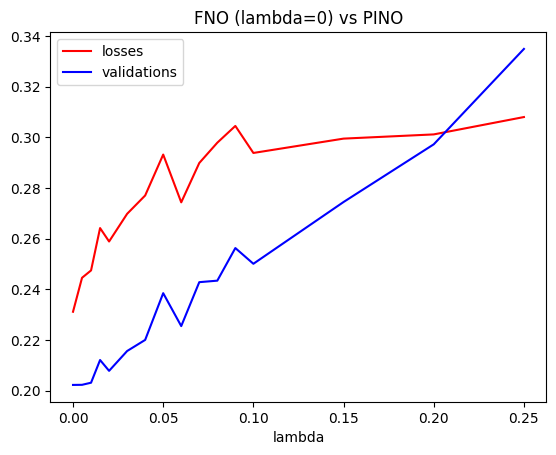

In [22]:
plt.plot(lambdas, losses_finals, label='losses', color='red')
plt.plot(lambdas, validations_finals, label='validations', color='blue')
plt.legend()
plt.title('FNO (lambda=0) vs PINO')
plt.xlabel("lambda")
plt.show()

И мы отчетливо видим, что в постановке 'full data' (когда мы восстанавливаем целые пространственно-временные кубы) чистый FNO всегда лучше PINO

In [23]:
data_path = './NavierStokes_V1e-5_N1200_T20.mat'
reader = MatReader(data_path)
w = reader.read_field('u')
N_samples, GRID_SIZE, GRID_SIZE, TIME_STEPS = w.shape

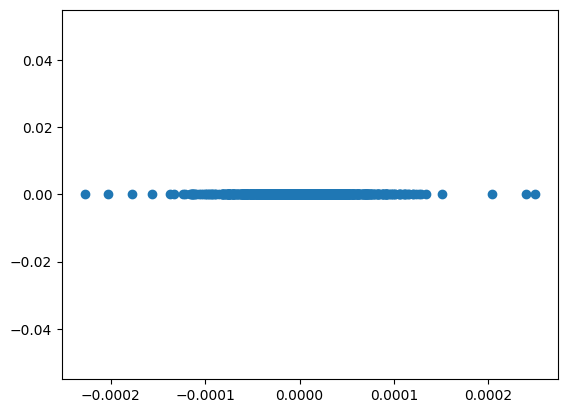

In [29]:
x = w.mean(dim=(-1,-2,-3))
y = np.zeros_like(x)
plt.scatter(x,y)

In [48]:
means = torch.abs(w.mean(dim=(-1,-2,-3)))
mask = means > 0.00006
len(means[mask])

176

Можем запустить цикл обучения и валидации модели, где отбор в обучающую и валидационную выборки будут производиться по принципу отклонения среднего w от среднего по выборке (ожидаемо это 0) или дисперсии w от средней дисперсии по выборке или по совокупности обоих факторов. Однако, с точки зрения решения задачи сравнения эффективности чистого FNO и PINO на осонове FNO это не дает нам никакого нового знания. Просто ожидаемо, валидационная метрика вырастет (т.к. на валидации модель будет чаще сталкиваться со структурами, котоыре до сих пор не встречала).

Что мне действительно интересно — так это как метрика в среднем падает в зависимости от временного шага. Проверим это.

In [ ]:
data_path = './NavierStokes_V1e-5_N1200_T20.mat'
reader = MatReader(data_path)
w = reader.read_field('u')
N_samples, GRID_SIZE, GRID_SIZE, TIME_STEPS = w.shape
w = w[1024:N_samples,...]
N_samples, GRID_SIZE, GRID_SIZE, TIME_STEPS = w.shape
w = w.to(device)

x = torch.linspace(0, 1, GRID_SIZE)
y = torch.linspace(0, 1, GRID_SIZE)
t = torch.linspace(0, 1, TIME_STEPS)

X_, Y_, T_ = torch.meshgrid(x, y, t, indexing='ij')

X = torch.cat(N_samples * [X_.clone().unsqueeze(0)]).unsqueeze(1)
Y = torch.cat(N_samples * [Y_.clone().unsqueeze(0)]).unsqueeze(1)
T = torch.cat(N_samples * [T_.clone().unsqueeze(0)]).unsqueeze(1)

input = torch.cat([X,Y,T], dim=1)

input[ :, 0, :, :, 0] = w[...,0]
input[ :, 1, :, :, 0] = w[...,0].transpose(1,2)
input = input.to(device)

model = torch.load('./pipeline/full_data/downsampled_finite_naive_7_7_7_fl_4_mc_16_pc_32_ReLU_lamb_0_000_E_200_BS_1_251004.pth', weights_only=False).to(device)
model1 = torch.load('./pipeline/full_data/downsampled_finite_naive_7_7_7_fl_4_mc_16_pc_32_ReLU_lamb_0_015_E_200_BS_1_251004.pth', weights_only=False).to(device)
model2 = torch.load('./pipeline/full_data/downsampled_finite_naive_7_7_7_fl_4_mc_16_pc_32_ReLU_lamb_0_020_E_200_BS_1_251005.pth', weights_only=False).to(device)
model3 = torch.load('./pipeline/full_data/downsampled_finite_naive_7_7_7_fl_4_mc_16_pc_32_ReLU_lamb_0_030_E_200_BS_1_251005.pth', weights_only=False).to(device)
model4 = torch.load('./pipeline/full_data/downsampled_finite_naive_7_7_7_fl_4_mc_16_pc_32_ReLU_lamb_0_100_E_200_BS_1_251005.pth', weights_only=False).to(device)
model5 = torch.load('./pipeline/full_data/downsampled_finite_naive_7_7_7_fl_4_mc_16_pc_32_ReLU_lamb_0_200_E_200_BS_1_251006.pth', weights_only=False).to(device)
model.eval()
model1.eval()
model2.eval()
model3.eval()
model4.eval()
model5.eval()
with torch.no_grad():
    outputs = model(input).squeeze(1)
    outputs1 = model1(input).squeeze(1)
    outputs2 = model2(input).squeeze(1)
    outputs3 = model3(input).squeeze(1)
    outputs4 = model4(input).squeeze(1)
    outputs5 = model5(input).squeeze(1)

In [78]:
metric = torch.sqrt((outputs-w)**2).mean(dim=(0,1,2))
metric1 = torch.sqrt((outputs1-w)**2).mean(dim=(0,1,2))
metric2 = torch.sqrt((outputs2-w)**2).mean(dim=(0,1,2))
metric3 = torch.sqrt((outputs3-w)**2).mean(dim=(0,1,2))
metric4 = torch.sqrt((outputs4-w)**2).mean(dim=(0,1,2))
metric5 = torch.sqrt((outputs5-w)**2).mean(dim=(0,1,2))

Text(0.5, 0, 'time_step')

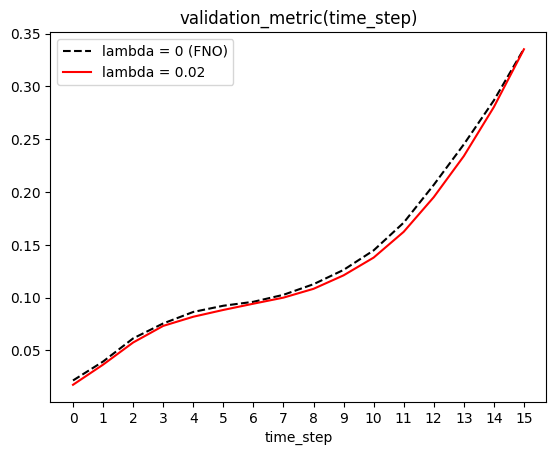

In [83]:
beginning_step = 0
end_step = 16
plt.xticks(np.arange(len(metric[beginning_step:end_step])))
plt.plot(np.arange(len(metric[beginning_step:end_step])), metric.cpu().numpy()[beginning_step:end_step], label='lambda = 0 (FNO)', color='k', linestyle='dashed')
# plt.plot(np.arange(len(metric[beginning_step:end_step])), metric1.cpu().numpy()[beginning_step:end_step], label='lambda = 0.015', color='b')
plt.plot(np.arange(len(metric[beginning_step:end_step])), metric2.cpu().numpy()[beginning_step:end_step], label='lambda = 0.02', color='r')
# plt.plot(np.arange(len(metric[beginning_step:end_step])), metric3.cpu().numpy()[beginning_step:end_step], label='lambda = 0.03', color='g')
# plt.plot(np.arange(len(metric[beginning_step:end_step])), metric4.cpu().numpy()[beginning_step:end_step], label='lambda = 0.1', color='c')
# plt.plot(np.arange(len(metric[beginning_step:end_step])), metric5.cpu().numpy()[beginning_step:end_step], label='lambda = 0.2', color='m')
plt.legend()
plt.title('validation_metric(time_step)')
plt.xlabel("time_step")

Посмотрим как выглядят data loss (FNO loss) и physics-informed loss

In [4]:
def compute_t_derivative_finite_diff(w, dt=0.1):
        
        dt_filter = (torch.tensor([[[[-1, 0, 1]]]]).float() / 2.0).contiguous().view(1, 1, 1, 1, 3).to(w.device)
        w_t = F.conv3d(w, dt_filter, padding=(0, 0, 0)) / dt
        
        # из-за отсутствия паддинга размеры тензоров уменьшились. сделаем постпаддинг
        # производная по времени — единственная, для которой мы делаем постпаддинг
        # препаддинг делать не понятно как: периодические условия неприменимы, 0 будет означать обрыв функции, что неверно, продолжение теми же значениями — также проитиворечит физике
        # поэтому мы просто требуем неприрывности производной по времени на краях
        w_t = F.pad(w_t, (1,1, 0,0, 0,0), mode = 'replicate')  # 1,1 — t, 0,0 — y, 0,0 — x с конца

        return w_t
        

def compute_derivatives_finite_diff(w, dx=0.1, dy=0.1):


        dx_filter = (torch.tensor([[[[-1, 0, 1]]]]).float() / 2.0).contiguous().view(1, 1, 3, 1, 1).to(w.device)
        dy_filter = (torch.tensor([[[[-1, 0, 1]]]]).float() / 2.0).contiguous().view(1, 1, 1, 3, 1).to(w.device)

        w_padded_x = F.pad(w, (0,0, 0,0, 1,1), mode = 'circular')  # 0,0 — t, 0,0 — y, 1,1 — x с конца
        w_padded_y = F.pad(w, (0,0, 1,1, 0,0), mode = 'circular')  # 0,0 — t, 1,1 — y, 0,0 — x с конца
        
        w_x = F.conv3d(w_padded_x, dx_filter, padding=(0, 0, 0)) / dx
        w_y = F.conv3d(w_padded_y, dy_filter, padding=(0, 0, 0)) / dy

        return w_x, w_y



def compute_laplacian(w, dx=0.1, dy=0.1):
        
        #периодические границы
        w_padded = F.pad(w, (0,0, 1,1, 1,1), mode = 'circular')  # 0,0 — t, 0,0 — y, 1,1 — x с конца
        

        # Создаем 3D фильтр лапласиана
        laplace_filter_3d = torch.zeros(1, 1, 3, 3, 3).to(w.device)
        laplace_filter_3d[0,0,:,:,1] = torch.tensor([[[[0, 1, 0],
                                                       [1,-4, 1],
                                                       [0, 1, 0]]]]
                                                       ).float().contiguous()

        #2Д фильтр записан в 1й шаг 3Д фильтра по времени а не в нулевой, чтобы использовать padding = 1 по t,
        #если записать фильтр в нулевой шаг фильтра, то 0 шаг w по времени будет сворачиваться в нули
        #если же использовать padding=0 по t, то слои t=0 и t=T будут при 3d-свертке потеряны
        #то есть по сути наш фильтр - это 3-слойный куб, где первый слой — нули, второй слой — фильтр для 2D-послойной свертки и 3й слой — тоже нули
        laplacian = (F.conv3d(w_padded, laplace_filter_3d, padding=(0,0,1)) / (dx*dy))

        return laplacian

In [32]:
def calculate_phys_loss(w: torch.Tensor):
    visc = 1e-5

    N_samples, GRID_SIZE, GRID_SIZE, TIME_STEPS = w.shape

    w = w.unsqueeze(1)

    dx, dy, dt = 1/(GRID_SIZE - 1), 1/(GRID_SIZE - 1), 1

    x = torch.linspace(0, 1, GRID_SIZE)
    y = torch.linspace(0, 1, GRID_SIZE)
    t = torch.linspace(0, 1, TIME_STEPS)

    X_, Y_, T_ = torch.meshgrid(x, y, t, indexing='ij')

    X = torch.cat(N_samples * [X_.clone().unsqueeze(0)]).unsqueeze(1)
    Y = torch.cat(N_samples * [Y_.clone().unsqueeze(0)]).unsqueeze(1)

    f = 0.1*(torch.sin(2*np.pi*(X + Y)) + torch.cos(2*np.pi*(X + Y))).to(w.device)


    k_max = int(np.floor(GRID_SIZE/2))

    F_w = torch.fft.rfft2(w, dim = (2,3), norm='ortho')

    k_y = torch.cat((torch.arange(start=0, end=k_max, step=1, device=w.device), torch.arange(start=-k_max, end=0, step=1, device=w.device)), 0).repeat(GRID_SIZE,1)
    k_x = k_y.transpose(0,1)

    k_x = k_x[..., :k_max + 1].unsqueeze(-1).expand(-1, -1, TIME_STEPS)
    k_y = k_y[..., :k_max + 1].unsqueeze(-1).expand(-1, -1, TIME_STEPS)

    F_lap = 4 * (torch.pi**2) * (k_x**2 + k_y**2)
    F_lap[0,0] = 1.0 

    dealias = torch.logical_and(torch.abs(k_y) <= (3.0/5.0)*k_max, torch.abs(k_x) <= (3.0/5.0)*k_max).float().to(w.device)

    F_psi = (F_w/F_lap) * dealias

    psi = torch.fft.irfft2(F_psi, dim=(2,3), norm='ortho')

    psi_x, psi_y = compute_derivatives_finite_diff(psi, dx, dy)
    w_x, w_y = compute_derivatives_finite_diff(w, dx, dy)
    w_t = compute_t_derivative_finite_diff(w, dt)
    laplacian_w = compute_laplacian(w, dx, dy)
    Vx = psi_y
    Vy = -psi_x
    V_scalmul_grad_w = (Vx * w_x + Vy * w_y)

    physics_loss = w_t + V_scalmul_grad_w - visc * laplacian_w - f

    return physics_loss

In [38]:
data_path = './NavierStokes_V1e-5_N1200_T20.mat'
reader = MatReader(data_path)
w = reader.read_field('u')
N_samples, GRID_SIZE, GRID_SIZE, TIME_STEPS = w.shape
w = w.to(device)

x = torch.linspace(0, 1, GRID_SIZE)
y = torch.linspace(0, 1, GRID_SIZE)
t = torch.linspace(0, 1, TIME_STEPS)

X_, Y_, T_ = torch.meshgrid(x, y, t, indexing='ij')

X = torch.cat(N_samples * [X_.clone().unsqueeze(0)]).unsqueeze(1)
Y = torch.cat(N_samples * [Y_.clone().unsqueeze(0)]).unsqueeze(1)
T = torch.cat(N_samples * [T_.clone().unsqueeze(0)]).unsqueeze(1)

input = torch.cat([X,Y,T], dim=1)

input[ :, 0, :, :, 0] = w[...,0]
input[ :, 1, :, :, 0] = w[...,0].transpose(1,2)
input = input.to(device)

data_loader = DataLoader(TensorDataset(input, w.unsqueeze(1)), batch_size=1, shuffle=False)

model = torch.load('./pipeline/full_data/downsampled_finite_naive_7_7_7_fl_4_mc_16_pc_32_ReLU_lamb_0_000_E_200_BS_1_251004.pth', weights_only=False).to(device)

metric_history = []
for data in data_loader:
    outputs = model(data[0]).detach()
    data_loss = torch.sqrt((outputs-data[1])**2).squeeze(1).mean(dim=(0, -3, -2))
    metric_history.append(data_loss)

In [39]:
data_loss = torch.stack(metric_history, dim=0).mean(dim=0)
data_loss = data_loss.cpu().numpy()

In [40]:
data_path='./NavierStokes_V1e-5_N1200_T20.mat'
reader = MatReader(data_path)
w = reader.read_field('u')
w=w.to(device)

phys_loss_hist = torch.Tensor([frobenius.mean() for frobenius in torch.sqrt(calculate_phys_loss(w).squeeze(1).permute(-1,0,1,2)**2)])
phys_loss_hist = phys_loss_hist.cpu().numpy()

In [41]:
phys_loss_FNO_hist = torch.Tensor([frobenius.mean() for frobenius in torch.sqrt(calculate_phys_loss(outputs.squeeze(1)).squeeze(1).permute(-1,0,1,2)**2)])
phys_loss_FNO_hist = phys_loss_FNO_hist.cpu().numpy()

Text(0.5, 0, 'time_step')

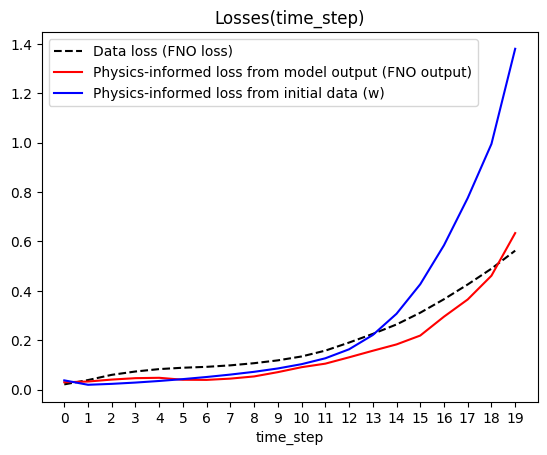

In [43]:
beginning_step = 0
end_step = 20
plt.xticks(np.arange(len(data_loss[beginning_step:end_step])))
plt.plot(np.arange(len(data_loss[beginning_step:end_step])), data_loss[beginning_step:end_step], label='Data loss (FNO loss)', color='k', linestyle='dashed')
plt.plot(np.arange(len(data_loss[beginning_step:end_step])), phys_loss_FNO_hist[beginning_step:end_step], label='Physics-informed loss from model output (FNO output)', color='r')
plt.plot(np.arange(len(data_loss[beginning_step:end_step])), phys_loss_hist[beginning_step:end_step], label='Physics-informed loss from initial data (w)', color='b')
plt.legend()
plt.title('Losses(time_step)')
plt.xlabel("time_step")

Что крайне интересно в этом графике: FNO-лосс (Data-лосс) очень по профилю и масшабу близок к PINO, посчитанному точно по уравнениям. Моя гипотеза состоит в том, что чистый фно достаточной глубины очень недурно обобщает физику и без помощников. Достаточно мощный оператор сам по себе

Попробуем повысить эффективность PINO поварьировав параметр лямбда около значения 0.02

In [17]:
train_pipeline = PINO_train_pipeline(lamb_set=torch.cat((torch.arange(0.016, 0.02, 0.001), torch.arange(0.021, 0.026, 0.001)), dim=0))
training_data = train_pipeline.train()


Training for lambda = 0.016


 25%|██▌       | 50/200 [35:18<1:46:01, 42.41s/it]

Epoch 50, loss: 0.3401, validation metric: 0.2937


 50%|█████     | 100/200 [1:10:40<1:10:42, 42.42s/it]

Epoch 100, loss: 0.3107, validation metric: 0.2501


 75%|███████▌  | 150/200 [1:46:19<35:45, 42.91s/it]  

Epoch 150, loss: 0.2899, validation metric: 0.2317


100%|██████████| 200/200 [2:21:47<00:00, 42.54s/it]

Epoch 200, loss: 0.2745, validation metric: 0.2146

Training for lambda = 0.017



 25%|██▌       | 50/200 [35:19<1:45:55, 42.37s/it]

Epoch 50, loss: 0.3295, validation metric: 0.2714


 50%|█████     | 100/200 [1:10:38<1:10:39, 42.39s/it]

Epoch 100, loss: 0.2936, validation metric: 0.2344


 75%|███████▌  | 150/200 [1:45:57<35:19, 42.38s/it]  

Epoch 150, loss: 0.2730, validation metric: 0.2145


100%|██████████| 200/200 [2:21:16<00:00, 42.38s/it]

Epoch 200, loss: 0.2592, validation metric: 0.2036

Training for lambda = 0.018



 25%|██▌       | 50/200 [35:18<1:45:39, 42.26s/it]

Epoch 50, loss: 0.3322, validation metric: 0.2753


 50%|█████     | 100/200 [1:10:36<1:10:37, 42.37s/it]

Epoch 100, loss: 0.2962, validation metric: 0.2347


 75%|███████▌  | 150/200 [1:45:55<35:19, 42.39s/it]  

Epoch 150, loss: 0.2759, validation metric: 0.2196


100%|██████████| 200/200 [2:21:14<00:00, 42.37s/it]

Epoch 200, loss: 0.2626, validation metric: 0.2108

Training for lambda = 0.019



 25%|██▌       | 50/200 [35:12<1:45:54, 42.36s/it]

Epoch 50, loss: 0.3333, validation metric: 0.2778


 50%|█████     | 100/200 [1:10:32<1:10:40, 42.41s/it]

Epoch 100, loss: 0.2985, validation metric: 0.2398


 75%|███████▌  | 150/200 [1:45:54<35:21, 42.44s/it]  

Epoch 150, loss: 0.2784, validation metric: 0.2221


100%|██████████| 200/200 [2:21:21<00:00, 42.41s/it]

Epoch 200, loss: 0.2646, validation metric: 0.2085

Training for lambda = 0.021



 25%|██▌       | 50/200 [35:19<1:45:50, 42.34s/it]

Epoch 50, loss: 0.3437, validation metric: 0.3017


 50%|█████     | 100/200 [1:10:36<1:10:35, 42.36s/it]

Epoch 100, loss: 0.3170, validation metric: 0.2658


 75%|███████▌  | 150/200 [1:45:54<35:18, 42.36s/it]  

Epoch 150, loss: 0.2993, validation metric: 0.2474


100%|██████████| 200/200 [2:21:12<00:00, 42.36s/it]

Epoch 200, loss: 0.2865, validation metric: 0.2342

Training for lambda = 0.022



 25%|██▌       | 50/200 [35:20<1:45:59, 42.40s/it]

Epoch 50, loss: 0.3393, validation metric: 0.2897


 50%|█████     | 100/200 [1:10:41<1:10:40, 42.41s/it]

Epoch 100, loss: 0.3058, validation metric: 0.2447


 75%|███████▌  | 150/200 [1:46:01<35:20, 42.41s/it]  

Epoch 150, loss: 0.2840, validation metric: 0.2222


100%|██████████| 200/200 [2:21:23<00:00, 42.42s/it]

Epoch 200, loss: 0.2692, validation metric: 0.2108

Training for lambda = 0.023



 25%|██▌       | 50/200 [35:18<1:45:53, 42.35s/it]

Epoch 50, loss: 0.3524, validation metric: 0.3025


 50%|█████     | 100/200 [1:10:36<1:10:36, 42.36s/it]

Epoch 100, loss: 0.3204, validation metric: 0.2607


 75%|███████▌  | 150/200 [1:45:55<35:19, 42.38s/it]  

Epoch 150, loss: 0.2998, validation metric: 0.2398


100%|██████████| 200/200 [2:21:13<00:00, 42.37s/it]

Epoch 200, loss: 0.2857, validation metric: 0.2280

Training for lambda = 0.024



 25%|██▌       | 50/200 [35:20<1:46:02, 42.41s/it]

Epoch 50, loss: 0.3469, validation metric: 0.3051


 50%|█████     | 100/200 [1:10:39<1:10:37, 42.38s/it]

Epoch 100, loss: 0.3225, validation metric: 0.2737


 75%|███████▌  | 150/200 [1:45:57<35:16, 42.34s/it]  

Epoch 150, loss: 0.3041, validation metric: 0.2469


100%|██████████| 200/200 [2:21:14<00:00, 42.37s/it]

Epoch 200, loss: 0.2903, validation metric: 0.2333

Training for lambda = 0.025



 25%|██▌       | 50/200 [35:17<1:45:51, 42.34s/it]

Epoch 50, loss: 0.3329, validation metric: 0.2639


 50%|█████     | 100/200 [1:10:34<1:10:33, 42.33s/it]

Epoch 100, loss: 0.2970, validation metric: 0.2357


 75%|███████▌  | 150/200 [1:45:51<35:16, 42.33s/it]  

Epoch 150, loss: 0.2785, validation metric: 0.2252


100%|██████████| 200/200 [2:21:07<00:00, 42.34s/it]

Epoch 200, loss: 0.2665, validation metric: 0.2144
Training data successfully saved to downsampled_finite_naive_7_7_7_fl_4_mc_16_pc_32_ReLU_lamb__E_200_BS_1_251007.json


In [20]:
train_pipeline = PINO_train_pipeline(lamb_set=torch.arange(0.026, 0.03, 0.001))
training_data = train_pipeline.train()


Training for lambda = 0.026


 25%|██▌       | 50/200 [35:37<1:46:46, 42.71s/it]

Epoch 50, loss: 0.3265, validation metric: 0.2651


 50%|█████     | 100/200 [1:11:33<1:11:51, 43.12s/it]

Epoch 100, loss: 0.2936, validation metric: 0.2378


 75%|███████▌  | 150/200 [1:47:06<35:31, 42.64s/it]  

Epoch 150, loss: 0.2761, validation metric: 0.2225


100%|██████████| 200/200 [2:22:39<00:00, 42.80s/it]

Epoch 200, loss: 0.2644, validation metric: 0.2147

Training for lambda = 0.027



 25%|██▌       | 50/200 [35:35<1:46:47, 42.72s/it]

Epoch 50, loss: 0.3373, validation metric: 0.2812


 50%|█████     | 100/200 [1:11:11<1:11:11, 42.71s/it]

Epoch 100, loss: 0.3039, validation metric: 0.2444


 75%|███████▌  | 150/200 [1:46:48<35:17, 42.35s/it]  

Epoch 150, loss: 0.2844, validation metric: 0.2300


100%|██████████| 200/200 [2:22:06<00:00, 42.63s/it]

Epoch 200, loss: 0.2714, validation metric: 0.2160

Training for lambda = 0.028



 25%|██▌       | 50/200 [35:17<1:45:58, 42.39s/it]

Epoch 50, loss: 0.3298, validation metric: 0.2715


 50%|█████     | 100/200 [1:10:37<1:10:36, 42.36s/it]

Epoch 100, loss: 0.2972, validation metric: 0.2406


 75%|███████▌  | 150/200 [1:45:54<35:15, 42.31s/it]  

Epoch 150, loss: 0.2789, validation metric: 0.2262


100%|██████████| 200/200 [2:21:06<00:00, 42.33s/it]

Epoch 200, loss: 0.2665, validation metric: 0.2148

Training for lambda = 0.029



 25%|██▌       | 50/200 [35:18<1:45:56, 42.38s/it]

Epoch 50, loss: 0.3302, validation metric: 0.2658


 50%|█████     | 100/200 [1:10:38<1:10:37, 42.37s/it]

Epoch 100, loss: 0.2947, validation metric: 0.2364


 75%|███████▌  | 150/200 [1:46:04<35:19, 42.40s/it]  

Epoch 150, loss: 0.2754, validation metric: 0.2200


100%|██████████| 200/200 [2:21:38<00:00, 42.49s/it]

Epoch 200, loss: 0.2626, validation metric: 0.2108
Training data successfully saved to downsampled_finite_naive_7_7_7_fl_4_mc_16_pc_32_ReLU_lamb__E_200_BS_1_251008.json


Теперь необходимо создать функцию, которая будет загружать по одной все модели из папки и считать метрики для каждого шага по времени, записывая их в список словарей (для каждого лямбда — свой словарь)

In [5]:
def evaluate_models_in_folder(folder_path, name_pattern, data_path = './NavierStokes_V1e-5_N1200_T20.mat', device = 'mps'):

    
    reader = MatReader(data_path)
    w = reader.read_field('u')
    N_samples, GRID_SIZE, GRID_SIZE, TIME_STEPS = w.shape
    w = w[1024:N_samples,...]
    N_samples, GRID_SIZE, GRID_SIZE, TIME_STEPS = w.shape
    w = w.to(device)

    x = torch.linspace(0, 1, GRID_SIZE)
    y = torch.linspace(0, 1, GRID_SIZE)
    t = torch.linspace(0, 1, TIME_STEPS)

    X_, Y_, T_ = torch.meshgrid(x, y, t, indexing='ij')

    X = torch.cat(N_samples * [X_.clone().unsqueeze(0)]).unsqueeze(1)
    Y = torch.cat(N_samples * [Y_.clone().unsqueeze(0)]).unsqueeze(1)
    T = torch.cat(N_samples * [T_.clone().unsqueeze(0)]).unsqueeze(1)

    input = torch.cat([X,Y,T], dim=1)

    input[ :, 0, :, :, 0] = w[...,0]
    input[ :, 1, :, :, 0] = w[...,0].transpose(1,2)
    input = input.to(device)

    results = []
    
    # Регулярное выражение для поиска параметра lambda в имени файла
    lambda_pattern = re.compile(name_pattern + r'lamb_(\d+_?\d*)')
    
    for filename in os.listdir(folder_path):
        if not filename.endswith('.pth'):
            continue
            
        # Извлечение параметра lambda из имени файла
        match = lambda_pattern.search(filename)
        if not match:
            continue
            
        lambda_str = match.group(1).replace('_', '.')
        try:
            lambda_val = float(lambda_str)
        except ValueError:
            continue
            
        # Загрузка модели
        model_path = os.path.join(folder_path, filename)
        
        model = torch.load(model_path, weights_only=False).to(device)
        model.eval()
        with torch.no_grad():
            outputs = model(input).squeeze(1)
        
        metric = torch.sqrt((outputs-w)**2).mean(dim=(0,1,2))
        
        results.append({
            'lambda': lambda_val,
            'L1loss(t)': metric.cpu()
        })
    
    sorted_results = sorted(results, key=lambda x: x['lambda'])
            
    return sorted_results

In [67]:
results = evaluate_models_in_folder(folder_path = './pipeline/full_data/')

In [84]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd


def plot_cumulative_sums(results, start_index=10, end_index=20):

    
    fig = go.Figure()
    
    # Цвета для графиков
    colors = px.colors.sample_colorscale("hsv", [n/(end_index - start_index) for n in range(end_index - start_index + 1)])
    
    # Извлекаем значения lambda
    lambdas = [res['lambda'] for res in results]
    losses = [res['L1loss(t)'] for res in results]
    table_data = []

    for k in range(start_index, end_index + 1):
        sums = [loss[0:k].sum() for loss in losses]
        
        min_idx = np.argmin(sums)
        min_lambda = lambdas[min_idx]
        min_sum = sums[min_idx]

        fig.add_trace(go.Scatter(
            x=lambdas,
            y=sums,
            mode='lines',
            name=f'k={k} (λ_min={min_lambda:.4f})',
            hovertemplate=(
                "Лямбда: %{x:.4f}<br>" +
                "Сумма: %{y:.6f}<br>" +
                f"k: {k}<br>" +
                "<extra></extra>"
            ),
            line=dict(color=colors[k - start_index])
        ))
    fig.update_layout(
        title='ЗИнтеграл (сумма по t) под графиком метрики валидации от временного шага',
        xaxis_title='Lambda',
        hovermode='x unified',  # Единое окно для всех графиков при наведении
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=1.02,
            xanchor="center",
            x=0.5
        ),
        height=600
    )
    
    # Показываем график
    fig.show()

In [85]:
plot_cumulative_sums(results, start_index=14, end_index=20)

Итог: чем меньше шагов мы берем тем бОльший вклад PINO можем добавлять (но не более 0.025)
* PINO очень сильно расходится начиная с временных шагов 10-15. 
* Если берем все временные шаги, то вклад PINO будет 0 (чистый FNO выигрывает)
* Но стоит только отказаться от последнего временного шага и уже PINO делает положительный вклад в отклик модели
* Однако, это также может быть связано с недостаточной "емкостью" модели.

In [91]:
target_lambdas = [0, 0.02, 0.025, 0.029, 0.01]
filtered_results = [res for res in results if res['lambda'] in target_lambdas]

Text(0.5, 0, 'time_step')

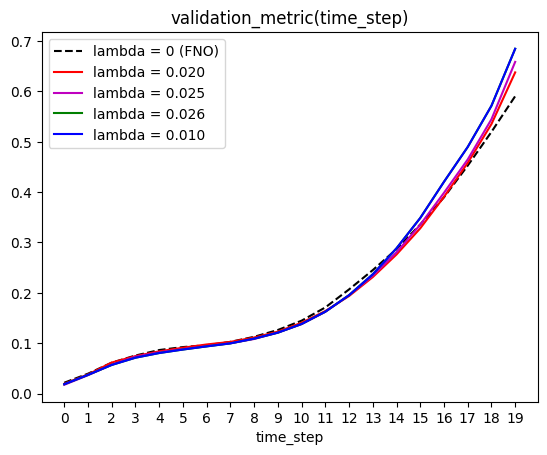

In [92]:
metric = filtered_results[0]['L1loss(t)']
metric1 = filtered_results[1]['L1loss(t)']
metric2 = filtered_results[2]['L1loss(t)']
metric3 = filtered_results[3]['L1loss(t)']
metric4 = filtered_results[4]['L1loss(t)']
beginning_step = 0
end_step = 20
plt.xticks(np.arange(len(metric[beginning_step:end_step])))
plt.plot(np.arange(len(metric[beginning_step:end_step])), metric[beginning_step:end_step], label='lambda = 0 (FNO)', color='k', linestyle='dashed')
plt.plot(np.arange(len(metric[beginning_step:end_step])), metric1[beginning_step:end_step], label='lambda = 0.020', color='r')
plt.plot(np.arange(len(metric[beginning_step:end_step])), metric2[beginning_step:end_step], label='lambda = 0.025', color='m')
plt.plot(np.arange(len(metric[beginning_step:end_step])), metric3[beginning_step:end_step], label='lambda = 0.026', color='g')
plt.plot(np.arange(len(metric[beginning_step:end_step])), metric3[beginning_step:end_step], label='lambda = 0.010', color='b')
plt.legend()
plt.title('validation_metric(time_step)')
plt.xlabel("time_step")

lambda = 0.02 выигрывает у всех на длительных временах. в дальнейших экспериментах используем ее

Попробуем взять модель значительно больше

In [ ]:
train_pipeline = PINO_train_pipeline(modes=[9,9,9], 
                                    num_fourier_layers=8, 
                                    mid_channels=48, 
                                    projection_channels=96,
                                    visc=1e-5,
                                    lamb_set=torch.Tensor([0,0.02,0.03]),
                                    adam_lr=1e-4,
                                    adam_batch=1,
                                    adam_epochs=200)
training_data = train_pipeline.train()

****Поробуем создать оператор с адаптивным тензором lamb. Возможно это будет заметно эффективнее.****

In [140]:
class PINO_adaptive(FNO_new):
    def __init__(self, visc = 1e-5, lamb_core_rank = 8, **kwargs):
        super().__init__(**kwargs)
        self.visc = visc
        self.lamb_core_rank = lamb_core_rank 
        self.batch_size = None
        self.GRID_SIZE = None
        self.TIME_STEPS = None
        self.lamb_factors = None
        self.dim_p = None

        self._setup_d_filters()

    def _setup_d_filters(self):
        
        dx_filter = (torch.tensor([[[[-1, 0, 1]]]]).float() / 2.0).contiguous().view(1, 1, 3, 1, 1)
        dy_filter = (torch.tensor([[[[-1, 0, 1]]]]).float() / 2.0).contiguous().view(1, 1, 1, 3, 1)
        dt_filter = (torch.tensor([[[[-1, 0, 1]]]]).float() / 2.0).contiguous().view(1, 1, 1, 1, 3)
        laplace_filter_3d = torch.zeros(1, 1, 3, 3, 3)
        laplace_filter_3d[0,0,:,:,1] = torch.tensor([[[[0, 1, 0],
                                                       [1,-4, 1],
                                                       [0, 1, 0]]]]
                                                    ).float().contiguous()


        self.register_buffer('dx_f', dx_filter)
        self.register_buffer('dy_f', dy_filter)
        self.register_buffer('dt_f', dt_filter)
        self.register_buffer('laplacian', laplace_filter_3d)
        

    def w_t(self, w, dt=1.0):

        w_t = F.conv3d(w, self.dt_f, padding=(0, 0, 0)) / dt

        # сделаем постпаддинг по t
        w_t = F.pad(w_t, (1,1, 0,0, 0,0), mode = 'replicate')  # 1,1 — t, 0,0 — y, 0,0 — x с конца

        return w_t
    
        

    def compute_derivatives_finite_diff(self, w):

            B, C, GRID_SIZE, GRID_SIZE, T = w.shape
            dx, dy = 1/(GRID_SIZE - 1), 1/(GRID_SIZE - 1)
            w_padded_x = F.pad(w, (0,0, 0,0, 1,1), mode = 'circular')  # 0,0 — t, 0,0 — y, 1,1 — x с конца
            w_padded_y = F.pad(w, (0,0, 1,1, 0,0), mode = 'circular')  # 0,0 — t, 1,1 — y, 0,0 — x с конца
            w_x = F.conv3d(w_padded_x, self.dx_f, padding=(0, 0, 0)) / dx
            w_y = F.conv3d(w_padded_y, self.dy_f, padding=(0, 0, 0)) / dy

            return w_x, w_y


    def compute_laplacian(self, w):
            
        B, C, GRID_SIZE, GRID_SIZE, T = w.shape
        dx, dy = 1/(GRID_SIZE - 1), 1/(GRID_SIZE - 1)
        w_padded = F.pad(w, (0,0, 1,1, 1,1), mode = 'circular')  # 0,0 — t, 0,0 — y, 1,1 — x с конца
        laplacian = F.conv3d(w_padded, self.laplacian, padding=(0,0,1)) / (dx*dy)
        
        return laplacian


    def physics_loss_fast(self, inputs, x, y, dt):  # Вычисляем физическое ограничение dw/dt + (v,grad(w)) - visc * laplasian(w) - f 
        
        f = 0.1*(torch.sin(2*torch.pi*(x + y)) + torch.cos(2*torch.pi*(x + y))) 

        w = inputs.unsqueeze(1)

        B, C, N, N, T = w.shape

        k_max = int(np.floor(N/2))

        F_w = torch.fft.rfft2(w, dim = (2,3), norm='ortho')

        k_y = torch.cat((torch.arange(start=0, end=k_max, step=1, device=w.device), torch.arange(start=-k_max, end=0, step=1, device=w.device)), 0).repeat(N,1)
        k_x = k_y.transpose(0,1)

        k_x = k_x[..., :k_max + 1].unsqueeze(-1).expand(-1, -1, T)
        k_y = k_y[..., :k_max + 1].unsqueeze(-1).expand(-1, -1, T)

        F_lap = 4 * (torch.pi**2) * (k_x**2 + k_y**2)
        F_lap[0,0] = 1.0 
        
        dealias = torch.logical_and(torch.abs(k_y) <= (3.0/5.0)*k_max, torch.abs(k_x) <= (3.0/5.0)*k_max).float().to(w.device)

        F_psi = (F_w/F_lap) * dealias

        psi = torch.fft.irfft2(F_psi, dim=(2,3), norm='ortho')

        psi_x, psi_y = self.compute_derivatives_finite_diff(psi)
        Vx = psi_y
        Vy = -psi_x

        w_x, w_y = self.compute_derivatives_finite_diff(w)
        w_t = self.w_t(w, dt=dt)

        laplacian_w = self.compute_laplacian(w)

        V_scalmul_grad_w = Vx * w_x + Vy * w_y

        residual = w_t + V_scalmul_grad_w - self.visc * laplacian_w - f

        return (residual**2)*100
    
    
    def forward(self, inputs):
        if self.batch_size is None:
            self.batch_size, _, self.GRID_SIZE, _, self.TIME_STEPS = inputs.shape
            self.dim_p = len(inputs.shape)
        if self.lamb_factors is None:
            lamb_tensor_shape = (self.GRID_SIZE, self.GRID_SIZE, self.TIME_STEPS)
            lamb_tensor = nn.init.xavier_uniform_(torch.empty(lamb_tensor_shape, dtype=torch.float32, device=inputs.device)).contiguous() # первичная инициализация. размеры будут назначены при первом прогоне forward
            _, lamb_factors = tucker(lamb_tensor, rank = [self.lamb_core_rank] * (self.dim_p - 1)) # раскладываем lambda_tensor на ядро (не нужное) и обучаемые факторы
            self.lamb_factors = nn.ParameterList([nn.Parameter(factor).contiguous() for factor in lamb_factors]) # регистрируем факторы как обучаемые тензоры модели
        return super().forward(inputs)
    
    def loss(self, inputs, target, X, Y, dt=1):
        mse_tensor = nn.L1Loss(reduction='none')(inputs, target).unsqueeze(1) #.mean(dim=0) # вычисляем полный тензор ошибок [batch, 1, grid, grid, steps]
        # mse_core, _ = tucker(mse_tensor, rank = [self.lamb_core_rank] * (self.dim_p-1)) # раскладываем mse в разложение Такера. Из него нам понадобится только ядро
        
        filter_grid_size = int(self.GRID_SIZE - self.lamb_core_rank+1)
        filter_time_steps = int(self.TIME_STEPS - self.lamb_core_rank +1)

        mse_core = nn.Conv3d(in_channels=1,    # это еще одна независимая идея получения ядра Такера через 3д свертку с соответствующего размера фильтром
                            out_channels=1,    # этот алгоритм еще медленнее, но ядро полученное через разложение Такера вызывало "взрыв" градиентов
                            kernel_size=(filter_grid_size, filter_grid_size, filter_time_steps), # здесь фильтр инициализируется случайным образом каждый запуск (нормальное распределение)
                            padding=0,                                                           # однако это не проблема: суммирование сверткой происходит по огромному количеству ячеек: 25х25х13 = 8125 
                            device=device)(mse_tensor).contiguous().squeeze(1).mean(dim=0)                    # поэтому здесь оправдан статистический подход

        lamb_tensor = tl.tucker_to_tensor((mse_core, [factor for factor in self.lamb_factors])).contiguous() # берем ядро разложения mse, обучаемые факторы разложения lambda_tensor и собираем из них lambda_tensor
        physics_loss = self.physics_loss_fast(inputs=inputs, x=X, y=Y, dt=dt).squeeze(1).contiguous()
        # mask = (lamb_tensor[..., :10] < 0) or (lamb_tensor[..., :10] > 0.03)
        # lamb_tensor[..., :10][mask] = 0.02
        lamda_on_PINO_loss = torch.einsum('xyt,bxyt->bxyt', lamb_tensor, physics_loss).contiguous()
        data_loss = nn.L1Loss(reduction='none')(inputs, target).contiguous()
        one_minus_lambda = (torch.Tensor([1]).to(device) - lamb_tensor).contiguous()
        one_minus_lambda_on_data_loss = torch.einsum('xyt,bxyt->bxyt', one_minus_lambda, data_loss).contiguous()
        return torch.mean(one_minus_lambda_on_data_loss + lamda_on_PINO_loss), lamb_tensor, data_loss.mean(), physics_loss.mean()

In [ ]:
model = PINO_adaptive(modes = [7,7,7], 
                     num_fourier_layers=4, 
                     in_channels=3, 
                     mid_channels=16, 
                     projection_channels=32, 
                     out_channels=1, 
                     activation=nn.ReLU(),
                     calc_finite = True,
                     visc=1e-5,  
                     ).to(device)

Adam = torch.optim.AdamW(model.parameters(), lr=1e-4)

model_PINO, loss_hist, validation_metric_hist, lambda_tensor, data_loss_hist, pino_loss_hist = train_FNO_advanced(model=model, 
                                                                                                                optimizer=Adam,
                                                                                                                EPOCHS=200, 
                                                                                                                BATCH_SIZE=1, 
                                                                                                                downsample=True, 
                                                                                                                device='mps')

In [106]:
# для формулы data_loss + lamb_tensor * PINO_loss
print('Среднее: ', lambda_tensor.mean().item(),' min:', lambda_tensor.min().item(),' max:', lambda_tensor.max().item(),' стандартное отклонение:', lambda_tensor.std().item(),' дисперсия:', lambda_tensor.var().item())

Среднее:  -0.00025973955052904785  min: -0.2959657311439514  max: 0.3864499032497406  стандартное отклонение: 0.029661862179636955  дисперсия: 0.0008798260241746902


Text(0.5, 0, 'epoch')

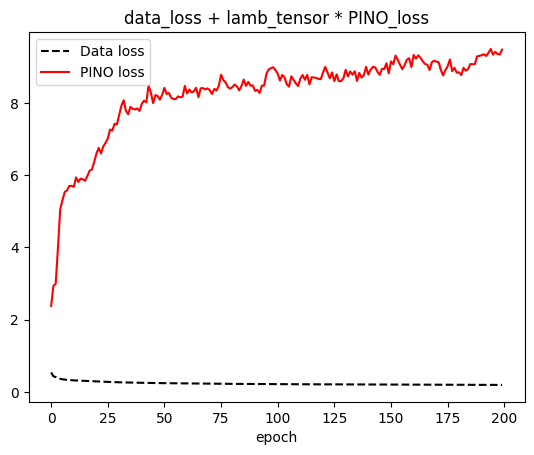

In [118]:
batch_size = 1024
data_batches = np.array_split(np.array(data_loss_hist), np.ceil(len(np.array(data_loss_hist)) / batch_size))
data_averages = [batch.mean() for batch in data_batches]
pino_batches = np.array_split(np.array(pino_loss_hist), np.ceil(len(np.array(pino_loss_hist)) / batch_size))
pino_averages = [batch.mean() for batch in pino_batches]
plt.plot(np.arange(len(data_averages)), data_averages, label='Data loss', color='k', linestyle='dashed')
plt.plot(np.arange(len(pino_averages)), pino_averages, label='PINO loss', color='r')
plt.legend()
plt.title('data_loss + lamb_tensor * PINO_loss')
plt.xlabel("epoch")

Text(0.5, 0, 'time_step')

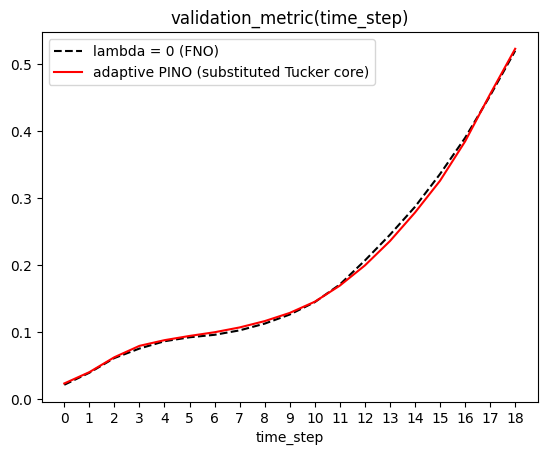

In [74]:
data_path = './NavierStokes_V1e-5_N1200_T20.mat'
reader = MatReader(data_path)
w = reader.read_field('u')
N_samples, GRID_SIZE, GRID_SIZE, TIME_STEPS = w.shape
w = w[1024:N_samples,...]
N_samples, GRID_SIZE, GRID_SIZE, TIME_STEPS = w.shape
w = w.to(device)

x = torch.linspace(0, 1, GRID_SIZE)
y = torch.linspace(0, 1, GRID_SIZE)
t = torch.linspace(0, 1, TIME_STEPS)

X_, Y_, T_ = torch.meshgrid(x, y, t, indexing='ij')

X = torch.cat(N_samples * [X_.clone().unsqueeze(0)]).unsqueeze(1)
Y = torch.cat(N_samples * [Y_.clone().unsqueeze(0)]).unsqueeze(1)
T = torch.cat(N_samples * [T_.clone().unsqueeze(0)]).unsqueeze(1)

input = torch.cat([X,Y,T], dim=1)

input[ :, 0, :, :, 0] = w[...,0]
input[ :, 1, :, :, 0] = w[...,0].transpose(1,2)
input = input.to(device)

model0 = torch.load('./pipeline/full_data/downsampled_finite_naive_7_7_7_fl_4_mc_16_pc_32_ReLU_lamb_0_000_E_200_BS_1_251004.pth', weights_only=False).to(device)

model0.eval()
model.eval()
with torch.no_grad():
    outputs0 = model0(input).squeeze(1)
    outputs = model(input).squeeze(1)

metric0 = torch.sqrt((outputs0-w)**2).mean(dim=(0,1,2))
metric = torch.sqrt((outputs-w)**2).mean(dim=(0,1,2))

beginning_step = 0
end_step = 19
plt.xticks(np.arange(len(metric0[beginning_step:end_step])))
plt.plot(np.arange(len(metric0[beginning_step:end_step])), metric0.cpu().numpy()[beginning_step:end_step], label='lambda = 0 (FNO)', color='k', linestyle='dashed')
plt.plot(np.arange(len(metric[beginning_step:end_step])), metric.cpu().numpy()[beginning_step:end_step], label='adaptive PINO (substituted Tucker core)', color='r')
plt.legend()
plt.title('validation_metric(time_step)')
plt.xlabel("time_step")

* Хоть данная архитектура в среднем и успешна, она достаточно сложна и, самое главное — контринтуитивна. Математически будет сложно обосновать ее устойчивость. 
* Возможно есть смысл рассмотреть Unet-like (SegNet) архитектуру с активацией, исключающей зануление весов в процессе обучения.

In [153]:
class PINO_adaptive_Unet(FNO_new):
    def __init__(self, visc = 1e-5, lambda_lifting = 32, epsilon = 1e-9, device='cpu', **kwargs):
        super().__init__(**kwargs)
        self.device = device
        self.visc = visc
        self.lambda_lifting = lambda_lifting
        self.epsilon = epsilon
        self.batch_size = None
        self.GRID_SIZE = None
        self.TIME_STEPS = None

        self.dimp = None
        self.lamb_tensor = None

        self._setup_d_filters()

        self.conv = None
        self.batch_norm = nn.BatchNorm3d(num_features=self.lambda_lifting, device='cpu')
        self.transpose = None


    def _setup_d_filters(self):
        
        dx_filter = (torch.tensor([[[[-1, 0, 1]]]]).float() / 2.0).contiguous().view(1, 1, 3, 1, 1)
        dy_filter = (torch.tensor([[[[-1, 0, 1]]]]).float() / 2.0).contiguous().view(1, 1, 1, 3, 1)
        dt_filter = (torch.tensor([[[[-1, 0, 1]]]]).float() / 2.0).contiguous().view(1, 1, 1, 1, 3)
        laplace_filter_3d = torch.zeros(1, 1, 3, 3, 3)
        laplace_filter_3d[0,0,:,:,1] = torch.tensor([[[[0, 1, 0],
                                                       [1,-4, 1],
                                                       [0, 1, 0]]]]
                                                    ).float().contiguous()

        self.register_buffer('dx_f', dx_filter)
        self.register_buffer('dy_f', dy_filter)
        self.register_buffer('dt_f', dt_filter)
        self.register_buffer('laplacian', laplace_filter_3d)
        

    def w_t(self, w, dt=1.0):

        w_t = F.conv3d(w, self.dt_f, padding=(0, 0, 0)) / dt

        # сделаем постпаддинг по t
        w_t = F.pad(w_t, (1,1, 0,0, 0,0), mode = 'replicate')  # 1,1 — t, 0,0 — y, 0,0 — x с конца

        return w_t
    
        

    def compute_derivatives_finite_diff(self, w):

        B, C, GRID_SIZE, GRID_SIZE, T = w.shape
        dx, dy = 1/(GRID_SIZE - 1), 1/(GRID_SIZE - 1)
        w_padded_x = F.pad(w, (0,0, 0,0, 1,1), mode = 'circular')  # 0,0 — t, 0,0 — y, 1,1 — x с конца
        w_padded_y = F.pad(w, (0,0, 1,1, 0,0), mode = 'circular')  # 0,0 — t, 1,1 — y, 0,0 — x с конца
        w_x = F.conv3d(w_padded_x, self.dx_f, padding=(0, 0, 0)) / dx
        w_y = F.conv3d(w_padded_y, self.dy_f, padding=(0, 0, 0)) / dy

        return w_x, w_y


    def compute_laplacian(self, w):
            
        B, C, GRID_SIZE, GRID_SIZE, T = w.shape
        dx, dy = 1/(GRID_SIZE - 1), 1/(GRID_SIZE - 1)
        w_padded = F.pad(w, (0,0, 1,1, 1,1), mode = 'circular')  # 0,0 — t, 0,0 — y, 1,1 — x с конца
        laplacian = F.conv3d(w_padded, self.laplacian, padding=(0,0,1)) / (dx*dy)
        
        return laplacian


    def physics_loss_fast(self, inputs, x, y, dt):  # Вычисляем физическое ограничение dw/dt + (v,grad(w)) - visc * laplasian(w) - f 
        
        f = 0.1*(torch.sin(2*torch.pi*(x + y)) + torch.cos(2*torch.pi*(x + y))) 

        w = inputs.unsqueeze(1)

        B, C, N, N, T = w.shape

        k_max = int(np.floor(N/2))

        F_w = torch.fft.rfft2(w, dim = (2,3), norm='ortho')

        k_y = torch.cat((torch.arange(start=0, end=k_max, step=1, device=self.device), torch.arange(start=-k_max, end=0, step=1, device=self.device)), 0).repeat(N,1)
        k_x = k_y.transpose(0,1)

        k_x = k_x[..., :k_max + 1].unsqueeze(-1).expand(-1, -1, T)
        k_y = k_y[..., :k_max + 1].unsqueeze(-1).expand(-1, -1, T)

        F_lap = 4 * (torch.pi**2) * (k_x**2 + k_y**2)
        F_lap[0,0] = 1.0 
        
        dealias = torch.logical_and(torch.abs(k_y) <= (3.0/5.0)*k_max, torch.abs(k_x) <= (3.0/5.0)*k_max).float().to(self.device)

        F_psi = (F_w/F_lap) * dealias

        psi = torch.fft.irfft2(F_psi, dim=(2,3), norm='ortho')

        psi_x, psi_y = self.compute_derivatives_finite_diff(psi)
        Vx = psi_y
        Vy = -psi_x

        w_x, w_y = self.compute_derivatives_finite_diff(w)
        w_t = self.w_t(w, dt=dt)

        laplacian_w = self.compute_laplacian(w)

        V_scalmul_grad_w = Vx * w_x + Vy * w_y

        residual = w_t + V_scalmul_grad_w - self.visc * laplacian_w - f

        return (residual**2)#*100
    
    
    def forward(self, inputs):
        if self.batch_size is None:
            self.batch_size, _, self.GRID_SIZE, _, self.TIME_STEPS = inputs.shape
            self.dim_p = len(inputs.shape)
            filter_grid_size = int(self.GRID_SIZE-7)
            filter_time_steps = int(self.TIME_STEPS-7)
            self.lamb_tensor = nn.init.xavier_uniform_(torch.empty_like(inputs)).contiguous().cpu()
        if self.conv is None:
            self.conv = nn.Conv3d(1, self.lambda_lifting, kernel_size=(filter_grid_size, filter_grid_size, filter_time_steps), padding=0, bias=True, device='cpu')
            self.transpose = nn.ConvTranspose3d(self.lambda_lifting, 1, (filter_grid_size, filter_grid_size, filter_time_steps), padding=0, device='cpu')
        return super().forward(inputs)
    
    def loss(self, inputs, target, X, Y, dt=1):
        errors_tensor = nn.L1Loss(reduction='none')(inputs, target).unsqueeze(1)
        # errors_tensor = errors_tensor.to('cpu')
        # self.lamb_tensor = self.lamb_tensor.to('cpu')
        self.lamb_tensor = self.transpose(self.batch_norm(F.relu(self.conv(errors_tensor)))).contiguous()
        self.lamb_tensor = torch.sigmoid(self.lamb_tensor).contiguous()
        # self.lamb_tensor = self.lamb_tensor.to(self.device)
        PINO_loss = self.physics_loss_fast(inputs=inputs, x=X, y=Y, dt=dt).squeeze(1).contiguous()
        data_loss = nn.L1Loss(reduction='none')(inputs, target).contiguous()
        return torch.mean((torch.Tensor([1]) - self.lamb_tensor) * data_loss + self.lamb_tensor * PINO_loss), self.lamb_tensor, data_loss.mean(), PINO_loss.mean()

In [ ]:
class lambdanet(nn.Module):
    def __init__(self, lambda_lifting = 16):
        super().__init__()

        GRID_SIZE = 32
        TIME_STEPS = 20

        target_size = 8
        self.lambda_lifting = lambda_lifting
        filter_grid_size = int(GRID_SIZE-target_size+1)
        filter_time_steps = int(TIME_STEPS-target_size+1)

        self.conv = nn.Conv3d(1, self.lambda_lifting, kernel_size=(filter_grid_size, filter_grid_size, filter_time_steps), padding=0, bias=True, device='cpu')
        self.batch_norm = nn.BatchNorm3d(num_features=self.lambda_lifting, device='cpu')
        self.transpose = nn.ConvTranspose3d(self.lambda_lifting, 1, (filter_grid_size, filter_grid_size, filter_time_steps), padding=0, device='cpu')

    def forward(self, x):
        out = self.transpose(self.batch_norm(F.relu(self.conv(x))))
        
        return out
    
downsample=True
data_path = './NavierStokes_V1e-5_N1200_T20.mat'
reader = MatReader(data_path)
w = reader.read_field('u')
N_samples, GRID_SIZE, GRID_SIZE, TIME_STEPS = w.shape
if downsample:
    w = w.permute(0,3,1,2)
    GRID_SIZE = int(np.floor(GRID_SIZE/2))
    w = F.interpolate(w, size=(GRID_SIZE, GRID_SIZE), mode='bicubic', align_corners=False)
    w = w.permute(0,2,3,1)
    N_samples, GRID_SIZE, GRID_SIZE, TIME_STEPS = w.shape

w = w.unsqueeze(1)
N_samples, channels, GRID_SIZE, GRID_SIZE, TIME_STEPS = w.shape
sample = w[1000:1004,...]


dt = 1

x = torch.linspace(0, 1, GRID_SIZE)
y = torch.linspace(0, 1, GRID_SIZE)
t = torch.linspace(0, 1, TIME_STEPS)

X_, Y_, T_ = torch.meshgrid(x, y, t, indexing='ij')

BATCH_S, _, _, _, _ = sample.shape
X = torch.cat(BATCH_S * [X_.clone().unsqueeze(0)]).unsqueeze(1).to(device)
Y = torch.cat(BATCH_S * [Y_.clone().unsqueeze(0)]).unsqueeze(1).to(device)
T = torch.cat(BATCH_S * [T_.clone().unsqueeze(0)]).unsqueeze(1).to(device)                
input = torch.cat([X,Y,T], dim=1)

fno = FNO_new(modes = [4,4,4], 
                num_fourier_layers=1, 
                in_channels=3, 
                mid_channels=4, 
                projection_channels=8, 
                out_channels=1, 
                activation=nn.ReLU()).to(device)

output = fno(input.to(device))
output = output.contiguous().cpu()

model = lambdanet().to('cpu')
processed = model(output)

processed.shape

In [156]:
# для формулы data_loss + lamb_tensor * PINO_loss
print('Среднее: ', lambda_tensor.mean().item(),' min:', lambda_tensor.min().item(),' max:', lambda_tensor.max().item(),' стандартное отклонение:', lambda_tensor.std().item(),' дисперсия:', lambda_tensor.var().item())

Среднее:  -0.00025973955052904785  min: -0.2959657311439514  max: 0.3864499032497406  стандартное отклонение: 0.029661862179636955  дисперсия: 0.0008798260241746902


Обучение такой архитектуры происходит, но крайне медленно. Значительно хуже оригинального FNO и уж тем более — модели с лямбдой полученной с помощью Такера с ядром от лосса

Размер весов фильтра: torch.Size([1, 1, 25, 25, 13])
Среднее значение: 0.000140
Минимальное значение: -0.011094
Максимальное значение: 0.011089
Стандартное отклонение: 0.006375
Дисперсия: 0.000041


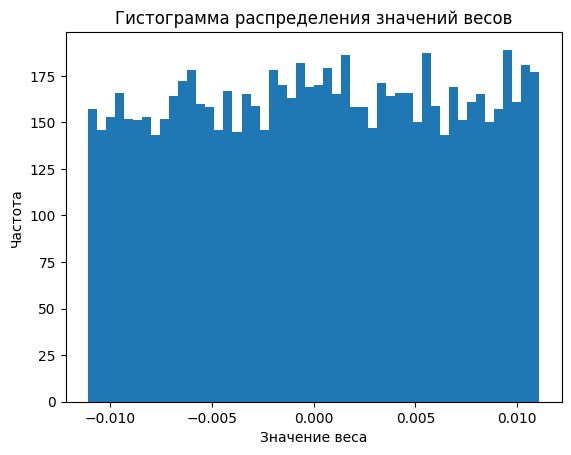

In [102]:
# Предположим, что ваш сверточный слой уже создан
# conv3d = nn.Conv3d(in_channels=..., out_channels=..., kernel_size=(13, 25, 25))

# Для примера создадим слой с вашим размером ядра
conv3d = nn.Conv3d(in_channels=1, out_channels=1, kernel_size=(25, 25, 13))

# Получаем тензор с весами фильтра
weights = conv3d.weight.data

# Принудительно вычисляем градиенты, если это необходимо (но для данных это обычно не нужно)
# weights = conv3d.weight

print("Размер весов фильтра:", weights.shape)

# Вычисляем базовую статистику
mean_value = weights.mean()
min_value = weights.min()
max_value = weights.max()
std_value = weights.std()
variance_value = weights.var()

print(f"Среднее значение: {mean_value:.6f}")
print(f"Минимальное значение: {min_value:.6f}")
print(f"Максимальное значение: {max_value:.6f}")
print(f"Стандартное отклонение: {std_value:.6f}")
print(f"Дисперсия: {variance_value:.6f}")

# Дополнительно: можно посмотреть гистограмму распределения весов
import matplotlib.pyplot as plt

plt.hist(weights.cpu().flatten().numpy(), bins=50)
plt.title("Гистограмма распределения значений весов")
plt.xlabel("Значение веса")
plt.ylabel("Частота")
plt.show()

Нам нужно сконструиировать детерминированный фильтр свертки ориентируясь на эти показатели.

In [ ]:
class PINO_adaptive_new(FNO_new):
    def __init__(self, visc = 1e-5, lamb_core_rank = 8, **kwargs):
        super().__init__(**kwargs)
        self.visc = visc
        self.lamb_core_rank = lamb_core_rank 
        self.batch_size = None
        self.GRID_SIZE = None
        self.TIME_STEPS = None
        self.lamb_factors = None
        self.dim_p = None

        self._setup_d_filters()

    def _setup_d_filters(self):
        
        dx_filter = (torch.tensor([[[[-1, 0, 1]]]]).float() / 2.0).contiguous().view(1, 1, 3, 1, 1)
        dy_filter = (torch.tensor([[[[-1, 0, 1]]]]).float() / 2.0).contiguous().view(1, 1, 1, 3, 1)
        dt_filter = (torch.tensor([[[[-1, 0, 1]]]]).float() / 2.0).contiguous().view(1, 1, 1, 1, 3)
        laplace_filter_3d = torch.zeros(1, 1, 3, 3, 3)
        laplace_filter_3d[0,0,:,:,1] = torch.tensor([[[[0, 1, 0],
                                                       [1,-4, 1],
                                                       [0, 1, 0]]]]
                                                    ).float().contiguous()


        self.register_buffer('dx_f', dx_filter)
        self.register_buffer('dy_f', dy_filter)
        self.register_buffer('dt_f', dt_filter)
        self.register_buffer('laplacian', laplace_filter_3d)
        

    def w_t(self, w, dt=1.0):

        w_t = F.conv3d(w, self.dt_f, padding=(0, 0, 0)) / dt

        # сделаем постпаддинг по t
        w_t = F.pad(w_t, (1,1, 0,0, 0,0), mode = 'replicate')  # 1,1 — t, 0,0 — y, 0,0 — x с конца

        return w_t
    
        

    def compute_derivatives_finite_diff(self, w):

            B, C, GRID_SIZE, GRID_SIZE, T = w.shape
            dx, dy = 1/(GRID_SIZE - 1), 1/(GRID_SIZE - 1)
            w_padded_x = F.pad(w, (0,0, 0,0, 1,1), mode = 'circular')  # 0,0 — t, 0,0 — y, 1,1 — x с конца
            w_padded_y = F.pad(w, (0,0, 1,1, 0,0), mode = 'circular')  # 0,0 — t, 1,1 — y, 0,0 — x с конца
            w_x = F.conv3d(w_padded_x, self.dx_f, padding=(0, 0, 0)) / dx
            w_y = F.conv3d(w_padded_y, self.dy_f, padding=(0, 0, 0)) / dy

            return w_x, w_y


    def compute_laplacian(self, w):
            
        B, C, GRID_SIZE, GRID_SIZE, T = w.shape
        dx, dy = 1/(GRID_SIZE - 1), 1/(GRID_SIZE - 1)
        w_padded = F.pad(w, (0,0, 1,1, 1,1), mode = 'circular')  # 0,0 — t, 0,0 — y, 1,1 — x с конца
        laplacian = F.conv3d(w_padded, self.laplacian, padding=(0,0,1)) / (dx*dy)
        
        return laplacian


    def physics_loss_fast(self, inputs, x, y, dt):  # Вычисляем физическое ограничение dw/dt + (v,grad(w)) - visc * laplasian(w) - f 
        
        f = 0.1*(torch.sin(2*torch.pi*(x + y)) + torch.cos(2*torch.pi*(x + y))) 

        w = inputs.unsqueeze(1)

        B, C, N, N, T = w.shape

        k_max = int(np.floor(N/2))

        F_w = torch.fft.rfft2(w, dim = (2,3), norm='ortho')

        k_y = torch.cat((torch.arange(start=0, end=k_max, step=1, device=w.device), torch.arange(start=-k_max, end=0, step=1, device=w.device)), 0).repeat(N,1)
        k_x = k_y.transpose(0,1)

        k_x = k_x[..., :k_max + 1].unsqueeze(-1).expand(-1, -1, T)
        k_y = k_y[..., :k_max + 1].unsqueeze(-1).expand(-1, -1, T)

        F_lap = 4 * (torch.pi**2) * (k_x**2 + k_y**2)
        F_lap[0,0] = 1.0 
        
        dealias = torch.logical_and(torch.abs(k_y) <= (3.0/5.0)*k_max, torch.abs(k_x) <= (3.0/5.0)*k_max).float().to(w.device)

        F_psi = (F_w/F_lap) * dealias

        psi = torch.fft.irfft2(F_psi, dim=(2,3), norm='ortho')

        psi_x, psi_y = self.compute_derivatives_finite_diff(psi)
        Vx = psi_y
        Vy = -psi_x

        w_x, w_y = self.compute_derivatives_finite_diff(w)
        w_t = self.w_t(w, dt=dt)

        laplacian_w = self.compute_laplacian(w)

        V_scalmul_grad_w = Vx * w_x + Vy * w_y

        residual = w_t + V_scalmul_grad_w - self.visc * laplacian_w - f

        return (residual**2)*100
    
    
    def forward(self, inputs):
        if self.batch_size is None:
            self.batch_size, _, self.GRID_SIZE, _, self.TIME_STEPS = inputs.shape
            self.dim_p = len(inputs.shape)
        if self.lamb_factors is None:
            lamb_tensor_shape = (self.GRID_SIZE, self.GRID_SIZE, self.TIME_STEPS)
            lamb_tensor = nn.init.xavier_uniform_(torch.empty(lamb_tensor_shape, dtype=torch.float32, device=inputs.device)).contiguous() # первичная инициализация. размеры будут назначены при первом прогоне forward
            _, lamb_factors = tucker(lamb_tensor, rank = [self.lamb_core_rank] * (self.dim_p - 1)) # раскладываем lambda_tensor на ядро (не нужное) и обучаемые факторы
            self.lamb_factors = nn.ParameterList([nn.Parameter(factor).contiguous() for factor in lamb_factors]) # регистрируем факторы как обучаемые тензоры модели

        
        
        return super().forward(inputs)
    
    def loss(self, inputs, target, X, Y, dt=1):
        mse_tensor = nn.L1Loss(reduction='none')(inputs, target).unsqueeze(1) #.mean(dim=0) # вычисляем полный тензор ошибок [batch, 1, grid, grid, steps]
        
        filter_grid_size = int(self.GRID_SIZE - self.lamb_core_rank+1)
        filter_time_steps = int(self.TIME_STEPS - self.lamb_core_rank +1)        
        filter_size = (self.batch_size, 1, filter_grid_size, filter_grid_size, filter_time_steps)
        mse_conv_flter = torch.ones(filter_size).float().contiguous().to(inputs.device) * 1e-7 # здесь у нас фильтр свертки который представляет собой 1e-7 распиханое по тензору [25,25,13] для сетки 32х32
        mse_core = F.conv3d(mse_tensor, mse_conv_flter).contiguous().squeeze(1).mean(dim=0) # а здесь просто происходит свертка до ядра [8,8,8] по большому счету это просто усреднение с понижающим k

        lamb_tensor = tl.tucker_to_tensor((mse_core, [factor for factor in self.lamb_factors])).contiguous() # берем ядро из свертки mse, обучаемые факторы разложения lambda_tensor и собираем из них lambda_tensor
        physics_loss = self.physics_loss_fast(inputs=inputs, x=X, y=Y, dt=dt).squeeze(1).contiguous()
        # mask = (lamb_tensor[..., :10] < 0) or (lamb_tensor[..., :10] > 0.03)
        # lamb_tensor[..., :10][mask] = 0.02
        lamda_on_PINO_loss = torch.einsum('xyt,bxyt->bxyt', lamb_tensor, physics_loss).contiguous()
        data_loss = nn.L1Loss(reduction='none')(inputs, target).contiguous()
        one_minus_lambda = (torch.Tensor([1]).to(device) - lamb_tensor).contiguous()
        one_minus_lambda_on_data_loss = torch.einsum('xyt,bxyt->bxyt', one_minus_lambda, data_loss).contiguous()
        return torch.mean(one_minus_lambda_on_data_loss + lamda_on_PINO_loss), lamb_tensor, data_loss.mean(), physics_loss.mean()

In [225]:
device = 'mps'
model = PINO_adaptive_new(modes = [7,7,7], 
                            num_fourier_layers=4, 
                            in_channels=3, 
                            mid_channels=16, 
                            projection_channels=32, 
                            out_channels=1, 
                            activation=nn.ReLU(),
                            calc_finite = True,
                            visc=1e-5,  
                            ).to(device)

Adam = torch.optim.AdamW(model.parameters(), lr=1e-4)

model_PINO, loss_hist, validation_metric_hist, lambda_tensor, data_loss_hist, pino_loss_hist = train_FNO_advanced(model=model, 
                                                                                                                optimizer=Adam,
                                                                                                                EPOCHS=200, 
                                                                                                                BATCH_SIZE=1, 
                                                                                                                downsample=True, 
                                                                                                                device='mps')

  5%|▌         | 10/200 [26:43<8:27:40, 160.32s/it]

Epoch 10, loss: 0.3940, validation metric: 0.3379


 10%|█         | 20/200 [53:33<8:05:13, 161.74s/it]

Epoch 20, loss: 0.3541, validation metric: 0.3159


 15%|█▌        | 30/200 [1:20:36<7:39:52, 162.31s/it]

Epoch 30, loss: 0.3346, validation metric: 0.2972


 20%|██        | 40/200 [1:47:50<7:16:39, 163.74s/it]

Epoch 40, loss: 0.3206, validation metric: 0.2774


 25%|██▌       | 50/200 [2:15:01<6:48:08, 163.26s/it]

Epoch 50, loss: 0.3089, validation metric: 0.2629


 30%|███       | 60/200 [2:42:17<6:20:58, 163.28s/it]

Epoch 60, loss: 0.2989, validation metric: 0.2519


 35%|███▌      | 70/200 [3:09:26<5:52:56, 162.90s/it]

Epoch 70, loss: 0.2904, validation metric: 0.2441


 40%|████      | 80/200 [3:36:35<5:25:44, 162.87s/it]

Epoch 80, loss: 0.2829, validation metric: 0.2370


 45%|████▌     | 90/200 [4:03:46<4:59:00, 163.10s/it]

Epoch 90, loss: 0.2764, validation metric: 0.2298


 50%|█████     | 100/200 [4:30:59<4:32:38, 163.58s/it]

Epoch 100, loss: 0.2705, validation metric: 0.2258


 55%|█████▌    | 110/200 [4:57:59<4:01:49, 161.22s/it]

Epoch 110, loss: 0.2652, validation metric: 0.2198


 60%|██████    | 120/200 [5:24:01<3:28:18, 156.23s/it]

Epoch 120, loss: 0.2605, validation metric: 0.2151


 65%|██████▌   | 130/200 [5:50:02<3:02:09, 156.14s/it]

Epoch 130, loss: 0.2561, validation metric: 0.2112


 70%|███████   | 140/200 [6:16:03<2:36:04, 156.07s/it]

Epoch 140, loss: 0.2521, validation metric: 0.2084


 75%|███████▌  | 150/200 [6:42:04<2:10:04, 156.10s/it]

Epoch 150, loss: 0.2484, validation metric: 0.2075


 80%|████████  | 160/200 [7:08:06<1:44:05, 156.13s/it]

Epoch 160, loss: 0.2449, validation metric: 0.2052


 85%|████████▌ | 170/200 [7:34:06<1:18:01, 156.05s/it]

Epoch 170, loss: 0.2418, validation metric: 0.2013


 90%|█████████ | 180/200 [8:00:08<52:02, 156.11s/it]  

Epoch 180, loss: 0.2388, validation metric: 0.1996


 95%|█████████▌| 190/200 [8:26:09<26:01, 156.11s/it]

Epoch 190, loss: 0.2360, validation metric: 0.1980


100%|██████████| 200/200 [8:52:10<00:00, 159.65s/it]

Epoch 200, loss: 0.2334, validation metric: 0.1977


In [226]:
# для формулы (1 - lamb_tensor) * data_loss + lamb_tensor * PINO_loss
print('Среднее: ', lambda_tensor.mean().item(),' min:', lambda_tensor.min().item(),' max:', lambda_tensor.max().item(),' стандартное отклонение:', lambda_tensor.std().item(),' дисперсия:', lambda_tensor.var().item())

Среднее:  -1.2872158450250026e-08  min: -0.00016488895926158875  max: 0.0001630244223633781  стандартное отклонение: 1.7895001292345114e-05  дисперсия: 3.2023109164391883e-10


Text(0.5, 0, 'epoch')

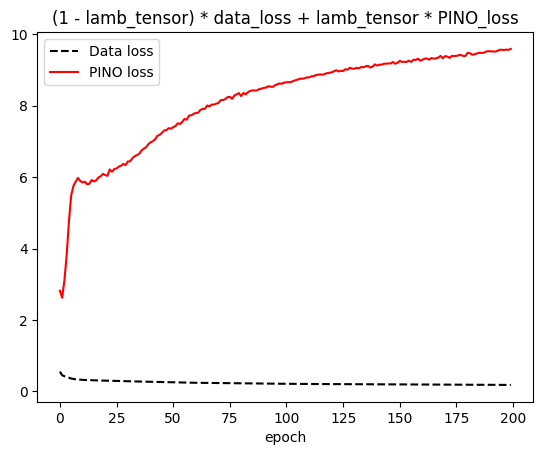

In [227]:
batch_size = 1024
data_batches = np.array_split(np.array(data_loss_hist), np.ceil(len(np.array(data_loss_hist)) / batch_size))
data_averages = [batch.mean() for batch in data_batches]
pino_batches = np.array_split(np.array(pino_loss_hist), np.ceil(len(np.array(pino_loss_hist)) / batch_size))
pino_averages = [batch.mean() for batch in pino_batches]
plt.plot(np.arange(len(data_averages)), data_averages, label='Data loss', color='k', linestyle='dashed')
plt.plot(np.arange(len(pino_averages)), pino_averages, label='PINO loss', color='r')
plt.legend()
plt.title('(1 - lamb_tensor) * data_loss + lamb_tensor * PINO_loss')
plt.xlabel("epoch")

Text(0.5, 0, 'time_step')

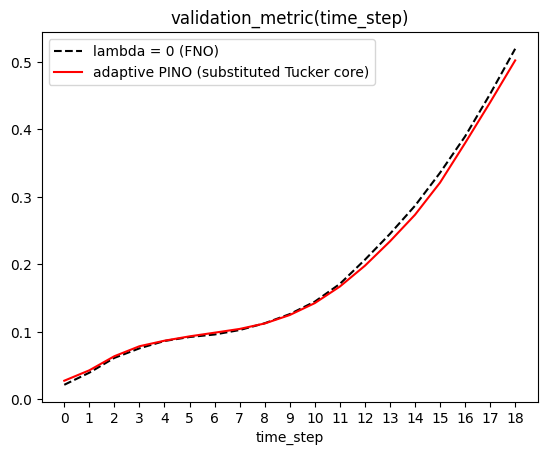

In [228]:
data_path = './NavierStokes_V1e-5_N1200_T20.mat'
reader = MatReader(data_path)
w = reader.read_field('u')
N_samples, GRID_SIZE, GRID_SIZE, TIME_STEPS = w.shape
w = w[1024:N_samples,...]
N_samples, GRID_SIZE, GRID_SIZE, TIME_STEPS = w.shape
w = w.to(device)

x = torch.linspace(0, 1, GRID_SIZE)
y = torch.linspace(0, 1, GRID_SIZE)
t = torch.linspace(0, 1, TIME_STEPS)

X_, Y_, T_ = torch.meshgrid(x, y, t, indexing='ij')

X = torch.cat(N_samples * [X_.clone().unsqueeze(0)]).unsqueeze(1)
Y = torch.cat(N_samples * [Y_.clone().unsqueeze(0)]).unsqueeze(1)
T = torch.cat(N_samples * [T_.clone().unsqueeze(0)]).unsqueeze(1)

input = torch.cat([X,Y,T], dim=1)

input[ :, 0, :, :, 0] = w[...,0]
input[ :, 1, :, :, 0] = w[...,0].transpose(1,2)
input = input.to(device)

model0 = torch.load('./pipeline/full_data/downsampled_finite_naive_7_7_7_fl_4_mc_16_pc_32_ReLU_lamb_0_000_E_200_BS_1_251004.pth', weights_only=False).to(device)

model0.eval()
model.eval()
with torch.no_grad():
    outputs0 = model0(input).squeeze(1)
    outputs = model(input).squeeze(1)

metric0 = torch.sqrt((outputs0-w)**2).mean(dim=(0,1,2))
metric = torch.sqrt((outputs-w)**2).mean(dim=(0,1,2))

beginning_step = 0
end_step = 19
plt.xticks(np.arange(len(metric0[beginning_step:end_step])))
plt.plot(np.arange(len(metric0[beginning_step:end_step])), metric0.cpu().numpy()[beginning_step:end_step], label='lambda = 0 (FNO)', color='k', linestyle='dashed')
plt.plot(np.arange(len(metric[beginning_step:end_step])), metric.cpu().numpy()[beginning_step:end_step], label='adaptive PINO (substituted Tucker core)', color='r')
plt.legend()
plt.title('validation_metric(time_step)')
plt.xlabel("time_step")

In [ ]:
# torch.save(model, 'downsampled_naive_7_7_7_fl_4_mc_16_pc_32_ReLU_adaptive_TuckerL1_E_200_BS_1_251014.pth')

In [230]:
device = 'cpu'

model = PINO_adaptive_Unet(modes = [7,7,7], 
                            num_fourier_layers=4, 
                            in_channels=3, 
                            mid_channels=16, 
                            projection_channels=32, 
                            out_channels=1, 
                            activation=nn.ReLU(),
                            calc_finite = True,
                            visc=1e-5,  
                            device='cpu')

Adam = torch.optim.AdamW(model.parameters(), lr=1e-4)


model_PINO, loss_hist, validation_metric_hist, lambda_tensor, data_loss_hist, pino_loss_hist = train_FNO_advanced(model=model, 
                                                                                                                    optimizer=Adam,
                                                                                                                    EPOCHS=200, 
                                                                                                                    BATCH_SIZE=1, 
                                                                                                                    downsample=True, 
                                                                                                                    device='cpu')

  5%|▌         | 10/200 [25:48<8:12:26, 155.51s/it]

Epoch 10, loss: 0.1917, validation metric: 0.3507


 10%|█         | 20/200 [51:27<7:43:47, 154.60s/it]

Epoch 20, loss: 0.1642, validation metric: 0.3274


 15%|█▌        | 30/200 [1:17:33<7:25:30, 157.24s/it]

Epoch 30, loss: 0.1479, validation metric: 0.3228


 20%|██        | 40/200 [1:43:36<6:57:05, 156.41s/it]

Epoch 40, loss: 0.1364, validation metric: 0.3118


 25%|██▌       | 50/200 [2:09:35<6:30:55, 156.37s/it]

Epoch 50, loss: 0.1275, validation metric: 0.3064


 30%|███       | 60/200 [2:35:35<6:04:39, 156.28s/it]

Epoch 60, loss: 0.1203, validation metric: 0.2989


 35%|███▌      | 70/200 [3:01:19<5:35:36, 154.89s/it]

Epoch 70, loss: 0.1142, validation metric: 0.2906


 40%|████      | 80/200 [3:27:14<5:09:21, 154.68s/it]

Epoch 80, loss: 0.1090, validation metric: 0.2840


 45%|████▌     | 90/200 [3:52:55<4:44:46, 155.33s/it]

Epoch 90, loss: 0.1045, validation metric: 0.2807


 50%|█████     | 100/200 [4:18:53<4:18:54, 155.35s/it]

Epoch 100, loss: 0.1005, validation metric: 0.2780


 55%|█████▌    | 110/200 [4:43:58<3:45:41, 150.46s/it]

Epoch 110, loss: 0.0970, validation metric: 0.2758


 60%|██████    | 120/200 [5:09:54<3:27:10, 155.38s/it]

Epoch 120, loss: 0.0939, validation metric: 0.2727


 65%|██████▌   | 130/200 [5:35:48<3:01:36, 155.67s/it]

Epoch 130, loss: 0.0911, validation metric: 0.2712


 70%|███████   | 140/200 [6:02:04<2:37:58, 157.97s/it]

Epoch 140, loss: 0.0885, validation metric: 0.2632


 75%|███████▌  | 150/200 [6:28:04<2:11:30, 157.82s/it]

Epoch 150, loss: 0.0862, validation metric: 0.2648


 80%|████████  | 160/200 [6:53:48<1:44:05, 156.15s/it]

Epoch 160, loss: 0.0841, validation metric: 0.2653


 85%|████████▌ | 170/200 [7:19:50<1:18:22, 156.74s/it]

Epoch 170, loss: 0.0822, validation metric: 0.2641


 90%|█████████ | 180/200 [7:45:48<51:29, 154.48s/it]  

Epoch 180, loss: 0.0804, validation metric: 0.2613


 95%|█████████▌| 190/200 [8:11:24<25:35, 153.55s/it]

Epoch 190, loss: 0.0787, validation metric: 0.2596


100%|██████████| 200/200 [8:37:16<00:00, 155.18s/it]

Epoch 200, loss: 0.0772, validation metric: 0.2575


In [231]:
# для формулы (1 - lamb_tensor) * data_loss + lamb_tensor * PINO_loss
print('Среднее: ', lambda_tensor.mean().item(),' min:', lambda_tensor.min().item(),' max:', lambda_tensor.max().item(),' стандартное отклонение:', lambda_tensor.std().item(),' дисперсия:', lambda_tensor.var().item())

Среднее:  0.7430389523506165  min: 3.2509586689322134e-10  max: 1.0  стандартное отклонение: 0.33589449524879456  дисперсия: 0.11282511800527573


Text(0.5, 0, 'epoch')

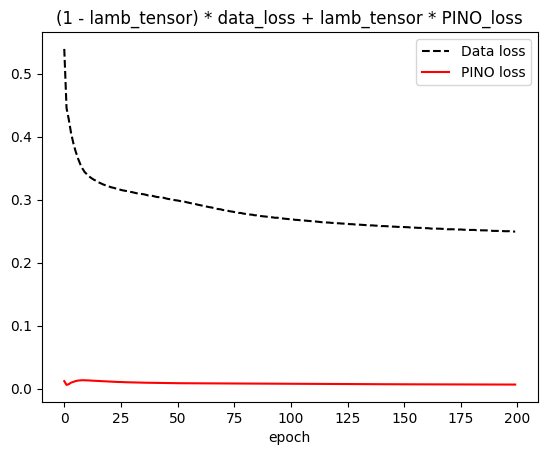

In [232]:
batch_size = 1024
data_batches = np.array_split(np.array(data_loss_hist), np.ceil(len(np.array(data_loss_hist)) / batch_size))
data_averages = [batch.mean() for batch in data_batches]
pino_batches = np.array_split(np.array(pino_loss_hist), np.ceil(len(np.array(pino_loss_hist)) / batch_size))
pino_averages = [batch.mean() for batch in pino_batches]
plt.plot(np.arange(len(data_averages)), data_averages, label='Data loss', color='k', linestyle='dashed')
plt.plot(np.arange(len(pino_averages)), pino_averages, label='PINO loss', color='r')
plt.legend()
plt.title('(1 - lamb_tensor) * data_loss + lamb_tensor * PINO_loss')
plt.xlabel("epoch")

Крайне любопытная история. Модель смогла обучиться так, чтобы минимизировать физический лосс.

Text(0.5, 0, 'time_step')

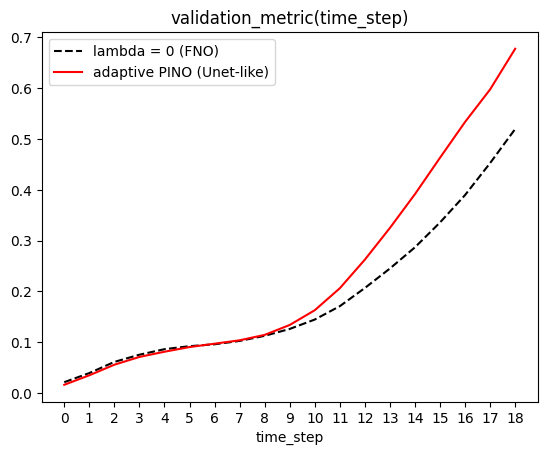

In [234]:
data_path = './NavierStokes_V1e-5_N1200_T20.mat'
reader = MatReader(data_path)
w = reader.read_field('u')
N_samples, GRID_SIZE, GRID_SIZE, TIME_STEPS = w.shape
w = w[1024:N_samples,...]
N_samples, GRID_SIZE, GRID_SIZE, TIME_STEPS = w.shape
w = w.to(device)

x = torch.linspace(0, 1, GRID_SIZE)
y = torch.linspace(0, 1, GRID_SIZE)
t = torch.linspace(0, 1, TIME_STEPS)

X_, Y_, T_ = torch.meshgrid(x, y, t, indexing='ij')

X = torch.cat(N_samples * [X_.clone().unsqueeze(0)]).unsqueeze(1)
Y = torch.cat(N_samples * [Y_.clone().unsqueeze(0)]).unsqueeze(1)
T = torch.cat(N_samples * [T_.clone().unsqueeze(0)]).unsqueeze(1)

input = torch.cat([X,Y,T], dim=1)

input[ :, 0, :, :, 0] = w[...,0]
input[ :, 1, :, :, 0] = w[...,0].transpose(1,2)
input = input.to(device)

model0 = torch.load('./pipeline/full_data/downsampled_finite_naive_7_7_7_fl_4_mc_16_pc_32_ReLU_lamb_0_000_E_200_BS_1_251004.pth', weights_only=False).to(device)

model0.eval()
model.eval()
with torch.no_grad():
    outputs0 = model0(input).squeeze(1)
    outputs = model(input).squeeze(1)

metric0 = torch.sqrt((outputs0-w)**2).mean(dim=(0,1,2))
metric = torch.sqrt((outputs-w)**2).mean(dim=(0,1,2))

beginning_step = 0
end_step = 19
plt.xticks(np.arange(len(metric0[beginning_step:end_step])))
plt.plot(np.arange(len(metric0[beginning_step:end_step])), metric0.cpu().numpy()[beginning_step:end_step], label='lambda = 0 (FNO)', color='k', linestyle='dashed')
plt.plot(np.arange(len(metric[beginning_step:end_step])), metric.cpu().numpy()[beginning_step:end_step], label='adaptive PINO (Unet-like)', color='r')
plt.legend()
plt.title('validation_metric(time_step)')
plt.xlabel("time_step")

In [241]:
downsample = True
N_sample = 1100
snapshot = 10 

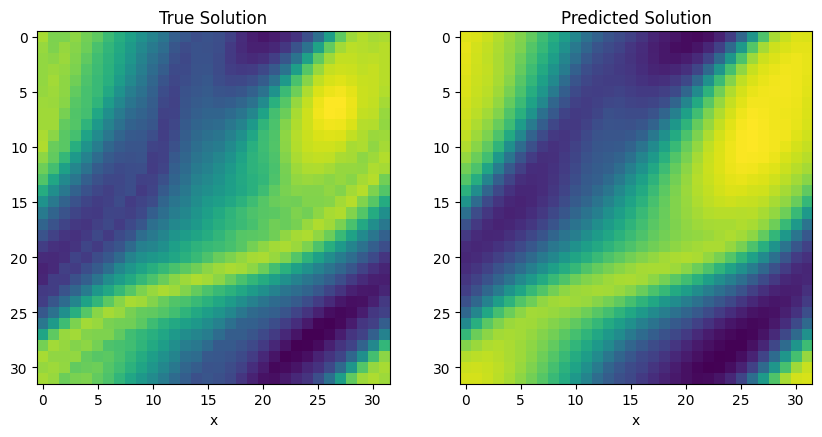

In [242]:
data_path='./NavierStokes_V1e-5_N1200_T20.mat'
reader = MatReader(data_path)
w = reader.read_field('u')
N_samples, GRID_SIZE, GRID_SIZE, TIME_STEPS = w.shape
if downsample:
    w = w.permute(0,3,1,2)
    GRID_SIZE = int(np.floor(GRID_SIZE/2))
    w = F.interpolate(w, size=(GRID_SIZE, GRID_SIZE), mode='bicubic', align_corners=False)
    w = w.permute(0,2,3,1)

with torch.no_grad():    
    w = reader.read_field('u')
    N_samples, GRID_SIZE, GRID_SIZE, TIME_STEPS = w.shape
    if downsample:
        w = w.permute(0,3,1,2)
        GRID_SIZE = int(np.floor(GRID_SIZE/2))
        w = F.interpolate(w, size=(GRID_SIZE, GRID_SIZE), mode='bicubic', align_corners=False)
        w = w.permute(0,2,3,1)
        N_samples, GRID_SIZE, GRID_SIZE, TIME_STEPS = w.shape
    x = torch.linspace(0, 1, GRID_SIZE)
    y = torch.linspace(0, 1, GRID_SIZE)
    t = torch.linspace(0, 1, TIME_STEPS)

    X_, Y_, T_ = torch.meshgrid(x, y, t, indexing='ij')

    X = X_.clone().unsqueeze(0).unsqueeze(1).to(device)
    Y = Y_.clone().unsqueeze(0).unsqueeze(1).to(device)
    T = T_.clone().unsqueeze(0).unsqueeze(1).to(device)
    
    input = torch.cat([X,Y,T], dim=1)

    input[0, 0, :, :, 0] = w[N_sample,:,:,0]
    input[0, 1, :, :, 0] = w[N_sample,:,:,0].T


    model.eval()
    output_ = model(input)
    
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title("True Solution")
plt.xlabel("x")
plt.imshow(w[N_sample,...][...,snapshot])
plt.subplot(1,2,2)
plt.title("Predicted Solution")
plt.xlabel("x")
plt.imshow(output_[...,snapshot].view(GRID_SIZE,GRID_SIZE).cpu())
plt.show()

Сильное расхождение чистого ФНО и физико-информированного лосса начиная с примерно 10 снэпшота, но при этом нельзя сказать, чтобы модель совсем не обучалась. Просто она больше обучалась тому, чтобы совсем свести к минимуму физико-информированный лосс. Как это произошло, пока не вполне ясно, т.к. PINO лосс считался от выходов ФНО. Здесь нужно бы доисследовать.

In [260]:
device = 'mps'
model = PINO_adaptive_tucker(modes = [7,7,7], 
                            num_fourier_layers=4, 
                            in_channels=3, 
                            mid_channels=16, 
                            projection_channels=32, 
                            out_channels=1, 
                            activation=nn.ReLU(),
                            calc_finite = True,
                            visc=1e-5,  
                            ).to(device)

Adam = torch.optim.AdamW(model.parameters(), lr=1e-4)

model_PINO, loss_hist, validation_metric_hist, lambda_tensor, data_loss_hist, pino_loss_hist = train_FNO_advanced(model=model, 
                                                                                                                optimizer=Adam,
                                                                                                                EPOCHS=200, 
                                                                                                                BATCH_SIZE=1, 
                                                                                                                downsample=True, 
                                                                                                                device='mps')

  5%|▌         | 10/200 [23:50<7:30:31, 142.27s/it]

Epoch 10, loss: 0.3793, validation metric: 0.3267


 10%|█         | 20/200 [48:12<7:19:11, 146.40s/it]

Epoch 20, loss: 0.3410, validation metric: 0.2939


 15%|█▌        | 30/200 [1:12:47<6:59:47, 148.16s/it]

Epoch 30, loss: 0.3182, validation metric: 0.2665


 20%|██        | 40/200 [1:37:44<6:39:48, 149.93s/it]

Epoch 40, loss: 0.3009, validation metric: 0.2476


 25%|██▌       | 50/200 [2:01:50<5:57:20, 142.94s/it]

Epoch 50, loss: 0.2874, validation metric: 0.2365


 30%|███       | 60/200 [2:25:44<5:35:18, 143.71s/it]

Epoch 60, loss: 0.2768, validation metric: 0.2289


 35%|███▌      | 70/200 [2:49:46<5:12:17, 144.13s/it]

Epoch 70, loss: 0.2682, validation metric: 0.2222


 40%|████      | 80/200 [3:13:50<4:48:58, 144.49s/it]

Epoch 80, loss: 0.2611, validation metric: 0.2174


 45%|████▌     | 90/200 [3:38:01<4:25:56, 145.06s/it]

Epoch 90, loss: 0.2550, validation metric: 0.2142


 50%|█████     | 100/200 [4:02:14<4:01:57, 145.17s/it]

Epoch 100, loss: 0.2498, validation metric: 0.2121


 55%|█████▌    | 110/200 [4:26:26<3:37:38, 145.09s/it]

Epoch 110, loss: 0.2452, validation metric: 0.2068


 60%|██████    | 120/200 [4:50:44<3:14:20, 145.75s/it]

Epoch 120, loss: 0.2411, validation metric: 0.2066


 65%|██████▌   | 130/200 [5:15:04<2:50:29, 146.13s/it]

Epoch 130, loss: 0.2374, validation metric: 0.2024


 70%|███████   | 140/200 [5:39:28<2:26:30, 146.51s/it]

Epoch 140, loss: 0.2341, validation metric: 0.2037


 75%|███████▌  | 150/200 [6:03:48<2:00:57, 145.14s/it]

Epoch 150, loss: 0.2310, validation metric: 0.1988


 80%|████████  | 160/200 [6:27:44<1:35:44, 143.61s/it]

Epoch 160, loss: 0.2283, validation metric: 0.1972


 85%|████████▌ | 170/200 [6:52:09<1:13:17, 146.58s/it]

Epoch 170, loss: 0.2257, validation metric: 0.1992


 90%|█████████ | 180/200 [7:16:37<48:58, 146.95s/it]  

Epoch 180, loss: 0.2233, validation metric: 0.1963


 95%|█████████▌| 190/200 [7:41:09<24:31, 147.15s/it]

Epoch 190, loss: 0.2211, validation metric: 0.1944


100%|██████████| 200/200 [8:05:40<00:00, 145.70s/it]

Epoch 200, loss: 0.2190, validation metric: 0.1922


In [261]:
print('Среднее: ', lambda_tensor.mean().item(),' min:', lambda_tensor.min().item(),' max:', lambda_tensor.max().item(),' стандартное отклонение:', lambda_tensor.std().item(),' дисперсия:', lambda_tensor.var().item())

Среднее:  -4.679529865825316e-06  min: -0.022542573511600494  max: 0.024248719215393066  стандартное отклонение: 0.002673128619790077  дисперсия: 7.145616109482944e-06


Text(0.5, 0, 'epoch')

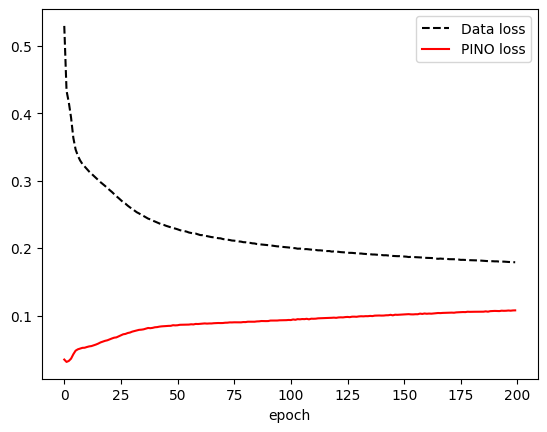

In [275]:
batch_size = 1024
data_batches = np.array_split(np.array(data_loss_hist), np.ceil(len(np.array(data_loss_hist)) / batch_size))
data_averages = [batch.mean() for batch in data_batches]
pino_batches = np.array_split(np.array(pino_loss_hist), np.ceil(len(np.array(pino_loss_hist)) / batch_size))
pino_averages = [batch.mean() for batch in pino_batches]
plt.plot(np.arange(len(data_averages)), data_averages, label='Data loss', color='k', linestyle='dashed')
plt.plot(np.arange(len(pino_averages)), pino_averages, label='PINO loss', color='r')
plt.legend()

plt.xlabel("epoch")

In [ ]:
data_path = './NavierStokes_V1e-5_N1200_T20.mat'
reader = MatReader(data_path)
w = reader.read_field('u')
N_samples, GRID_SIZE, GRID_SIZE, TIME_STEPS = w.shape
w = w[1024:N_samples,...]
N_samples, GRID_SIZE, GRID_SIZE, TIME_STEPS = w.shape
w = w.to(device)

x = torch.linspace(0, 1, GRID_SIZE)
y = torch.linspace(0, 1, GRID_SIZE)
t = torch.linspace(0, 1, TIME_STEPS)

X_, Y_, T_ = torch.meshgrid(x, y, t, indexing='ij')

X = torch.cat(N_samples * [X_.clone().unsqueeze(0)]).unsqueeze(1)
Y = torch.cat(N_samples * [Y_.clone().unsqueeze(0)]).unsqueeze(1)
T = torch.cat(N_samples * [T_.clone().unsqueeze(0)]).unsqueeze(1)

input = torch.cat([X,Y,T], dim=1)

input[ :, 0, :, :, 0] = w[...,0]
input[ :, 1, :, :, 0] = w[...,0].transpose(1,2)
input = input.to(device)

model0 = torch.load('./pipeline/full_data/downsampled_finite_naive_7_7_7_fl_4_mc_16_pc_32_ReLU_lamb_0_000_E_200_BS_1_251004.pth', weights_only=False).to(device)

model0.eval()
model.eval()
with torch.no_grad():
    outputs0 = model0(input).squeeze(1)
    outputs = model(input).squeeze(1)

metric0 = torch.sqrt((outputs0-w)**2).mean(dim=(0,1,2))
metric = torch.sqrt((outputs-w)**2).mean(dim=(0,1,2))


Text(0.5, 0, 'time_step')

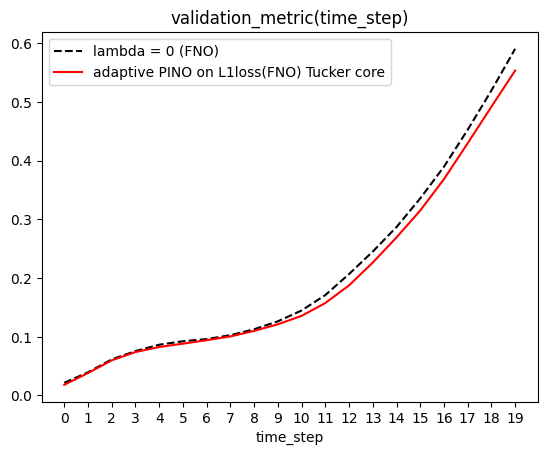

In [274]:
beginning_step = 0
end_step = 20
plt.xticks(np.arange(len(metric0[beginning_step:end_step])))
plt.plot(np.arange(len(metric0[beginning_step:end_step])), metric0.cpu().numpy()[beginning_step:end_step], label='lambda = 0 (FNO)', color='k', linestyle='dashed')
plt.plot(np.arange(len(metric[beginning_step:end_step])), metric.cpu().numpy()[beginning_step:end_step], label='adaptive PINO on L1loss(FNO) Tucker core', color='r')
plt.legend()
plt.title('validation_metric(time_step)')
plt.xlabel("time_step")

Нам удалось построить конструкцию, в которой расхождение физико-информированной модели и простого ФНО увеличивается с каждым временным шагом. Это хорошее логичное поведение.

In [266]:
downsample = True
N_sample = 1100
snapshot = 19 

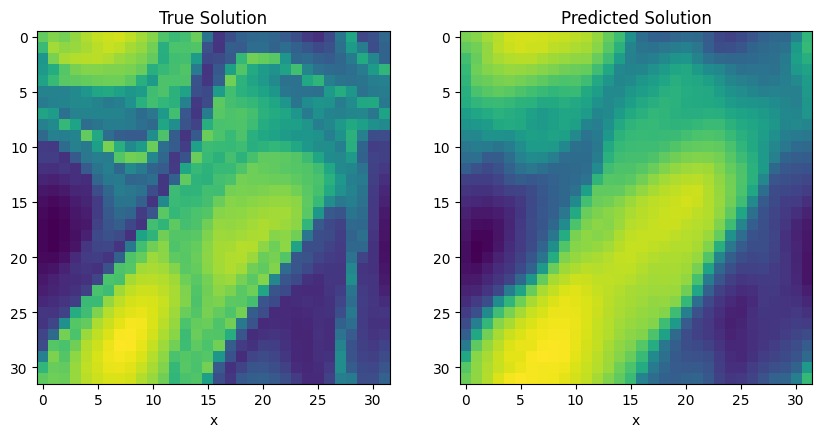

In [267]:
data_path='./NavierStokes_V1e-5_N1200_T20.mat'
reader = MatReader(data_path)
w = reader.read_field('u')
N_samples, GRID_SIZE, GRID_SIZE, TIME_STEPS = w.shape
if downsample:
    w = w.permute(0,3,1,2)
    GRID_SIZE = int(np.floor(GRID_SIZE/2))
    w = F.interpolate(w, size=(GRID_SIZE, GRID_SIZE), mode='bicubic', align_corners=False)
    w = w.permute(0,2,3,1)

with torch.no_grad():    
    w = reader.read_field('u')
    N_samples, GRID_SIZE, GRID_SIZE, TIME_STEPS = w.shape
    if downsample:
        w = w.permute(0,3,1,2)
        GRID_SIZE = int(np.floor(GRID_SIZE/2))
        w = F.interpolate(w, size=(GRID_SIZE, GRID_SIZE), mode='bicubic', align_corners=False)
        w = w.permute(0,2,3,1)
        N_samples, GRID_SIZE, GRID_SIZE, TIME_STEPS = w.shape
    x = torch.linspace(0, 1, GRID_SIZE)
    y = torch.linspace(0, 1, GRID_SIZE)
    t = torch.linspace(0, 1, TIME_STEPS)

    X_, Y_, T_ = torch.meshgrid(x, y, t, indexing='ij')

    X = X_.clone().unsqueeze(0).unsqueeze(1).to(device)
    Y = Y_.clone().unsqueeze(0).unsqueeze(1).to(device)
    T = T_.clone().unsqueeze(0).unsqueeze(1).to(device)
    
    input = torch.cat([X,Y,T], dim=1)

    input[0, 0, :, :, 0] = w[N_sample,:,:,0]
    input[0, 1, :, :, 0] = w[N_sample,:,:,0].T


    model.eval()
    output_ = model(input)
    
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title("True Solution")
plt.xlabel("x")
plt.imshow(w[N_sample,...][...,snapshot])
plt.subplot(1,2,2)
plt.title("Predicted Solution")
plt.xlabel("x")
plt.imshow(output_[...,snapshot].view(GRID_SIZE,GRID_SIZE).cpu())
plt.show()

In [ ]:
# torch.save(model, 'downsampled_naive_7_7_7_fl_4_mc_16_pc_32_ReLU_adaptive_TuckerL1-full_E_200_BS_1_251015.pth')

In [287]:
class PINO_adaptive_UNET2(FNO_new):
    def __init__(self, visc = 1e-5, unet_lifting_channels = 16,lamb_core_rank = 8, **kwargs):
        super().__init__(**kwargs)
        self.visc = visc
        self.unet_lifting_channels = unet_lifting_channels

        self._setup_d_filters()

        self.enc_conv1 = nn.Conv3d(2,int(self.unet_lifting_channels/2), kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool3d(2)
        self.enc_bn1 = nn.BatchNorm3d(num_features=int(self.unet_lifting_channels/2))
        
        self.enc_conv2 = nn.Conv3d(int(self.unet_lifting_channels/2),self.unet_lifting_channels, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool3d(2)
        self.enc_bn2 = nn.BatchNorm3d(num_features=self.unet_lifting_channels)

        self.bottelneck_conv = nn.Conv3d(self.unet_lifting_channels,self.unet_lifting_channels, kernel_size=1)

        self.upsample0 = nn.Upsample(scale_factor=2)
        self.dec_bn0 = nn.BatchNorm3d(num_features=self.unet_lifting_channels*2)
        self.dec_conv0 = nn.ConvTranspose3d(self.unet_lifting_channels*2,int(self.unet_lifting_channels/2),3, padding=1)
        
        self.upsample1 = nn.Upsample(scale_factor=2)
        self.dec_bn1 = nn.BatchNorm3d(num_features=self.unet_lifting_channels)
        self.dec_conv1 = nn.ConvTranspose3d(self.unet_lifting_channels, 1, 3, padding=1)


    def _setup_d_filters(self):
        
        dx_filter = (torch.tensor([[[[-1, 0, 1]]]]).float() / 2.0).contiguous().view(1, 1, 3, 1, 1)
        dy_filter = (torch.tensor([[[[-1, 0, 1]]]]).float() / 2.0).contiguous().view(1, 1, 1, 3, 1)
        dt_filter = (torch.tensor([[[[-1, 0, 1]]]]).float() / 2.0).contiguous().view(1, 1, 1, 1, 3)
        laplace_filter_3d = torch.zeros(1, 1, 3, 3, 3)
        laplace_filter_3d[0,0,:,:,1] = torch.tensor([[[[0, 1, 0],
                                                       [1,-4, 1],
                                                       [0, 1, 0]]]]
                                                    ).float().contiguous()


        self.register_buffer('dx_f', dx_filter)
        self.register_buffer('dy_f', dy_filter)
        self.register_buffer('dt_f', dt_filter)
        self.register_buffer('laplacian', laplace_filter_3d)
        

    def w_t(self, w, dt=1.0):

        w_t = F.conv3d(w, self.dt_f, padding=(0, 0, 0)) / dt

        # сделаем постпаддинг по t
        w_t = F.pad(w_t, (1,1, 0,0, 0,0), mode = 'replicate')  # 1,1 — t, 0,0 — y, 0,0 — x с конца

        return w_t
    
        

    def compute_derivatives_finite_diff(self, w):

            B, C, GRID_SIZE, GRID_SIZE, T = w.shape
            dx, dy = 1/(GRID_SIZE - 1), 1/(GRID_SIZE - 1)
            w_padded_x = F.pad(w, (0,0, 0,0, 1,1), mode = 'circular')  # 0,0 — t, 0,0 — y, 1,1 — x с конца
            w_padded_y = F.pad(w, (0,0, 1,1, 0,0), mode = 'circular')  # 0,0 — t, 1,1 — y, 0,0 — x с конца
            w_x = F.conv3d(w_padded_x, self.dx_f, padding=(0, 0, 0)) / dx
            w_y = F.conv3d(w_padded_y, self.dy_f, padding=(0, 0, 0)) / dy

            return w_x, w_y


    def compute_laplacian(self, w):
            
        B, C, GRID_SIZE, GRID_SIZE, T = w.shape
        dx, dy = 1/(GRID_SIZE - 1), 1/(GRID_SIZE - 1)
        w_padded = F.pad(w, (0,0, 1,1, 1,1), mode = 'circular')  # 0,0 — t, 0,0 — y, 1,1 — x с конца
        laplacian = F.conv3d(w_padded, self.laplacian, padding=(0,0,1)) / (dx*dy)
        
        return laplacian


    def physics_loss_fast(self, inputs, x, y, dt):  # Вычисляем физическое ограничение dw/dt + (v,grad(w)) - visc * laplasian(w) - f 
        
        f = 0.1*(torch.sin(2*torch.pi*(x + y)) + torch.cos(2*torch.pi*(x + y))) 

        w = inputs.unsqueeze(1)

        B, C, N, N, T = w.shape

        k_max = int(np.floor(N/2))

        F_w = torch.fft.rfft2(w, dim = (2,3), norm='ortho')

        k_y = torch.cat((torch.arange(start=0, end=k_max, step=1, device=w.device), torch.arange(start=-k_max, end=0, step=1, device=w.device)), 0).repeat(N,1)
        k_x = k_y.transpose(0,1)

        k_x = k_x[..., :k_max + 1].unsqueeze(-1).expand(-1, -1, T)
        k_y = k_y[..., :k_max + 1].unsqueeze(-1).expand(-1, -1, T)

        F_lap = 4 * (torch.pi**2) * (k_x**2 + k_y**2)
        F_lap[0,0] = 1.0 
        
        dealias = torch.logical_and(torch.abs(k_y) <= (3.0/5.0)*k_max, torch.abs(k_x) <= (3.0/5.0)*k_max).float().to(w.device)

        F_psi = (F_w/F_lap) * dealias

        psi = torch.fft.irfft2(F_psi, dim=(2,3), norm='ortho')

        psi_x, psi_y = self.compute_derivatives_finite_diff(psi)
        Vx = psi_y
        Vy = -psi_x

        w_x, w_y = self.compute_derivatives_finite_diff(w)
        w_t = self.w_t(w, dt=dt)

        laplacian_w = self.compute_laplacian(w)

        V_scalmul_grad_w = Vx * w_x + Vy * w_y

        residual = w_t + V_scalmul_grad_w - self.visc * laplacian_w - f

        return residual**2
    
    
    def forward(self, inputs):
        return super().forward(inputs)
    
    def loss(self, inputs, target, X, Y, dt=1):
        data_loss = nn.L1Loss(reduction='none')(inputs, target).unsqueeze(1).contiguous()
        physics_loss = self.physics_loss_fast(inputs=inputs, x=X, y=Y, dt=dt).contiguous()
        cat_loss = torch.cat((data_loss, physics_loss), dim=1)

        e1 = self.enc_bn1(self.pool1(F.relu(self.enc_conv1(cat_loss))))
        e2 = self.enc_bn2(self.pool2(F.relu(self.enc_conv2(e1))))

        b = self.bottelneck_conv(e2)

        d0 = self.dec_conv0(self.dec_bn0(F.relu(self.upsample0(torch.cat([b, e2], 1)))))
        lamb_tensor = self.dec_conv1(self.dec_bn1(F.relu(self.upsample1(torch.cat([d0, e1], 1)))))
        lamb_tensor = torch.sigmoid(lamb_tensor).contiguous()
        
        return torch.mean((torch.Tensor([1]).to(inputs.device) - lamb_tensor) * data_loss + lamb_tensor * physics_loss), lamb_tensor, data_loss.mean(), physics_loss.mean()

In [ ]:
device = 'cpu'
model = PINO_adaptive_UNET2(modes = [7,7,7], 
                            num_fourier_layers=4, 
                            in_channels=3, 
                            mid_channels=16, 
                            projection_channels=32, 
                            out_channels=1, 
                            activation=nn.ReLU(),
                            calc_finite = True,
                            visc=1e-5,  
                            ).to(device)

Adam = torch.optim.AdamW(model.parameters(), lr=1e-4)

model_PINO, loss_hist, validation_metric_hist, lambda_tensor, data_loss_hist, pino_loss_hist = train_FNO_advanced(model=model, 
                                                                                                                optimizer=Adam,
                                                                                                                EPOCHS=200, 
                                                                                                                BATCH_SIZE=4, 
                                                                                                                downsample=True, 
                                                                                                                device='cpu')

Данная модель вообще не обучалась. Все чем она занималась — это "подгонкой" всей системы под минимизацию суммы лоссов с учетом коэффициентов.

Пришло время взять адаптивное такер-ПИНО и обучить его на полной сетке и в полноценной модели

In [ ]:
# основной класс модели — медленной но с самым крепким результатом
class PINO_adaptive_tucker(FNO_new):
    def __init__(self, visc = 1e-5, lamb_core_rank = 16, **kwargs):
        super().__init__(**kwargs)
        self.visc = visc
        self.lamb_core_rank = lamb_core_rank 
        self.tucker_core_scaling_factor = 2e-2
        self.batch_size = None
        self.GRID_SIZE = None
        self.TIME_STEPS = None
        self.lamb_factors = None
        self.dim_p = None

        self._setup_d_filters()

    def _setup_d_filters(self):
        
        dx_filter = (torch.tensor([[[[-1, 0, 1]]]]).float() / 2.0).contiguous().view(1, 1, 3, 1, 1)
        dy_filter = (torch.tensor([[[[-1, 0, 1]]]]).float() / 2.0).contiguous().view(1, 1, 1, 3, 1)
        dt_filter = (torch.tensor([[[[-1, 0, 1]]]]).float() / 2.0).contiguous().view(1, 1, 1, 1, 3)
        laplace_filter_3d = torch.zeros(1, 1, 3, 3, 3)
        laplace_filter_3d[0,0,:,:,1] = torch.tensor([[[[0, 1, 0],
                                                       [1,-4, 1],
                                                       [0, 1, 0]]]]
                                                    ).float().contiguous()


        self.register_buffer('dx_f', dx_filter)
        self.register_buffer('dy_f', dy_filter)
        self.register_buffer('dt_f', dt_filter)
        self.register_buffer('laplacian', laplace_filter_3d)
        

    def w_t(self, w, dt=1.0):

        w_t = F.conv3d(w, self.dt_f, padding=(0, 0, 0)) / dt

        # сделаем постпаддинг по t
        w_t = F.pad(w_t, (1,1, 0,0, 0,0), mode = 'replicate')  # 1,1 — t, 0,0 — y, 0,0 — x с конца

        return w_t
    
        

    def compute_derivatives_finite_diff(self, w):

            B, C, GRID_SIZE, GRID_SIZE, T = w.shape
            dx, dy = 1/(GRID_SIZE - 1), 1/(GRID_SIZE - 1)
            w_padded_x = F.pad(w, (0,0, 0,0, 1,1), mode = 'circular')  # 0,0 — t, 0,0 — y, 1,1 — x с конца
            w_padded_y = F.pad(w, (0,0, 1,1, 0,0), mode = 'circular')  # 0,0 — t, 1,1 — y, 0,0 — x с конца
            w_x = F.conv3d(w_padded_x, self.dx_f, padding=(0, 0, 0)) / dx
            w_y = F.conv3d(w_padded_y, self.dy_f, padding=(0, 0, 0)) / dy

            return w_x, w_y


    def compute_laplacian(self, w):
            
        B, C, GRID_SIZE, GRID_SIZE, T = w.shape
        dx, dy = 1/(GRID_SIZE - 1), 1/(GRID_SIZE - 1)
        w_padded = F.pad(w, (0,0, 1,1, 1,1), mode = 'circular')  # 0,0 — t, 0,0 — y, 1,1 — x с конца
        laplacian = F.conv3d(w_padded, self.laplacian, padding=(0,0,1)) / (dx*dy)
        
        return laplacian


    def physics_loss_fast(self, inputs, x, y, dt):  # Вычисляем физическое ограничение dw/dt + (v,grad(w)) - visc * laplasian(w) - f 
        
        f = 0.1*(torch.sin(2*torch.pi*(x + y)) + torch.cos(2*torch.pi*(x + y))) 

        w = inputs.unsqueeze(1)

        B, C, N, N, T = w.shape

        k_max = int(np.floor(N/2))

        F_w = torch.fft.rfft2(w, dim = (2,3), norm='ortho')

        k_y = torch.cat((torch.arange(start=0, end=k_max, step=1, device=w.device), torch.arange(start=-k_max, end=0, step=1, device=w.device)), 0).repeat(N,1)
        k_x = k_y.transpose(0,1)

        k_x = k_x[..., :k_max + 1].unsqueeze(-1).expand(-1, -1, T)
        k_y = k_y[..., :k_max + 1].unsqueeze(-1).expand(-1, -1, T)

        F_lap = 4 * (torch.pi**2) * (k_x**2 + k_y**2)
        F_lap[0,0] = 1.0 
        
        dealias = torch.logical_and(torch.abs(k_y) <= (3.0/5.0)*k_max, torch.abs(k_x) <= (3.0/5.0)*k_max).float().to(w.device)

        F_psi = (F_w/F_lap) * dealias

        psi = torch.fft.irfft2(F_psi, dim=(2,3), norm='ortho')

        psi_x, psi_y = self.compute_derivatives_finite_diff(psi)
        Vx = psi_y
        Vy = -psi_x

        w_x, w_y = self.compute_derivatives_finite_diff(w)
        w_t = self.w_t(w, dt=dt)

        laplacian_w = self.compute_laplacian(w)

        V_scalmul_grad_w = Vx * w_x + Vy * w_y

        residual = w_t + V_scalmul_grad_w - self.visc * laplacian_w - f

        return residual**2
    
    
    def forward(self, inputs):
        if self.batch_size is None:
            self.batch_size, _, self.GRID_SIZE, _, self.TIME_STEPS = inputs.shape
            self.dim_p = len(inputs.shape)
        if self.lamb_factors is None:
            lamb_tensor_shape = (self.GRID_SIZE, self.GRID_SIZE, self.TIME_STEPS)
            lamb_tensor = nn.init.xavier_uniform_(torch.empty(lamb_tensor_shape, dtype=torch.float32, device=inputs.device)).contiguous() # первичная инициализация. размеры будут назначены при первом прогоне forward
            _, lamb_factors = tucker(lamb_tensor, rank = [self.lamb_core_rank] * (self.dim_p - 1)) # раскладываем lambda_tensor на ядро (не нужное) и обучаемые факторы
            self.lamb_factors = nn.ParameterList([nn.Parameter(factor).contiguous() for factor in lamb_factors]) # регистрируем факторы как обучаемые тензоры модели
        return super().forward(inputs)
    
    def loss(self, inputs, target, X, Y, dt=1):
        data_loss = nn.L1Loss(reduction='none')(inputs, target).contiguous() # вычисляем полный тензор ошибок [batch, grid, grid, steps]
        physics_loss = self.physics_loss_fast(inputs=inputs, x=X, y=Y, dt=dt).squeeze(1).contiguous()
        
        errors_tensor = data_loss.mean(dim=0) # усреднение по батчу
        errors_core, _ = tucker(errors_tensor.detach(), rank = [self.lamb_core_rank] * (self.dim_p-1))     # раскладываем ошибки в разложение Такера. Из него нам понадобится только ядро
        errors_core = errors_core.contiguous() * self.tucker_core_scaling_factor                           # скейлинг фактор нужен для того чтобы не было значений более 1 в итоговом тензоре и для устойчивости обучения
        lamb_tensor = tl.tucker_to_tensor((errors_core, [factor for factor in self.lamb_factors])).contiguous() # берем ядро разложения mse, обучаемые факторы разложения lambda_tensor и собираем из них lambda_tensor
        
        one_minus_lambda = (torch.Tensor([1]).to(device) - lamb_tensor).contiguous()
        lamda_on_PINO_loss = torch.einsum('xyt,bxyt->bxyt', lamb_tensor, physics_loss).contiguous()
        one_minus_lambda_on_data_loss = torch.einsum('xyt,bxyt->bxyt', one_minus_lambda, data_loss).contiguous()
        
        return torch.mean(one_minus_lambda_on_data_loss + lamda_on_PINO_loss), lamb_tensor, data_loss.mean(), physics_loss.mean()

In [9]:
device = 'mps'
model = PINO_adaptive_tucker(modes = [12,12,12], 
                            num_fourier_layers=8, 
                            in_channels=3, 
                            mid_channels=32, 
                            projection_channels=64, 
                            out_channels=1, 
                            activation=nn.ReLU(),
                            calc_finite = True,
                            visc=1e-5,  
                            ).to(device)

Adam = torch.optim.AdamW(model.parameters(), lr=1e-4)

scheduler = torch.optim.lr_scheduler.StepLR(Adam, step_size=100, gamma=0.5)

model_PINO, loss_hist, validation_metric_hist, lambda_tensor, data_loss_hist, pino_loss_hist = train_FNO_advanced(model=model, 
                                                                                                                optimizer=Adam,
                                                                                                                scheduler=scheduler,
                                                                                                                EPOCHS=200, 
                                                                                                                BATCH_SIZE=1, 
                                                                                                                downsample=False, 
                                                                                                                device='mps')

 25%|██▌       | 50/200 [8:02:18<24:01:17, 576.51s/it]

Epoch 50, loss: 0.2171, validation metric: 0.1784


 50%|█████     | 100/200 [16:02:27<15:57:43, 574.63s/it]

Epoch 100, loss: 0.1842, validation metric: 0.1584


 75%|███████▌  | 150/200 [24:03:45<8:00:14, 576.29s/it] 

Epoch 150, loss: 0.1656, validation metric: 0.1503


100%|██████████| 200/200 [32:06:33<00:00, 577.97s/it]  

Epoch 200, loss: 0.1544, validation metric: 0.1460


In [ ]:
# torch.save(model, 'naive_12_12_12_fl_8_mc_32_pc_64_ReLU_adaptive_TuckerL1-full-scaling_1e-2_E_200_BS_1_251017.pth')

In [11]:
print('Среднее: ', lambda_tensor.mean().item(),' min:', lambda_tensor.min().item(),' max:', lambda_tensor.max().item(),' стандартное отклонение:', lambda_tensor.std().item(),' дисперсия:', lambda_tensor.var().item())

Среднее:  -1.9789295038208365e-06  min: -0.011055652983486652  max: 0.011093328706920147  стандартное отклонение: 0.0012594099389389157  дисперсия: 1.5861135125305736e-06


Любопытное наблюдение: здесь и среднее и макс/мин отличаются в меньшую сторону от "малой" модели практически ровно вдвое.

Text(0.5, 0, 'epoch')

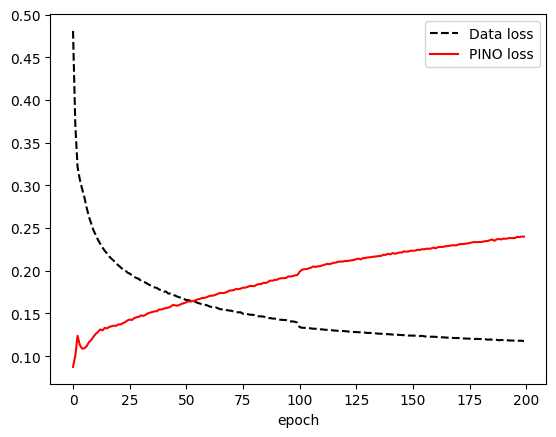

In [12]:
batch_size = 1024
data_batches = np.array_split(np.array(data_loss_hist), np.ceil(len(np.array(data_loss_hist)) / batch_size))
data_averages = [batch.mean() for batch in data_batches]
pino_batches = np.array_split(np.array(pino_loss_hist), np.ceil(len(np.array(pino_loss_hist)) / batch_size))
pino_averages = [batch.mean() for batch in pino_batches]
plt.plot(np.arange(len(data_averages)), data_averages, label='Data loss', color='k', linestyle='dashed')
plt.plot(np.arange(len(pino_averages)), pino_averages, label='PINO loss', color='r')
plt.legend()
plt.xlabel("epoch")

Любопытно, что в маленькой модели 32х32 рост ПИНО-лосса был явно ассимптотический. А здесь — похоже, неограниченный.

In [17]:
data_path = './NavierStokes_V1e-5_N1200_T20.mat'
reader = MatReader(data_path)
w = reader.read_field('u')
N_samples, GRID_SIZE, GRID_SIZE, TIME_STEPS = w.shape
w = w[1024:N_samples,...]
N_samples, GRID_SIZE, GRID_SIZE, TIME_STEPS = w.shape
w = w.to(device)

x = torch.linspace(0, 1, GRID_SIZE)
y = torch.linspace(0, 1, GRID_SIZE)
t = torch.linspace(0, 1, TIME_STEPS)

X_, Y_, T_ = torch.meshgrid(x, y, t, indexing='ij')

X = torch.cat(N_samples * [X_.clone().unsqueeze(0)]).unsqueeze(1)
Y = torch.cat(N_samples * [Y_.clone().unsqueeze(0)]).unsqueeze(1)
T = torch.cat(N_samples * [T_.clone().unsqueeze(0)]).unsqueeze(1)

input = torch.cat([X,Y,T], dim=1)

input[ :, 0, :, :, 0] = w[...,0]
input[ :, 1, :, :, 0] = w[...,0].transpose(1,2)
input = input.to(device)

model0 = torch.load('./old models/naive_12_12_12_fl_8_lift_None_mc_32_pc_64_ReLU_lamb_00_E_200_BS_1_250804.pth', weights_only=False).to(device)

model0.eval()
model.eval()
with torch.no_grad():
    outputs0 = model0(input).squeeze(1)
    outputs = model(input).squeeze(1)

metric0 = torch.sqrt((outputs0-w)**2).mean(dim=(0,1,2))
metric = torch.sqrt((outputs-w)**2).mean(dim=(0,1,2))

Text(0.5, 0, 'time_step')

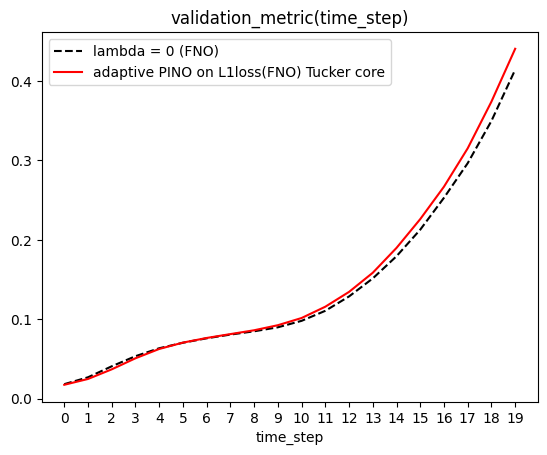

In [18]:
beginning_step = 0
end_step = 20
plt.xticks(np.arange(len(metric0[beginning_step:end_step])))
plt.plot(np.arange(len(metric0[beginning_step:end_step])), metric0.cpu().numpy()[beginning_step:end_step], label='lambda = 0 (FNO)', color='k', linestyle='dashed')
plt.plot(np.arange(len(metric[beginning_step:end_step])), metric.cpu().numpy()[beginning_step:end_step], label='adaptive PINO on L1loss(FNO) Tucker core', color='r')
plt.legend()
plt.title('validation_metric(time_step)')
plt.xlabel("time_step")

Text(0.5, 0, 'time_step')

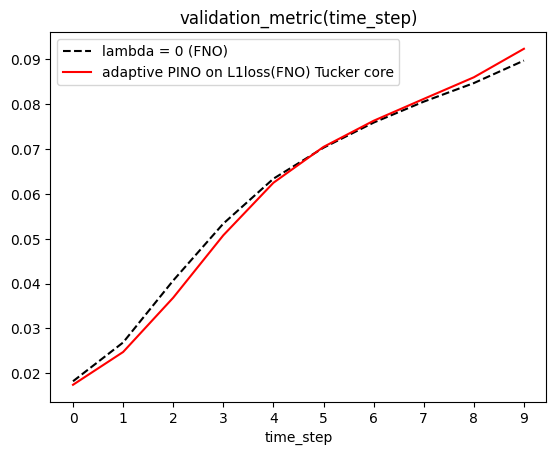

In [70]:
beginning_step = 0
end_step = 10
plt.xticks(np.arange(len(metric0[beginning_step:end_step])))
plt.plot(np.arange(len(metric0[beginning_step:end_step])), metric0.cpu().numpy()[beginning_step:end_step], label='lambda = 0 (FNO)', color='k', linestyle='dashed')
plt.plot(np.arange(len(metric[beginning_step:end_step])), metric.cpu().numpy()[beginning_step:end_step], label='adaptive PINO on L1loss(FNO) Tucker core', color='r')
plt.legend()
plt.title('validation_metric(time_step)')
plt.xlabel("time_step")

* На большой модели (8 слоев и большой подъем) ПИНО уже проигрывает ФНО
* ПИНО имеет небольшое преимущество только на ранних шагах по времени

In [66]:
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

def plot_time_slices_simple(data):
    data = data.detach().clone().cpu().numpy()
    
    fig, axes = plt.subplots(4, 5, figsize=(16, 12))
    axes_flat = axes.flatten()
    
    vmin = np.min(data)
    vmax = np.max(data)
    
    font = FontProperties()
    font.set_size(10)
    font.set_weight('normal')  # Можно добавить жирность
    font.set_family('sans')  # Можно изменить семейство шрифтов

    # Рисуем все изображения
    for i in range(20):
        im = axes_flat[i].imshow(data[:, :, i], 
                                cmap='inferno', 
                                vmin=vmin, 
                                vmax=vmax,
                                origin='lower')
        axes_flat[i].set_title(f'T_step {i}', fontproperties=font)
        axes_flat[i].axis('off')
    
    # Оставляем много места снизу и добавляем цветовую шкалу
    plt.subplots_adjust(bottom=0.12, top=0.95, left=0.05, right=0.95, 
                       wspace=0.2, hspace=0.3)
    
    # Создаем отдельную ось для цветовой шкалы внизу
    cbar_ax = fig.add_axes([0.2, 0.05, 0.6, 0.02])  # [left, bottom, width, height]
    cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal')
    
    plt.show()


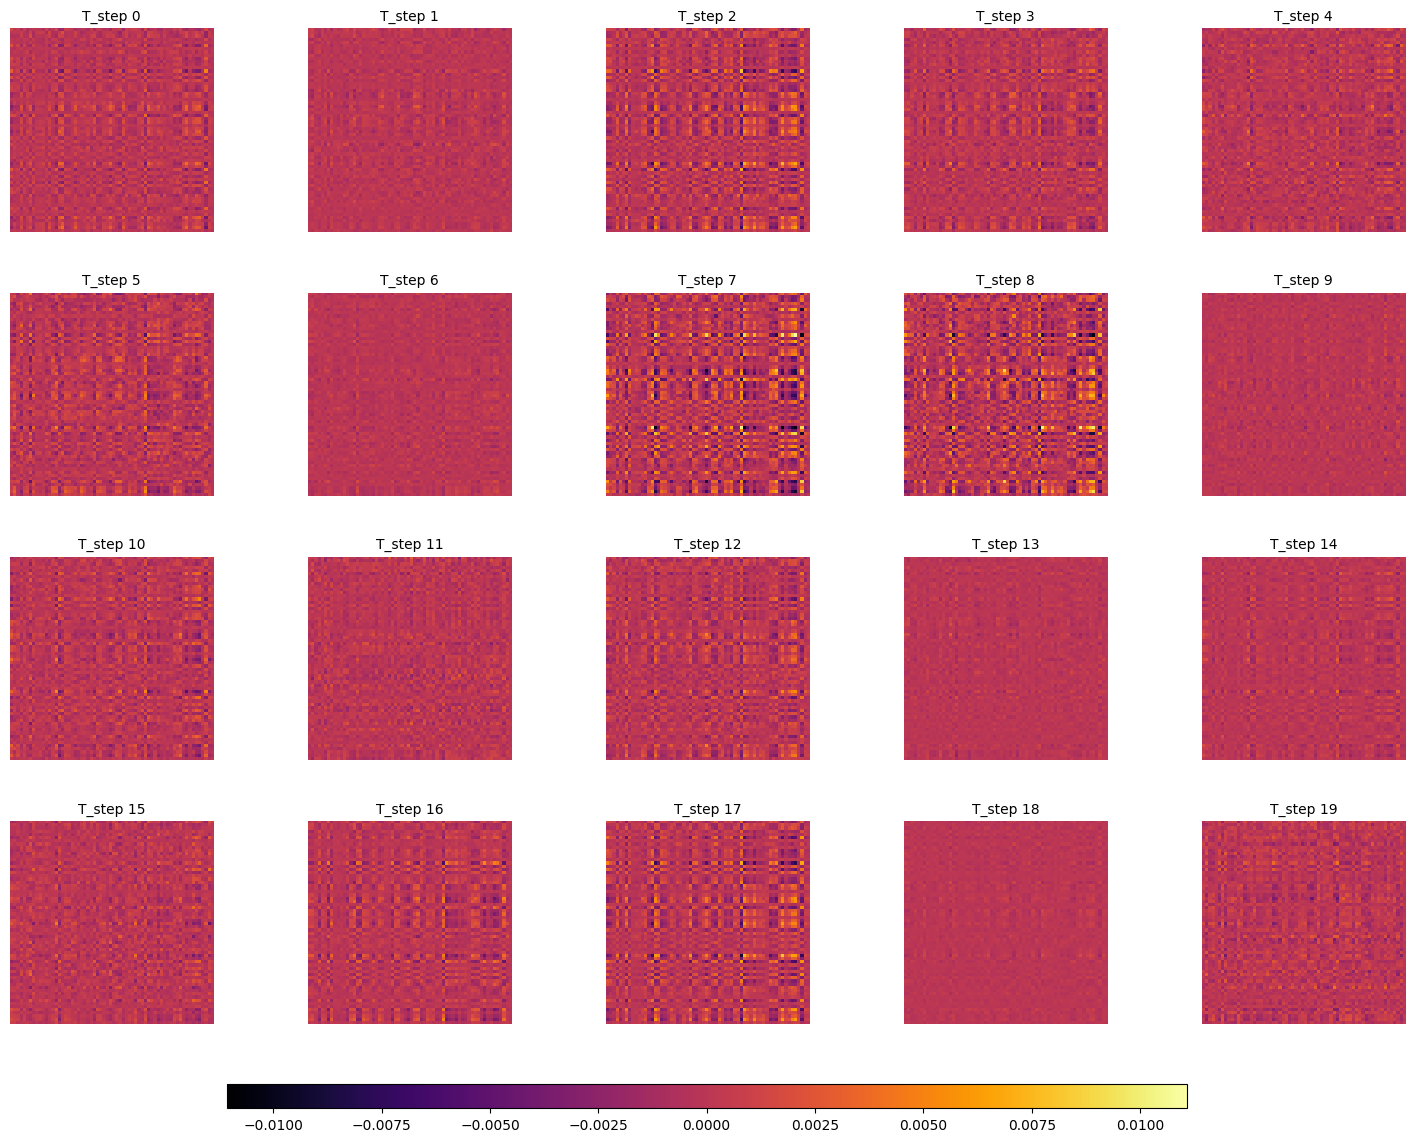

In [67]:
plot_time_slices_simple(lambda_tensor)

**ЗАМЧАНИЕ ПОСТФАКТУМ (ПОСЛЕ ВСЕХ ЗАПУСКОВ И ПРОВЕРОК)**
Очень хорошо по среднему и макс/мин значениям, что модель искала как бы ей занулить тензор лямбда. И она придумала как это сделать через обучаемые факторы: черезстрочно домножая ядро до на положительные то на отрицательные почти равные по модулю числа. В среднем получается 0, но кроме того за счет небольшого аддитивного воздействия возможно где-то сгладить функцию потерь.

Есть гипотеза, что модели не хватило диапазона для уменьшения параметров. Поэтому я решил поменять скейлинг фактор:
* Уменьшение в 10 раз положительного результата не дало
* Увеличение в 10 раз ожидаемо привело к расхождению модели
* Уменьшение вдвое привело к ухудшению метрик
* Увеличение вдвое (до 2е-2) привело к незначительному улучшению метрик

In [110]:
device = 'mps'
model = PINO_adaptive_tucker(modes = [12,12,12], 
                            num_fourier_layers=8, 
                            in_channels=3, 
                            mid_channels=32, 
                            projection_channels=64, 
                            out_channels=1, 
                            activation=nn.ReLU(),
                            calc_finite = True,
                            visc=1e-5,  
                            ).to(device)

Adam = torch.optim.AdamW(model.parameters(), lr=1e-4)

scheduler = torch.optim.lr_scheduler.StepLR(Adam, step_size=100, gamma=0.5)

model_PINO, loss_hist, validation_metric_hist, lambda_tensor, data_loss_hist, pino_loss_hist = train_FNO_advanced(model=model, 
                                                                                                                optimizer=Adam,
                                                                                                                scheduler=scheduler,
                                                                                                                EPOCHS=200, 
                                                                                                                BATCH_SIZE=1, 
                                                                                                                downsample=False, 
                                                                                                                device='mps')

 25%|██▌       | 50/200 [8:05:56<24:18:27, 583.38s/it]

Epoch 50, loss: 0.2138, validation metric: 0.1746


 50%|█████     | 100/200 [16:10:46<16:13:52, 584.32s/it]

Epoch 100, loss: 0.1808, validation metric: 0.1538


 75%|███████▌  | 150/200 [24:21:03<8:18:18, 597.97s/it] 

Epoch 150, loss: 0.1624, validation metric: 0.1470


100%|██████████| 200/200 [32:30:08<00:00, 585.04s/it]  

Epoch 200, loss: 0.1514, validation metric: 0.1430


In [ ]:
# torch.save(model, 'naive_12_12_12_fl_8_mc_32_pc_64_ReLU_adaptive_TuckerL1-full-scaling_2e-2_E_200_BS_1_251017.pth')

In [112]:
print('Среднее: ', lambda_tensor.mean().item(),' min:', lambda_tensor.min().item(),' max:', lambda_tensor.max().item(),' стандартное отклонение:', lambda_tensor.std().item(),' дисперсия:', lambda_tensor.var().item())

Среднее:  -1.671408313086431e-06  min: -0.029366495087742805  max: 0.025907037779688835  стандартное отклонение: 0.002669208450242877  дисперсия: 7.124673174985219e-06


Text(0.5, 0, 'epoch')

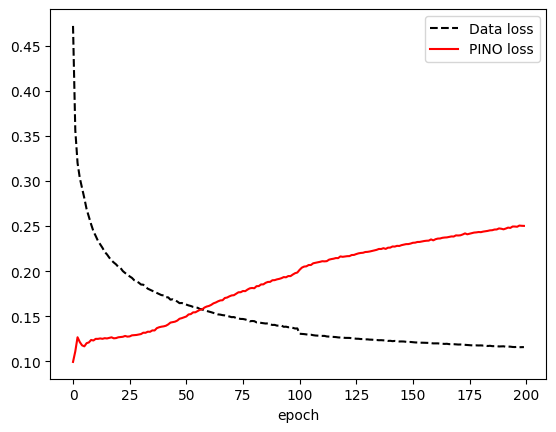

In [113]:
batch_size = 1024
data_batches = np.array_split(np.array(data_loss_hist), np.ceil(len(np.array(data_loss_hist)) / batch_size))
data_averages = [batch.mean() for batch in data_batches]
pino_batches = np.array_split(np.array(pino_loss_hist), np.ceil(len(np.array(pino_loss_hist)) / batch_size))
pino_averages = [batch.mean() for batch in pino_batches]
plt.plot(np.arange(len(data_averages)), data_averages, label='Data loss', color='k', linestyle='dashed')
plt.plot(np.arange(len(pino_averages)), pino_averages, label='PINO loss', color='r')
plt.legend()
plt.xlabel("epoch")

In [117]:
data_path = './NavierStokes_V1e-5_N1200_T20.mat'
reader = MatReader(data_path)
w = reader.read_field('u')
N_samples, GRID_SIZE, GRID_SIZE, TIME_STEPS = w.shape
w = w[1024:N_samples,...]
N_samples, GRID_SIZE, GRID_SIZE, TIME_STEPS = w.shape
w = w.to(device)

x = torch.linspace(0, 1, GRID_SIZE)
y = torch.linspace(0, 1, GRID_SIZE)
t = torch.linspace(0, 1, TIME_STEPS)

X_, Y_, T_ = torch.meshgrid(x, y, t, indexing='ij')

X = torch.cat(N_samples * [X_.clone().unsqueeze(0)]).unsqueeze(1)
Y = torch.cat(N_samples * [Y_.clone().unsqueeze(0)]).unsqueeze(1)
T = torch.cat(N_samples * [T_.clone().unsqueeze(0)]).unsqueeze(1)

input = torch.cat([X,Y,T], dim=1)

input[ :, 0, :, :, 0] = w[...,0]
input[ :, 1, :, :, 0] = w[...,0].transpose(1,2)
input = input.to(device)

model0 = torch.load('./old models/naive_12_12_12_fl_8_lift_None_mc_32_pc_64_ReLU_lamb_00_E_200_BS_1_250804.pth', weights_only=False).to(device)

model0.eval()
model.eval()
with torch.no_grad():
    outputs0 = model0(input).squeeze(1)
    outputs = model(input).squeeze(1)

metric0 = torch.sqrt((outputs0-w)**2).mean(dim=(0,1,2))
metric = torch.sqrt((outputs-w)**2).mean(dim=(0,1,2))

Text(0.5, 0, 'time_step')

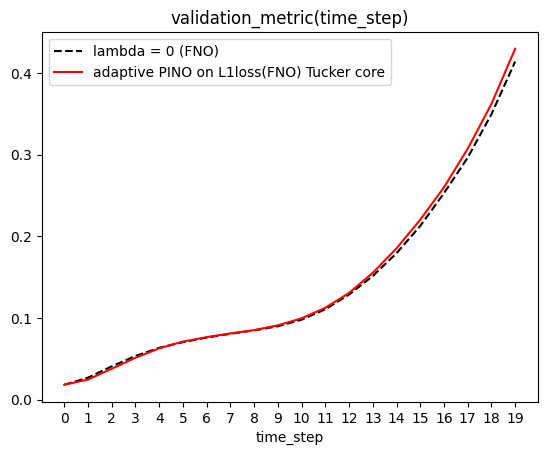

In [118]:
beginning_step = 0
end_step = 20
plt.xticks(np.arange(len(metric0[beginning_step:end_step])))
plt.plot(np.arange(len(metric0[beginning_step:end_step])), metric0.cpu().numpy()[beginning_step:end_step], label='lambda = 0 (FNO)', color='k', linestyle='dashed')
plt.plot(np.arange(len(metric[beginning_step:end_step])), metric.cpu().numpy()[beginning_step:end_step], label='adaptive PINO on L1loss(FNO) Tucker core', color='r')
plt.legend()
plt.title('validation_metric(time_step)')
plt.xlabel("time_step")

Text(0.5, 0, 'time_step')

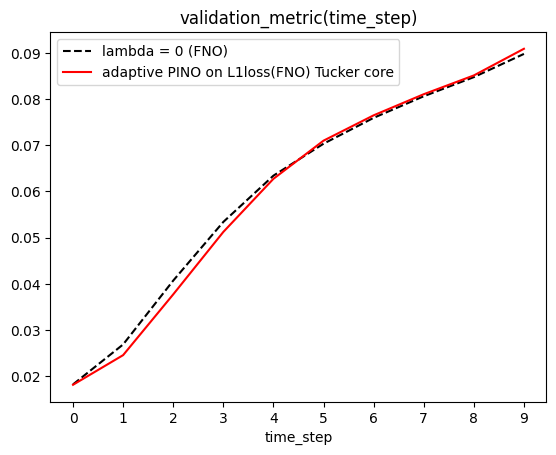

In [119]:
beginning_step = 0
end_step = 10
plt.xticks(np.arange(len(metric0[beginning_step:end_step])))
plt.plot(np.arange(len(metric0[beginning_step:end_step])), metric0.cpu().numpy()[beginning_step:end_step], label='lambda = 0 (FNO)', color='k', linestyle='dashed')
plt.plot(np.arange(len(metric[beginning_step:end_step])), metric.cpu().numpy()[beginning_step:end_step], label='adaptive PINO on L1loss(FNO) Tucker core', color='r')
plt.legend()
plt.title('validation_metric(time_step)')
plt.xlabel("time_step")

Неплохо бы попробовать и другие алгоритмы формирования тензора лямбда. Например:
* Формировать ядро из суммы тензоров ошибок (дата+физика)
* Делать обучаемым ядро, а факторы брать из тензоров ошибок
* Придумать как микшировать тензоры ошибок, чтобы формирование лямбда было более логичным
* При это пока не понятно, как гарантировать, чтобы модель не занулила лямбду

Множество небольших экспериментов на "игрушечных" примерах было проделано в отеднльном файле (small_tests). Основной вывод:
* Лучшие результаты показывает лямбда с ядром от ПИНО-лосс с небольшим дескейлингом
* Второе место у оператора с полностью обучаемой лямбдой (и ядро и факторы обучаются)
* Оба варианта все равно не дотягивают до результатов чистого ФНО, при том обучаются вдвое дольше

Проверим на большой модели

In [116]:
# определим недостающие классы операторов PINO
class PINO_fully_adaptive_tucker(FNO_new):
    def __init__(self, visc = 1e-5, lamb_core_rank = 16, **kwargs):
        super().__init__(**kwargs)
        self.visc = visc
        self.lamb_core_rank = lamb_core_rank 
        self.batch_size = None
        self.GRID_SIZE = None
        self.TIME_STEPS = None
        self.lamb_core = None
        self.lamb_factors = None
        self.dim_p = None

        self._setup_d_filters()

    def _setup_d_filters(self):
        
        dx_filter = (torch.tensor([[[[-1, 0, 1]]]]).float() / 2.0).contiguous().view(1, 1, 3, 1, 1)
        dy_filter = (torch.tensor([[[[-1, 0, 1]]]]).float() / 2.0).contiguous().view(1, 1, 1, 3, 1)
        dt_filter = (torch.tensor([[[[-1, 0, 1]]]]).float() / 2.0).contiguous().view(1, 1, 1, 1, 3)
        laplace_filter_3d = torch.zeros(1, 1, 3, 3, 3)
        laplace_filter_3d[0,0,:,:,1] = torch.tensor([[[[0, 1, 0],
                                                       [1,-4, 1],
                                                       [0, 1, 0]]]]
                                                    ).float().contiguous()


        self.register_buffer('dx_f', dx_filter)
        self.register_buffer('dy_f', dy_filter)
        self.register_buffer('dt_f', dt_filter)
        self.register_buffer('laplacian', laplace_filter_3d)
        

    def w_t(self, w, dt=1.0):

        w_t = F.conv3d(w, self.dt_f, padding=(0, 0, 0)) / dt

        # сделаем постпаддинг по t
        w_t = F.pad(w_t, (1,1, 0,0, 0,0), mode = 'replicate')  # 1,1 — t, 0,0 — y, 0,0 — x с конца

        return w_t
    
        

    def compute_derivatives_finite_diff(self, w):

            B, C, GRID_SIZE, GRID_SIZE, T = w.shape
            dx, dy = 1/(GRID_SIZE - 1), 1/(GRID_SIZE - 1)
            w_padded_x = F.pad(w, (0,0, 0,0, 1,1), mode = 'circular')  # 0,0 — t, 0,0 — y, 1,1 — x с конца
            w_padded_y = F.pad(w, (0,0, 1,1, 0,0), mode = 'circular')  # 0,0 — t, 1,1 — y, 0,0 — x с конца
            w_x = F.conv3d(w_padded_x, self.dx_f, padding=(0, 0, 0)) / dx
            w_y = F.conv3d(w_padded_y, self.dy_f, padding=(0, 0, 0)) / dy

            return w_x, w_y


    def compute_laplacian(self, w):
            
        B, C, GRID_SIZE, GRID_SIZE, T = w.shape
        dx, dy = 1/(GRID_SIZE - 1), 1/(GRID_SIZE - 1)
        w_padded = F.pad(w, (0,0, 1,1, 1,1), mode = 'circular')  # 0,0 — t, 0,0 — y, 1,1 — x с конца
        laplacian = F.conv3d(w_padded, self.laplacian, padding=(0,0,1)) / (dx*dy)
        
        return laplacian


    def physics_loss_fast(self, inputs, x, y, dt):  # Вычисляем физическое ограничение dw/dt + (v,grad(w)) - visc * laplasian(w) - f 
        
        f = 0.1*(torch.sin(2*torch.pi*(x + y)) + torch.cos(2*torch.pi*(x + y))) 

        w = inputs.unsqueeze(1)

        B, C, N, N, T = w.shape

        k_max = int(np.floor(N/2))

        F_w = torch.fft.rfft2(w, dim = (2,3), norm='ortho')

        k_y = torch.cat((torch.arange(start=0, end=k_max, step=1, device=w.device), torch.arange(start=-k_max, end=0, step=1, device=w.device)), 0).repeat(N,1)
        k_x = k_y.transpose(0,1)

        k_x = k_x[..., :k_max + 1].unsqueeze(-1).expand(-1, -1, T)
        k_y = k_y[..., :k_max + 1].unsqueeze(-1).expand(-1, -1, T)

        F_lap = 4 * (torch.pi**2) * (k_x**2 + k_y**2)
        F_lap[0,0] = 1.0 
        
        dealias = torch.logical_and(torch.abs(k_y) <= (3.0/5.0)*k_max, torch.abs(k_x) <= (3.0/5.0)*k_max).float().to(w.device)

        F_psi = (F_w/F_lap) * dealias

        psi = torch.fft.irfft2(F_psi, dim=(2,3), norm='ortho')

        psi_x, psi_y = self.compute_derivatives_finite_diff(psi)
        Vx = psi_y
        Vy = -psi_x

        w_x, w_y = self.compute_derivatives_finite_diff(w)
        w_t = self.w_t(w, dt=dt)

        laplacian_w = self.compute_laplacian(w)

        V_scalmul_grad_w = Vx * w_x + Vy * w_y

        residual = w_t + V_scalmul_grad_w - self.visc * laplacian_w - f

        return residual**2
    
    
    def forward(self, inputs):
        if self.batch_size is None:
            self.batch_size, _, self.GRID_SIZE, _, self.TIME_STEPS = inputs.shape
            self.dim_p = len(inputs.shape)
        if self.lamb_core is None:
            lamb_tensor_shape = (self.GRID_SIZE, self.GRID_SIZE, self.TIME_STEPS)
            lamb_tensor = nn.init.xavier_uniform_(torch.empty(lamb_tensor_shape, dtype=torch.float32, device=inputs.device)).contiguous()
            lamb_core, lamb_factors = tucker(lamb_tensor, rank = [self.lamb_core_rank] * (self.dim_p - 1))
            self.lamb_core = nn.Parameter(lamb_core.contiguous())
            self.lamb_factors = nn.ParameterList([nn.Parameter(factor).contiguous() for factor in lamb_factors])
        return super().forward(inputs)
    
    def loss(self, inputs, target, X, Y, dt=1):
        data_loss = nn.L1Loss(reduction='none')(inputs, target).contiguous()
        physics_loss = self.physics_loss_fast(inputs=inputs, x=X, y=Y, dt=dt).squeeze(1).contiguous()
        
        lamb_tensor = tl.tucker_to_tensor((self.lamb_core, [factor * 0.1 for factor in self.lamb_factors])).contiguous()
        
        one_minus_lambda = (torch.Tensor([1]).to(device) - lamb_tensor).contiguous()
        lamda_on_PINO_loss = torch.einsum('xyt,bxyt->bxyt', lamb_tensor, physics_loss).contiguous()
        one_minus_lambda_on_data_loss = torch.einsum('xyt,bxyt->bxyt', one_minus_lambda, data_loss).contiguous()
        
        return torch.mean(one_minus_lambda_on_data_loss + lamda_on_PINO_loss), lamb_tensor, data_loss.mean(), physics_loss.mean()
    
class PINO_adaptive_tucker_PINO_core(FNO_new):
    def __init__(self, visc = 1e-5, lamb_core_rank = 8, **kwargs):
        super().__init__(**kwargs)
        self.visc = visc
        self.lamb_core_rank = lamb_core_rank 
        self.tucker_core_scaling_factor = 1e-2
        self.batch_size = None
        self.GRID_SIZE = None
        self.TIME_STEPS = None
        self.lamb_factors = None
        self.dim_p = None

        self._setup_d_filters()

    def _setup_d_filters(self):
        
        dx_filter = (torch.tensor([[[[-1, 0, 1]]]]).float() / 2.0).contiguous().view(1, 1, 3, 1, 1)
        dy_filter = (torch.tensor([[[[-1, 0, 1]]]]).float() / 2.0).contiguous().view(1, 1, 1, 3, 1)
        dt_filter = (torch.tensor([[[[-1, 0, 1]]]]).float() / 2.0).contiguous().view(1, 1, 1, 1, 3)
        laplace_filter_3d = torch.zeros(1, 1, 3, 3, 3)
        laplace_filter_3d[0,0,:,:,1] = torch.tensor([[[[0, 1, 0],
                                                       [1,-4, 1],
                                                       [0, 1, 0]]]]
                                                    ).float().contiguous()


        self.register_buffer('dx_f', dx_filter)
        self.register_buffer('dy_f', dy_filter)
        self.register_buffer('dt_f', dt_filter)
        self.register_buffer('laplacian', laplace_filter_3d)
        

    def w_t(self, w, dt=1.0):

        w_t = F.conv3d(w, self.dt_f, padding=(0, 0, 0)) / dt

        # сделаем постпаддинг по t
        w_t = F.pad(w_t, (1,1, 0,0, 0,0), mode = 'replicate')  # 1,1 — t, 0,0 — y, 0,0 — x с конца

        return w_t
    
        

    def compute_derivatives_finite_diff(self, w):

            B, C, GRID_SIZE, GRID_SIZE, T = w.shape
            dx, dy = 1/(GRID_SIZE - 1), 1/(GRID_SIZE - 1)
            w_padded_x = F.pad(w, (0,0, 0,0, 1,1), mode = 'circular')  # 0,0 — t, 0,0 — y, 1,1 — x с конца
            w_padded_y = F.pad(w, (0,0, 1,1, 0,0), mode = 'circular')  # 0,0 — t, 1,1 — y, 0,0 — x с конца
            w_x = F.conv3d(w_padded_x, self.dx_f, padding=(0, 0, 0)) / dx
            w_y = F.conv3d(w_padded_y, self.dy_f, padding=(0, 0, 0)) / dy

            return w_x, w_y


    def compute_laplacian(self, w):
            
        B, C, GRID_SIZE, GRID_SIZE, T = w.shape
        dx, dy = 1/(GRID_SIZE - 1), 1/(GRID_SIZE - 1)
        w_padded = F.pad(w, (0,0, 1,1, 1,1), mode = 'circular')  # 0,0 — t, 0,0 — y, 1,1 — x с конца
        laplacian = F.conv3d(w_padded, self.laplacian, padding=(0,0,1)) / (dx*dy)
        
        return laplacian


    def physics_loss_fast(self, inputs, x, y, dt):  # Вычисляем физическое ограничение dw/dt + (v,grad(w)) - visc * laplasian(w) - f 
        
        f = 0.1*(torch.sin(2*torch.pi*(x + y)) + torch.cos(2*torch.pi*(x + y))) 

        w = inputs.unsqueeze(1)

        B, C, N, N, T = w.shape

        k_max = int(np.floor(N/2))

        F_w = torch.fft.rfft2(w, dim = (2,3), norm='ortho')

        k_y = torch.cat((torch.arange(start=0, end=k_max, step=1, device=w.device), torch.arange(start=-k_max, end=0, step=1, device=w.device)), 0).repeat(N,1)
        k_x = k_y.transpose(0,1)

        k_x = k_x[..., :k_max + 1].unsqueeze(-1).expand(-1, -1, T)
        k_y = k_y[..., :k_max + 1].unsqueeze(-1).expand(-1, -1, T)

        F_lap = 4 * (torch.pi**2) * (k_x**2 + k_y**2)
        F_lap[0,0] = 1.0 
        
        dealias = torch.logical_and(torch.abs(k_y) <= (3.0/5.0)*k_max, torch.abs(k_x) <= (3.0/5.0)*k_max).float().to(w.device)

        F_psi = (F_w/F_lap) * dealias

        psi = torch.fft.irfft2(F_psi, dim=(2,3), norm='ortho')

        psi_x, psi_y = self.compute_derivatives_finite_diff(psi)
        Vx = psi_y
        Vy = -psi_x

        w_x, w_y = self.compute_derivatives_finite_diff(w)
        w_t = self.w_t(w, dt=dt)

        laplacian_w = self.compute_laplacian(w)

        V_scalmul_grad_w = Vx * w_x + Vy * w_y

        residual = w_t + V_scalmul_grad_w - self.visc * laplacian_w - f

        return residual**2
    
    
    def forward(self, inputs):
        if self.batch_size is None:
            self.batch_size, _, self.GRID_SIZE, _, self.TIME_STEPS = inputs.shape
            self.dim_p = len(inputs.shape)
        if self.lamb_factors is None:
            lamb_tensor_shape = (self.GRID_SIZE, self.GRID_SIZE, self.TIME_STEPS)
            lamb_tensor = nn.init.xavier_uniform_(torch.empty(lamb_tensor_shape, dtype=torch.float32, device=inputs.device)).contiguous()
            _, lamb_factors = tucker(lamb_tensor, rank = [self.lamb_core_rank] * (self.dim_p - 1))
            self.lamb_factors = nn.ParameterList([nn.Parameter(factor).contiguous() for factor in lamb_factors])
        return super().forward(inputs)
    
    def loss(self, inputs, target, X, Y, dt=1):
        data_loss = nn.L1Loss(reduction='none')(inputs, target).contiguous()
        physics_loss = self.physics_loss_fast(inputs=inputs, x=X, y=Y, dt=dt).squeeze(1).contiguous()
        
        errors_tensor = physics_loss.mean(dim=0) 
        errors_core, _ = tucker(errors_tensor.detach(), rank = [self.lamb_core_rank] * (self.dim_p-1)) 
        errors_core = errors_core.contiguous() * self.tucker_core_scaling_factor
        lamb_tensor = tl.tucker_to_tensor((errors_core, [factor for factor in self.lamb_factors])).contiguous()
        
        one_minus_lambda = (torch.Tensor([1]).to(device) - lamb_tensor).contiguous()
        lamda_on_PINO_loss = torch.einsum('xyt,bxyt->bxyt', lamb_tensor, physics_loss).contiguous()
        one_minus_lambda_on_data_loss = torch.einsum('xyt,bxyt->bxyt', one_minus_lambda, data_loss).contiguous()
        
        return torch.mean(one_minus_lambda_on_data_loss + lamda_on_PINO_loss), lamb_tensor, data_loss.mean(), physics_loss.mean()

In [43]:
# чистый FNO
device = 'mps'
model = FNO_new(modes = [12,12,12], 
                num_fourier_layers=8, 
                in_channels=3, 
                mid_channels=32, 
                projection_channels=64, 
                out_channels=1, 
                activation=nn.ReLU(),
                ).to(device)

Adam = torch.optim.AdamW(model.parameters(), lr=1e-4)

scheduler = torch.optim.lr_scheduler.StepLR(Adam, step_size=100, gamma=0.5)

model_PINO, loss_hist, validation_metric_hist = train_FNO(model=model, 
                                                        optimizer=Adam,
                                                        scheduler=scheduler,
                                                        EPOCHS=20, 
                                                        BATCH_SIZE=1, 
                                                        downsample=False, 
                                                        device='mps')

 50%|█████     | 10/20 [1:21:27<1:21:27, 488.75s/it]

Epoch 10, loss: 0.3097, validation metric: 0.2477


100%|██████████| 20/20 [2:42:55<00:00, 488.76s/it]  

Epoch 20, loss: 0.2654, validation metric: 0.2076


In [44]:
# обучим полностью адаптивный PINO (у лямбда обучаются и ядро и факторы)
device = 'mps'
model = PINO_fully_adaptive_tucker(modes = [12,12,12], 
                                num_fourier_layers=8, 
                                in_channels=3, 
                                mid_channels=32, 
                                projection_channels=64, 
                                out_channels=1, 
                                activation=nn.ReLU(),
                                calc_finite = True,
                                visc=1e-5,  
                                ).to(device)

Adam = torch.optim.AdamW(model.parameters(), lr=1e-4)

scheduler = torch.optim.lr_scheduler.StepLR(Adam, step_size=100, gamma=0.5)

model_PINO, loss_hist, validation_metric_hist, lambda_tensor, data_loss_hist, pino_loss_hist = train_FNO_advanced(model=model, 
                                                                                                                optimizer=Adam,
                                                                                                                scheduler=scheduler,
                                                                                                                EPOCHS=20, 
                                                                                                                BATCH_SIZE=1, 
                                                                                                                downsample=False, 
                                                                                                                device='mps')

 50%|█████     | 10/20 [1:22:16<1:22:17, 493.75s/it]

Epoch 10, loss: 0.3227, validation metric: 0.2639


100%|██████████| 20/20 [2:44:33<00:00, 493.68s/it]  

Epoch 20, loss: 0.2780, validation metric: 0.2258


In [125]:
# дофайнтюненый полностью адаптивный PINO (у лямбда обучаются и ядро и факторы)
device = 'mps'
model = PINO_fully_adaptive_tucker(modes = [12,12,12], 
                                num_fourier_layers=8, 
                                in_channels=3, 
                                mid_channels=32, 
                                projection_channels=64, 
                                out_channels=1, 
                                activation=nn.ReLU(),
                                calc_finite = True,
                                visc=1e-5,  
                                ).to(device)

Adam = torch.optim.AdamW(model.parameters(), lr=1e-4)

scheduler = torch.optim.lr_scheduler.StepLR(Adam, step_size=100, gamma=0.5)

model_PINO, loss_hist, validation_metric_hist, lambda_tensor, data_loss_hist, pino_loss_hist = train_FNO_advanced(model=model, 
                                                                                                                optimizer=Adam,
                                                                                                                scheduler=scheduler,
                                                                                                                EPOCHS=20, 
                                                                                                                BATCH_SIZE=1, 
                                                                                                                downsample=False, 
                                                                                                                device='mps')

 50%|█████     | 10/20 [1:22:28<1:22:25, 494.53s/it]

Epoch 10, loss: 0.3231, validation metric: 0.2652


100%|██████████| 20/20 [2:44:53<00:00, 494.65s/it]  

Epoch 20, loss: 0.2769, validation metric: 0.2193


In [ ]:
print('Среднее: ', lambda_tensor.mean().item(),' min:', lambda_tensor.min().item(),' max:', lambda_tensor.max().item(),' стандартное отклонение:', lambda_tensor.std().item(),' дисперсия:', lambda_tensor.var().item())

Среднее:  -9.221026630257256e-06  min: -0.033029500395059586  max: 0.03363447263836861  стандартное отклонение: 0.005876217503100634  дисперсия: 3.45299304171931e-05


Text(0.5, 0, 'epoch')

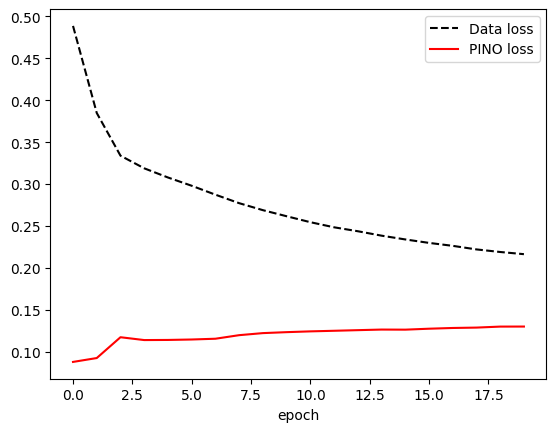

In [ ]:
batch_size = 1024
data_batches = np.array_split(np.array(data_loss_hist), np.ceil(len(np.array(data_loss_hist)) / batch_size))
data_averages = [batch.mean() for batch in data_batches]
pino_batches = np.array_split(np.array(pino_loss_hist), np.ceil(len(np.array(pino_loss_hist)) / batch_size))
pino_averages = [batch.mean() for batch in pino_batches]
plt.plot(np.arange(len(data_averages)), data_averages, label='Data loss', color='k', linestyle='dashed')
plt.plot(np.arange(len(pino_averages)), pino_averages, label='PINO loss', color='r')
plt.legend()
plt.xlabel("epoch")

In [47]:
# обучим PINO с тензором лямбда, у которого обучаются факторы, а ядро взято у PINO-лосса со скейлингом
device = 'mps'
model = PINO_adaptive_tucker_PINO_core(modes = [12,12,12], 
                                        num_fourier_layers=8, 
                                        in_channels=3, 
                                        mid_channels=32, 
                                        projection_channels=64, 
                                        out_channels=1, 
                                        activation=nn.ReLU(),
                                        calc_finite = True,
                                        visc=1e-5,  
                                        ).to(device)

Adam = torch.optim.AdamW(model.parameters(), lr=1e-4)

scheduler = torch.optim.lr_scheduler.StepLR(Adam, step_size=100, gamma=0.5)

model_PINO, loss_hist, validation_metric_hist, lambda_tensor, data_loss_hist, pino_loss_hist = train_FNO_advanced(model=model, 
                                                                                                                optimizer=Adam,
                                                                                                                scheduler=scheduler,
                                                                                                                EPOCHS=20, 
                                                                                                                BATCH_SIZE=1, 
                                                                                                                downsample=False, 
                                                                                                                device='mps')

 50%|█████     | 10/20 [1:35:19<1:35:41, 574.20s/it]

Epoch 10, loss: 0.3240, validation metric: 0.2820


100%|██████████| 20/20 [3:11:51<00:00, 575.56s/it]  

Epoch 20, loss: 0.2858, validation metric: 0.2310


In [126]:
print('Среднее: ', lambda_tensor.mean().item(),' min:', lambda_tensor.min().item(),' max:', lambda_tensor.max().item(),' стандартное отклонение:', lambda_tensor.std().item(),' дисперсия:', lambda_tensor.var().item())

Среднее:  -2.0789101995433157e-08  min: -5.411453093984164e-05  max: 5.305276135914028e-05  стандартное отклонение: 1.0308363016520161e-05  дисперсия: 1.0626233920563166e-10


Text(0.5, 0, 'epoch')

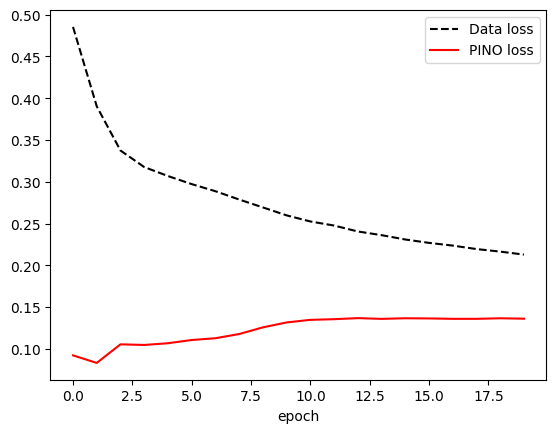

In [127]:
batch_size = 1024
data_batches = np.array_split(np.array(data_loss_hist), np.ceil(len(np.array(data_loss_hist)) / batch_size))
data_averages = [batch.mean() for batch in data_batches]
pino_batches = np.array_split(np.array(pino_loss_hist), np.ceil(len(np.array(pino_loss_hist)) / batch_size))
pino_averages = [batch.mean() for batch in pino_batches]
plt.plot(np.arange(len(data_averages)), data_averages, label='Data loss', color='k', linestyle='dashed')
plt.plot(np.arange(len(pino_averages)), pino_averages, label='PINO loss', color='r')
plt.legend()
plt.xlabel("epoch")

In [55]:
data_path = './NavierStokes_V1e-5_N1200_T20.mat'
reader = MatReader(data_path)
w = reader.read_field('u')
N_samples, GRID_SIZE, GRID_SIZE, TIME_STEPS = w.shape
w = w[1024:N_samples,...]
N_samples, GRID_SIZE, GRID_SIZE, TIME_STEPS = w.shape
w = w.to(device)

x = torch.linspace(0, 1, GRID_SIZE)
y = torch.linspace(0, 1, GRID_SIZE)
t = torch.linspace(0, 1, TIME_STEPS)

X_, Y_, T_ = torch.meshgrid(x, y, t, indexing='ij')

X = torch.cat(N_samples * [X_.clone().unsqueeze(0)]).unsqueeze(1)
Y = torch.cat(N_samples * [Y_.clone().unsqueeze(0)]).unsqueeze(1)
T = torch.cat(N_samples * [T_.clone().unsqueeze(0)]).unsqueeze(1)

input = torch.cat([X,Y,T], dim=1)

input[ :, 0, :, :, 0] = w[...,0]
input[ :, 1, :, :, 0] = w[...,0].transpose(1,2)
input = input.to(device)

model0 = torch.load('./pipeline/full_data/downsampled_finite_naive_7_7_7_fl_4_mc_16_pc_32_ReLU_lamb_0_000_E_200_BS_1_251004.pth', weights_only=False).to(device)

model0.eval()
model.eval()
with torch.no_grad():
    outputs0 = model0(input).squeeze(1)
    outputs = model(input).squeeze(1)

metric0 = torch.sqrt((outputs0-w)**2).mean(dim=(0,1,2))
metric = torch.sqrt((outputs-w)**2).mean(dim=(0,1,2))


Text(0.5, 0, 'time_step')

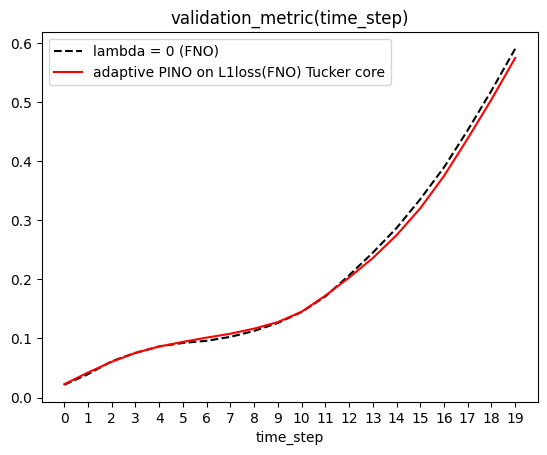

In [ ]:
beginning_step = 0
end_step = 20
plt.xticks(np.arange(len(metric0[beginning_step:end_step])))
plt.plot(np.arange(len(metric0[beginning_step:end_step])), metric0.cpu().numpy()[beginning_step:end_step], label='lambda = 0 (FNO)', color='k', linestyle='dashed')
plt.plot(np.arange(len(metric[beginning_step:end_step])), metric.cpu().numpy()[beginning_step:end_step], label='fully adaptive PINO', color='r')
plt.legend()
plt.title('validation_metric(time_step)')
plt.xlabel("time_step")

Результат не впечатляющий. Однако, огромным преимуществом полностью адаптивного PINO является то обстоятельство, что он обучается всего на 15% медленнее чистого FNO и на 7% медленнее PINO с константной лямбдой

In [128]:
train_pipeline = PINO_train_pipeline(lamb_set=torch.tensor([1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6]))
training_data = train_pipeline.train()


Training for lambda = 0.100


 25%|██▌       | 50/200 [35:40<1:46:56, 42.78s/it]

Epoch 50, loss: 0.2663, validation metric: 0.2408


 50%|█████     | 100/200 [1:11:19<1:11:10, 42.71s/it]

Epoch 100, loss: 0.2319, validation metric: 0.2107


 75%|███████▌  | 150/200 [1:46:59<35:39, 42.79s/it]  

Epoch 150, loss: 0.2139, validation metric: 0.1983


100%|██████████| 200/200 [2:22:42<00:00, 42.81s/it]

Epoch 200, loss: 0.2020, validation metric: 0.1912

Training for lambda = 0.010



 25%|██▌       | 50/200 [35:37<1:46:58, 42.79s/it]

Epoch 50, loss: 0.2983, validation metric: 0.2514


 50%|█████     | 100/200 [1:11:10<1:11:05, 42.65s/it]

Epoch 100, loss: 0.2596, validation metric: 0.2166


 75%|███████▌  | 150/200 [1:46:44<35:34, 42.70s/it]  

Epoch 150, loss: 0.2385, validation metric: 0.2030


100%|██████████| 200/200 [2:22:18<00:00, 42.69s/it]

Epoch 200, loss: 0.2248, validation metric: 0.1974

Training for lambda = 0.001



 25%|██▌       | 50/200 [35:39<1:47:29, 42.99s/it]

Epoch 50, loss: 0.3044, validation metric: 0.2531


 50%|█████     | 100/200 [1:11:31<1:11:41, 43.02s/it]

Epoch 100, loss: 0.2638, validation metric: 0.2167


 75%|███████▌  | 150/200 [1:47:18<35:44, 42.90s/it]  

Epoch 150, loss: 0.2412, validation metric: 0.1988


100%|██████████| 200/200 [2:23:08<00:00, 42.94s/it]

Epoch 200, loss: 0.2264, validation metric: 0.1907

Training for lambda = 0.000



 25%|██▌       | 50/200 [35:46<1:47:45, 43.10s/it]

Epoch 50, loss: 0.3131, validation metric: 0.2709


 50%|█████     | 100/200 [1:11:59<1:13:38, 44.19s/it]

Epoch 100, loss: 0.2746, validation metric: 0.2278


 75%|███████▌  | 150/200 [1:48:07<36:04, 43.29s/it]  

Epoch 150, loss: 0.2524, validation metric: 0.2122


100%|██████████| 200/200 [2:24:09<00:00, 43.25s/it]

Epoch 200, loss: 0.2378, validation metric: 0.2024

Training for lambda = 0.000



 25%|██▌       | 50/200 [36:00<1:47:31, 43.01s/it]

Epoch 50, loss: 0.2976, validation metric: 0.2466


 50%|█████     | 100/200 [1:11:54<1:11:49, 43.10s/it]

Epoch 100, loss: 0.2582, validation metric: 0.2182


 75%|███████▌  | 150/200 [1:47:57<35:58, 43.17s/it]  

Epoch 150, loss: 0.2376, validation metric: 0.2050


100%|██████████| 200/200 [2:23:51<00:00, 43.16s/it]

Epoch 200, loss: 0.2244, validation metric: 0.1964

Training for lambda = 0.000



 25%|██▌       | 50/200 [35:53<1:47:56, 43.17s/it]

Epoch 50, loss: 0.2973, validation metric: 0.2478


 50%|█████     | 100/200 [1:11:42<1:11:28, 42.89s/it]

Epoch 100, loss: 0.2583, validation metric: 0.2137


 75%|███████▌  | 150/200 [1:47:24<35:41, 42.83s/it]  

Epoch 150, loss: 0.2371, validation metric: 0.2008


100%|██████████| 200/200 [2:23:12<00:00, 42.96s/it]

Epoch 200, loss: 0.2232, validation metric: 0.1908
Training data successfully saved to downsampled_finite_naive_7_7_7_fl_4_mc_16_pc_32_ReLU_lamb__E_200_BS_1_251024.json


Наблюдения:
* По логике лямбда ниже определенного порога должно бы было просто перестать влиять на модель.
* Однако наблюдаемая ситуация иная
* При лямбда равном 1е-4 система действительно показывает метрики как у чистого ФНО
* Но при дальнейшем понижении порядка начинается заметное улучшение метрик
* Никакого логичного объяснения такой реакции системы на очень малое возмущение функции потерь я не нахожу

In [6]:
train_pipeline = PINO_train_pipeline(lamb_set=torch.tensor([15e-2, 5e-2]))
training_data = train_pipeline.train()


Training for lambda = 0.150


 25%|██▌       | 50/200 [35:10<1:45:33, 42.22s/it]

Epoch 50, loss: 0.2581, validation metric: 0.2536


 50%|█████     | 100/200 [1:10:21<1:10:30, 42.30s/it]

Epoch 100, loss: 0.2263, validation metric: 0.2147


 75%|███████▌  | 150/200 [1:45:39<35:09, 42.19s/it]  

Epoch 150, loss: 0.2092, validation metric: 0.2035


100%|██████████| 200/200 [2:20:47<00:00, 42.24s/it]

Epoch 200, loss: 0.1982, validation metric: 0.1948

Training for lambda = 0.050



 25%|██▌       | 50/200 [35:22<1:45:27, 42.18s/it]

Epoch 50, loss: 0.2870, validation metric: 0.2436


 50%|█████     | 100/200 [1:10:48<1:10:23, 42.24s/it]

Epoch 100, loss: 0.2469, validation metric: 0.2133


 75%|███████▌  | 150/200 [1:46:03<35:28, 42.58s/it]  

Epoch 150, loss: 0.2270, validation metric: 0.2025


100%|██████████| 200/200 [2:21:37<00:00, 42.49s/it]

Epoch 200, loss: 0.2145, validation metric: 0.1949
Training data successfully saved to downsampled_finite_naive_7_7_7_fl_4_mc_16_pc_32_ReLU_lamb__E_200_BS_1_251024.json


Результаты поиска около значения 0.1 неоднозначны. Попробуем сразу большую модель.

In [8]:
train_pipeline = PINO_train_pipeline(
                                    downsample = False,
                                    modes=[12,12,12], 
                                    num_fourier_layers=8, 
                                    mid_channels=32, 
                                    projection_channels=64,
                                    lamb_set=torch.tensor([0, 2e-1, 1e-1, 1e-2, 1e-5, 1e-6]),
                                    adam_epochs=20,
                                    output_metrics_epochs=10,
                                    )
training_data = train_pipeline.train()


Training for lambda = 0.000


 50%|█████     | 10/20 [1:20:40<1:20:43, 484.37s/it]

Epoch 10, loss: 0.3197, validation metric: 0.2589


100%|██████████| 20/20 [2:41:28<00:00, 484.40s/it]  

Epoch 20, loss: 0.2741, validation metric: 0.2275

Training for lambda = 0.200



 50%|█████     | 10/20 [1:21:37<1:21:37, 489.74s/it]

Epoch 10, loss: 0.2593, validation metric: 0.2571


100%|██████████| 20/20 [2:43:15<00:00, 489.78s/it]  

Epoch 20, loss: 0.2242, validation metric: 0.2127

Training for lambda = 0.100



 50%|█████     | 10/20 [1:21:57<1:21:57, 491.74s/it]

Epoch 10, loss: 0.2924, validation metric: 0.2645


100%|██████████| 20/20 [2:43:56<00:00, 491.80s/it]  

Epoch 20, loss: 0.2541, validation metric: 0.2186

Training for lambda = 0.010



 50%|█████     | 10/20 [1:22:08<1:22:23, 494.32s/it]

Epoch 10, loss: 0.3121, validation metric: 0.2549


100%|██████████| 20/20 [2:44:45<00:00, 494.30s/it]  

Epoch 20, loss: 0.2675, validation metric: 0.2140

Training for lambda = 0.000



 50%|█████     | 10/20 [1:22:29<1:22:30, 495.03s/it]

Epoch 10, loss: 0.3147, validation metric: 0.2623


100%|██████████| 20/20 [2:44:54<00:00, 494.74s/it]  

Epoch 20, loss: 0.2728, validation metric: 0.2183

Training for lambda = 0.000



 50%|█████     | 10/20 [1:22:31<1:22:39, 495.93s/it]

Epoch 10, loss: 0.3125, validation metric: 0.2556


100%|██████████| 20/20 [2:45:09<00:00, 495.47s/it]  

Epoch 20, loss: 0.2700, validation metric: 0.2173
Training data successfully saved to downsampled_finite_naive_12_12_12_fl_8_mc_32_pc_64_ReLU_lamb__E_20_BS_1_251025.json


In [9]:
train_pipeline = PINO_train_pipeline(
                                    downsample = False,
                                    modes=[12,12,12], 
                                    num_fourier_layers=8, 
                                    mid_channels=32, 
                                    projection_channels=64,
                                    lamb_set=torch.tensor([0.001, 0.02, 0.15, 0.25, 0.3, 0.33]),
                                    adam_epochs=20,
                                    output_metrics_epochs=10,
                                    )
training_data = train_pipeline.train()


Training for lambda = 0.001


 50%|█████     | 10/20 [1:22:08<1:21:56, 491.64s/it]

Epoch 10, loss: 0.3146, validation metric: 0.2654


100%|██████████| 20/20 [2:43:57<00:00, 491.86s/it]  

Epoch 20, loss: 0.2719, validation metric: 0.2141

Training for lambda = 0.020



 50%|█████     | 10/20 [1:21:48<1:21:48, 490.81s/it]

Epoch 10, loss: 0.3136, validation metric: 0.2716


100%|██████████| 20/20 [2:44:00<00:00, 492.01s/it]  

Epoch 20, loss: 0.2719, validation metric: 0.2236

Training for lambda = 0.150



 50%|█████     | 10/20 [1:22:27<1:22:30, 495.04s/it]

Epoch 10, loss: 0.2696, validation metric: 0.2551


100%|██████████| 20/20 [2:45:04<00:00, 495.25s/it]  

Epoch 20, loss: 0.2336, validation metric: 0.2162

Training for lambda = 0.250



 50%|█████     | 10/20 [1:21:46<1:21:39, 489.98s/it]

Epoch 10, loss: 0.2436, validation metric: 0.2739


100%|██████████| 20/20 [2:43:37<00:00, 490.88s/it]  

Epoch 20, loss: 0.2125, validation metric: 0.2246

Training for lambda = 0.300



 50%|█████     | 10/20 [1:21:50<1:21:50, 491.09s/it]

Epoch 10, loss: 0.2360, validation metric: 0.2666


100%|██████████| 20/20 [2:43:40<00:00, 491.05s/it]  

Epoch 20, loss: 0.2044, validation metric: 0.2198

Training for lambda = 0.330



 50%|█████     | 10/20 [1:21:45<1:21:45, 490.54s/it]

Epoch 10, loss: 0.2308, validation metric: 0.2837


100%|██████████| 20/20 [2:43:45<00:00, 491.29s/it]  

Epoch 20, loss: 0.2017, validation metric: 0.2332
Training data successfully saved to downsampled_finite_naive_12_12_12_fl_8_mc_32_pc_64_ReLU_lamb__E_20_BS_1_251026.json


In [52]:
import pandas as pd

with open('./pipeline/full_data/downsampled_finite_naive_12_12_12_fl_8_mc_32_pc_64_ReLU_lamb__E_20_BS_1_251025.json', 'r') as file:
    train_data = json.load(file)
with open('./pipeline/full_data/downsampled_finite_naive_12_12_12_fl_8_mc_32_pc_64_ReLU_lamb__E_20_BS_1_251026.json', 'r') as file:
    train_data += json.load(file)


validation_means = [np.asarray(entry['validations']).mean() for entry in train_data]
lambdas = [entry['lamb'] for entry in train_data]

df = pd.DataFrame({'validation_means': validation_means, 'lambdas': lambdas})

In [56]:
df.sort_values(by='validation_means')

,validation_means,lambdas
5,0.267535,1.000000e-06
8,0.267819,1.500000e-01
3,0.269325,1.000000e-02
6,0.269790,1.000000e-03
1,0.270036,2.000000e-01
9,0.271317,2.500000e-01
4,0.272787,1.000000e-05
2,0.274150,1.000000e-01
0,0.274586,0.000000e+00
7,0.275981,2.000000e-02


Довольно интересная картина: мы получили минимальные метрики при лямбда совершенно разных порядков. Однако, исходя из того, что в дальнейшем нам прийдется тестировать как система будет реагировать на отсутствие данных для обучения или на необходимость прогнозировать динамику на длительных временах, мы всеже будем руководствоваться тем, что лямбда должна быть побольше (системе нужно больше физической информированности)

При лямбда 1е-6 сложно себе представить, чтобы система была реально физически информирована. Попробуем сравнить какой будет отклик системы при малом количестве сэмплов для обучения (и большом — для валидации)

In [60]:
train_pipeline = PINO_train_pipeline(
                                    downsample = False,
                                    modes=[12,12,12], 
                                    num_fourier_layers=8, 
                                    mid_channels=32, 
                                    projection_channels=64,
                                    lamb_set=torch.tensor([0, 1e-6, 1e-2, 1.5e-1]),
                                    adam_epochs=20,
                                    output_metrics_epochs=10,
                                    samples_to_train=256
                                    )
training_data = train_pipeline.train()


Training for lambda = 0.000


 50%|█████     | 10/20 [43:01<43:06, 258.67s/it] 

Epoch 10, loss: 0.4105, validation metric: 0.3355


100%|██████████| 20/20 [1:26:05<00:00, 258.27s/it]

Epoch 20, loss: 0.3623, validation metric: 0.3116

Training for lambda = 0.000



 50%|█████     | 10/20 [43:34<43:31, 261.11s/it] 

Epoch 10, loss: 0.3989, validation metric: 0.3258


100%|██████████| 20/20 [1:27:00<00:00, 261.04s/it]

Epoch 20, loss: 0.3508, validation metric: 0.2858

Training for lambda = 0.010



 50%|█████     | 10/20 [43:40<43:40, 262.06s/it] 

Epoch 10, loss: 0.4147, validation metric: 0.3306


100%|██████████| 20/20 [1:27:20<00:00, 262.04s/it]

Epoch 20, loss: 0.3630, validation metric: 0.3080

Training for lambda = 0.150



 50%|█████     | 10/20 [43:35<43:37, 261.73s/it] 

Epoch 10, loss: 0.3487, validation metric: 0.3307


100%|██████████| 20/20 [1:27:08<00:00, 261.40s/it]

Epoch 20, loss: 0.3082, validation metric: 0.2981
Training data successfully saved to downsampled_finite_naive_12_12_12_fl_8_mc_32_pc_64_ReLU_lamb__E_20_BS_1_251026.json


In [61]:
train_pipeline = PINO_train_pipeline(
                                    downsample = False,
                                    modes=[12,12,12], 
                                    num_fourier_layers=8, 
                                    mid_channels=32, 
                                    projection_channels=64,
                                    lamb_set=torch.tensor([1e-1, 1e-3, 1e-4, 1e-5, 1e-7]),
                                    adam_epochs=20,
                                    output_metrics_epochs=10,
                                    samples_to_train=256
                                    )
training_data = train_pipeline.train()


Training for lambda = 0.100


 50%|█████     | 10/20 [43:32<43:33, 261.33s/it] 

Epoch 10, loss: 0.3697, validation metric: 0.3297


100%|██████████| 20/20 [1:27:03<00:00, 261.18s/it]

Epoch 20, loss: 0.3270, validation metric: 0.3005

Training for lambda = 0.001



 50%|█████     | 10/20 [43:27<43:24, 260.42s/it] 

Epoch 10, loss: 0.3920, validation metric: 0.3219


100%|██████████| 20/20 [1:26:59<00:00, 261.00s/it]

Epoch 20, loss: 0.3467, validation metric: 0.2887

Training for lambda = 0.000



 50%|█████     | 10/20 [43:16<43:16, 259.66s/it] 

Epoch 10, loss: 0.4020, validation metric: 0.3303


100%|██████████| 20/20 [1:26:41<00:00, 260.05s/it]

Epoch 20, loss: 0.3567, validation metric: 0.2999

Training for lambda = 0.000



 50%|█████     | 10/20 [43:32<43:32, 261.26s/it] 

Epoch 10, loss: 0.4139, validation metric: 0.3441


100%|██████████| 20/20 [1:27:06<00:00, 261.35s/it]

Epoch 20, loss: 0.3644, validation metric: 0.3088

Training for lambda = 0.000



 50%|█████     | 10/20 [43:30<43:31, 261.10s/it] 

Epoch 10, loss: 0.4155, validation metric: 0.3420


100%|██████████| 20/20 [1:26:49<00:00, 260.46s/it]

Epoch 20, loss: 0.3636, validation metric: 0.2999
Training data successfully saved to downsampled_finite_naive_12_12_12_fl_8_mc_32_pc_64_ReLU_lamb__E_20_BS_1_251027.json


In [6]:
train_pipeline = PINO_train_pipeline(
                                    downsample = False,
                                    modes=[12,12,12], 
                                    num_fourier_layers=8, 
                                    mid_channels=32, 
                                    projection_channels=64,
                                    lamb_set=torch.tensor([1e-6, 1e-3, 0.15]),
                                    adam_epochs=50,
                                    output_metrics_epochs=10,
                                    samples_to_train=64
                                    )
training_data = train_pipeline.train()


Training for lambda = 0.000


 20%|██        | 10/50 [33:14<2:12:52, 199.32s/it]

Epoch 10, loss: 0.5185, validation metric: 0.4443


 40%|████      | 20/50 [1:06:26<1:39:35, 199.18s/it]

Epoch 20, loss: 0.4623, validation metric: 0.3829


 60%|██████    | 30/50 [1:39:38<1:06:26, 199.33s/it]

Epoch 30, loss: 0.4238, validation metric: 0.3401


 80%|████████  | 40/50 [2:12:51<33:12, 199.28s/it]  

Epoch 40, loss: 0.3969, validation metric: 0.3307


100%|██████████| 50/50 [2:46:01<00:00, 199.24s/it]

Epoch 50, loss: 0.3770, validation metric: 0.3167

Training for lambda = 0.001



 20%|██        | 10/50 [33:07<2:12:28, 198.72s/it]

Epoch 10, loss: 0.5147, validation metric: 0.4262


 40%|████      | 20/50 [1:06:13<1:39:20, 198.67s/it]

Epoch 20, loss: 0.4503, validation metric: 0.3812


 60%|██████    | 30/50 [1:39:19<1:06:11, 198.56s/it]

Epoch 30, loss: 0.4127, validation metric: 0.3444


 80%|████████  | 40/50 [2:12:24<33:04, 198.44s/it]  

Epoch 40, loss: 0.3880, validation metric: 0.3202


100%|██████████| 50/50 [2:45:32<00:00, 198.64s/it]

Epoch 50, loss: 0.3703, validation metric: 0.3145

Training for lambda = 0.150



 20%|██        | 10/50 [33:14<2:12:58, 199.46s/it]

Epoch 10, loss: 0.4363, validation metric: 0.4250


 40%|████      | 20/50 [1:06:28<1:39:42, 199.42s/it]

Epoch 20, loss: 0.3854, validation metric: 0.3780


 60%|██████    | 30/50 [1:39:42<1:06:29, 199.48s/it]

Epoch 30, loss: 0.3568, validation metric: 0.3456


 80%|████████  | 40/50 [2:12:56<33:13, 199.40s/it]  

Epoch 40, loss: 0.3384, validation metric: 0.3307


100%|██████████| 50/50 [2:46:22<00:00, 199.65s/it]

Epoch 50, loss: 0.3247, validation metric: 0.3251
Training data successfully saved to downsampled_finite_naive_12_12_12_fl_8_mc_32_pc_64_ReLU_lamb__E_50_BS_1_251027.json


In [7]:
import pandas as pd

with open('./pipeline/full_data/downsampled_finite_naive_12_12_12_fl_8_mc_32_pc_64_ReLU_lamb__E_50_BS_1_251027.json', 'r') as file:
    train_data = json.load(file)

validation_means = [np.asarray(entry['validations']).mean() for entry in train_data]
lambdas = [entry['lamb'] for entry in train_data]

df = pd.DataFrame({'validation_means': validation_means, 'lambdas': lambdas})

In [8]:
df

,validation_means,lambdas
0,0.387963,1.000000e-06
1,0.378188,1.000000e-03
2,0.383740,1.500000e-01


Для дальнейших исследований целесообразно взять лямбда 1е-3. Почему 1е-6 дает практически такой же результат — это мне не понятно совершенно.

In [5]:
train_pipeline = PINO_train_pipeline(
                                    downsample = False,
                                    modes=[12,12,12], 
                                    num_fourier_layers=8, 
                                    mid_channels=32, 
                                    projection_channels=64,
                                    lamb_set=torch.tensor([0, 1e-3]),
                                    adam_epochs=400,
                                    schedule_adam=True,
                                    output_metrics_epochs=100,
                                    samples_to_train=64
                                    )
training_data = train_pipeline.train()


Training for lambda = 0.000


 25%|██▌       | 100/400 [5:29:53<16:31:41, 198.34s/it]

Epoch 100, loss: 0.3214, validation metric: 0.2940


 50%|█████     | 200/400 [11:00:49<11:01:55, 198.58s/it]

Epoch 200, loss: 0.2793, validation metric: 0.2851


 75%|███████▌  | 300/400 [16:31:17<5:29:34, 197.75s/it] 

Epoch 300, loss: 0.2568, validation metric: 0.2780


100%|██████████| 400/400 [22:02:38<00:00, 198.40s/it]  

Epoch 400, loss: 0.2425, validation metric: 0.2759

Training for lambda = 0.001



 25%|██▌       | 100/400 [5:30:17<16:29:49, 197.97s/it]

Epoch 100, loss: 0.3298, validation metric: 0.2993


 50%|█████     | 200/400 [10:59:56<10:59:44, 197.92s/it]

Epoch 200, loss: 0.2826, validation metric: 0.2765


 75%|███████▌  | 300/400 [16:30:27<5:30:33, 198.33s/it] 

Epoch 300, loss: 0.2570, validation metric: 0.2696


100%|██████████| 400/400 [22:00:27<00:00, 198.07s/it]  

Epoch 400, loss: 0.2408, validation metric: 0.2674
Training data successfully saved to finite_naive_12_12_12_fl_8_mc_32_pc_64_ReLU_lamb__E_400_BS_1_251029.json


In [5]:
train_pipeline = PINO_train_pipeline(
                                    downsample = False,
                                    modes=[12,12,12], 
                                    num_fourier_layers=8, 
                                    mid_channels=32, 
                                    projection_channels=64,
                                    lamb_set=torch.tensor([0.15, 1e-6]),
                                    adam_epochs=400,
                                    schedule_adam=True,
                                    output_metrics_epochs=100,
                                    samples_to_train=64
                                    )
training_data = train_pipeline.train()


Training for lambda = 0.150


 25%|██▌       | 100/400 [5:32:00<16:30:55, 198.19s/it]

Epoch 100, loss: 0.2895, validation metric: 0.2876


 50%|█████     | 200/400 [11:02:21<11:01:01, 198.31s/it]

Epoch 200, loss: 0.2407, validation metric: 0.2626


 75%|███████▌  | 300/400 [16:32:06<5:31:02, 198.63s/it] 

Epoch 300, loss: 0.2158, validation metric: 0.2568


100%|██████████| 400/400 [22:01:50<00:00, 198.28s/it]  

Epoch 400, loss: 0.2007, validation metric: 0.2549

Training for lambda = 0.000



 25%|██▌       | 100/400 [5:28:59<16:26:21, 197.27s/it]

Epoch 100, loss: 0.3260, validation metric: 0.2979


 50%|█████     | 200/400 [10:57:43<10:55:57, 196.79s/it]

Epoch 200, loss: 0.2831, validation metric: 0.2841


 75%|███████▌  | 300/400 [16:25:43<5:27:51, 196.71s/it] 

Epoch 300, loss: 0.2597, validation metric: 0.2742


100%|██████████| 400/400 [21:54:20<00:00, 197.15s/it]  

Epoch 400, loss: 0.2448, validation metric: 0.2722
Training data successfully saved to finite_naive_12_12_12_fl_8_mc_32_pc_64_ReLU_lamb__E_400_BS_1_251031.json


Перепишем функции обучения и валидации следующим образом:
* Модель обучается только на первых 10 шагах из 20. Мы "показываем" модели при обучении только первые 10 шагов.
* Функция валидации "строит" обученной моделью первые 10 шагов, а затем, используя финальный 10й шаг как начальные условия, строит еще 10 шагов.
* На валидации будет 2 параметра: ошибка первых 10 шагов и последующих 10 шагов.
* Отдельно нам понадобится функция для тренировки чистого FNO

In [6]:
train_pipeline = PINO_train_pipeline(
                                    downsample = False,
                                    train_mode='half',
                                    modes=[12,12,12], 
                                    num_fourier_layers=8, 
                                    mid_channels=32, 
                                    projection_channels=64,
                                    lamb_set=torch.tensor([0, 0.15]),
                                    adam_epochs=200,
                                    schedule_adam=True,
                                    output_metrics_epochs=100
                                    )
training_data = train_pipeline.train()


Training for lambda = 0.000


 50%|█████     | 100/200 [10:21:11<10:20:26, 372.27s/it]

Epoch 100, loss: 0.0582, validation metric: 0.0467


100%|██████████| 200/200 [20:42:50<00:00, 372.85s/it]   

Epoch 200, loss: 0.0471, validation metric: 0.0419

Training for lambda = 0.150



 50%|█████     | 100/200 [10:30:31<10:32:42, 379.63s/it]

Epoch 100, loss: 0.0489, validation metric: 0.0446


100%|██████████| 200/200 [21:01:35<00:00, 378.48s/it]   

Epoch 200, loss: 0.0391, validation metric: 0.0393
Training data successfully saved to finite_naive_12_12_12_fl_8_mc_32_pc_64_ReLU_lamb__E_200_BS_1_251103.json


Из важного: разница во времени рассчетов составляет всего 1.5% в пользу FNO

In [ ]:
data_path = './NavierStokes_V1e-5_N1200_T20.mat'
half_data_path = './pipeline/half_data/'  
samples_to_train = 1200
adam_batch = 12
pino_model_name = 'downsampled_finite_naive_12_12_12_fl_8_mc_32_pc_64_ReLU_lamb_0_150_E_200_BS_1_251103.pth'
fno_model_name = 'downsampled_finite_naive_12_12_12_fl_8_mc_32_pc_64_ReLU_lamb_0_000_E_200_BS_1_251102.pth'
pino_model = torch.load(half_data_path+pino_model_name, weights_only=False).to(device)
fno_model = torch.load(half_data_path+fno_model_name, weights_only=False).to(device)

reader = MatReader(data_path)
w = reader.read_field('u')
N_samples, GRID_SIZE, GRID_SIZE, TIME_STEPS = w.shape


np.random.seed(333)
all_idx = np.arange(N_samples)
train_idx = np.random.choice(all_idx, int(samples_to_train))

dataset = w[train_idx,...]

train_loader = DataLoader(TensorDataset(dataset), batch_size=adam_batch, shuffle=False)

pino_model.eval()
fno_model.eval()

pino_metric_timesteps_history = []
fno_metric_timesteps_history = []

for  TIME_STEPS in tqdm(range(10, 21)):
    x = torch.linspace(0, 1, GRID_SIZE)
    y = torch.linspace(0, 1, GRID_SIZE)
    t = torch.linspace(0, 1, TIME_STEPS)

    X_, Y_, T_ = torch.meshgrid(x, y, t, indexing='ij')

    pino_metric_history = []
    fno_metric_history = []

    with torch.no_grad():
        for solution in train_loader:
            solution = solution[0][...,:TIME_STEPS].to(device)
            BATCH_S, _, _, _ = solution.shape
            X = torch.cat(BATCH_S * [X_.clone().unsqueeze(0)]).unsqueeze(1).to(device)
            Y = torch.cat(BATCH_S * [Y_.clone().unsqueeze(0)]).unsqueeze(1).to(device)
            T = torch.cat(BATCH_S * [T_.clone().unsqueeze(0)]).unsqueeze(1).to(device)                
            input = torch.cat([X,Y,T], dim=1)
            
            # запишем в x и y начальные условия:
            input[ :, 0, :, :, 0] = solution[:,:,:,0]
            input[ :, 1, :, :, 0] = solution[:,:,:,0].transpose(1,2)

            pino_prediction = pino_model(input).squeeze(1)
            fno_prediction = fno_model(input).squeeze(1)

            pino_metric = nn.L1Loss()(pino_prediction, solution)
            pino_metric_history.append(pino_metric.item())

            fno_metric = nn.L1Loss()(fno_prediction, solution)
            fno_metric_history.append(fno_metric.item())  

    pino_metric_timesteps_history.append(np.array(pino_metric_history).mean())
    fno_metric_timesteps_history.append(np.array(fno_metric_history).mean())    


100%|██████████| 11/11 [42:44<00:00, 233.15s/it]


Text(0.5, 0, 'Time steps (plus to training)')

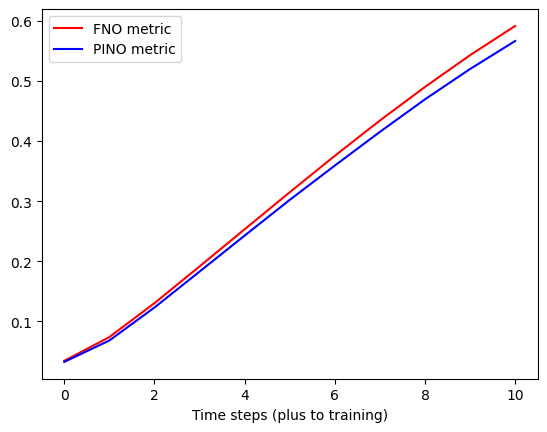

In [30]:
plt.plot(np.arange(len(fno_metric_timesteps_history)), fno_metric_timesteps_history, label='FNO metric', color='r')
plt.plot(np.arange(len(pino_metric_timesteps_history)), pino_metric_timesteps_history, label='PINO metric', color='b')
plt.legend()
plt.xlabel("Time steps (plus to training)")

Text(0.5, 0, 'Time steps (plus to training)')

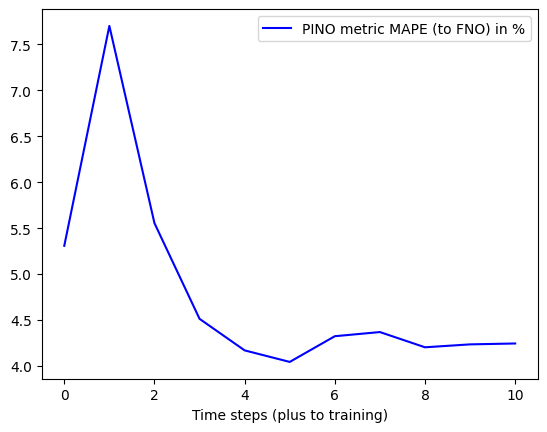

In [36]:
PINO_MAPE = (np.array(fno_metric_timesteps_history)-np.array(pino_metric_timesteps_history))/np.array(fno_metric_timesteps_history) * 100
plt.plot(np.arange(len(pino_metric_timesteps_history)), PINO_MAPE, label='PINO metric MAPE (to FNO) in %', color='b')
plt.legend()
plt.xlabel("Time steps (plus to training)")

In [37]:
PINO_MAPE.max()

7.701896943430538

Здесь мы видим, что самую большую "выгоду" (7.7%) PINO дает в первый же временной шаг, на котором модель не была обучена. Это подсказка, что нужно попробовать авторегрессионный алгоритм валидации модели. 

In [ ]:
data_path = './NavierStokes_V1e-5_N1200_T20.mat'
half_data_path = './pipeline/half_data/'  
samples_to_train = 1200
adam_batch = 12
pino_model_name = 'downsampled_finite_naive_12_12_12_fl_8_mc_32_pc_64_ReLU_lamb_0_150_E_200_BS_1_251103.pth'
fno_model_name = 'downsampled_finite_naive_12_12_12_fl_8_mc_32_pc_64_ReLU_lamb_0_000_E_200_BS_1_251102.pth'
pino_model = torch.load(half_data_path+pino_model_name, weights_only=False).to(device)
fno_model = torch.load(half_data_path+fno_model_name, weights_only=False).to(device)

reader = MatReader(data_path)
w = reader.read_field('u')
N_samples, GRID_SIZE, GRID_SIZE, TIME_STEPS = w.shape

solution_ = w[13,...].unsqueeze(0)

pino_model.eval()
fno_model.eval()

TIME_STEPS = 20

x = torch.linspace(0, 1, GRID_SIZE)
y = torch.linspace(0, 1, GRID_SIZE)
t = torch.linspace(0, 1, TIME_STEPS)

X_, Y_, T_ = torch.meshgrid(x, y, t, indexing='ij')

solution = solution_[...,:TIME_STEPS].to(device)
BATCH_S, _, _, _ = solution.shape
X = torch.cat(BATCH_S * [X_.clone().unsqueeze(0)]).unsqueeze(1).to(device)
Y = torch.cat(BATCH_S * [Y_.clone().unsqueeze(0)]).unsqueeze(1).to(device)
T = torch.cat(BATCH_S * [T_.clone().unsqueeze(0)]).unsqueeze(1).to(device)                
input = torch.cat([X,Y,T], dim=1)

input[ :, 0, :, :, 0] = solution_[:,:,:,0]
input[ :, 1, :, :, 0] = solution_[:,:,:,0].transpose(1,2)

with torch.no_grad():
    pino_prediction = pino_model(input).squeeze(1)
    fno_prediction = fno_model(input).squeeze(1)

TIME_STEPS = 2

x = torch.linspace(0, 1, GRID_SIZE)
y = torch.linspace(0, 1, GRID_SIZE)
t = torch.linspace(0, 1, TIME_STEPS)

X_, Y_, T_ = torch.meshgrid(x, y, t, indexing='ij')

solution = solution_[...,:TIME_STEPS].to(device)
BATCH_S, _, _, _ = solution.shape
X = torch.cat(BATCH_S * [X_.clone().unsqueeze(0)]).unsqueeze(1).to(device)
Y = torch.cat(BATCH_S * [Y_.clone().unsqueeze(0)]).unsqueeze(1).to(device)
T = torch.cat(BATCH_S * [T_.clone().unsqueeze(0)]).unsqueeze(1).to(device)                
input = torch.cat([X,Y,T], dim=1)

input[ :, 0, :, :, 0] = solution_[:,:,:,0]
input[ :, 1, :, :, 0] = solution_[:,:,:,0].transpose(1,2)

with torch.no_grad():
    pino_prediction2 = pino_model(input).squeeze(1)
    fno_prediction2 = fno_model(input).squeeze(1)

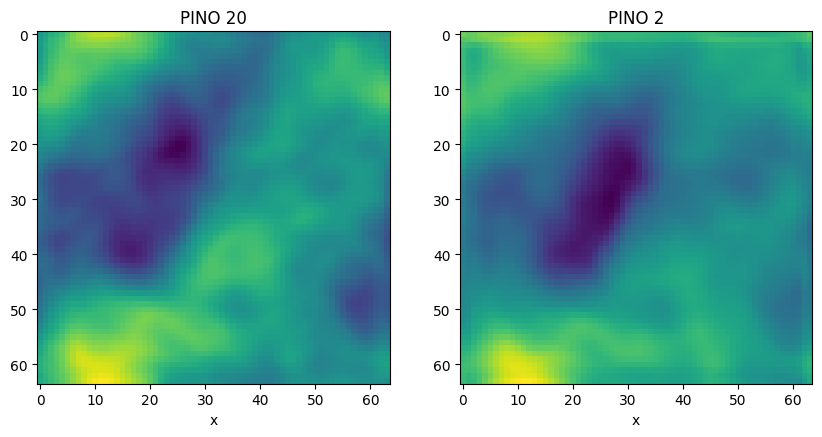

In [53]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title("PINO 20")
plt.xlabel("x")
plt.imshow(pino_prediction.squeeze(0)[...,1].cpu())
plt.subplot(1,2,2)
plt.title("PINO 2")
plt.xlabel("x")
plt.imshow(pino_prediction2.squeeze(0)[...,1].cpu())
plt.show()

Также показательно: если подавать в модель куб, на котором она обучена [64,64,20], то она дает намного более точный срез [64,64,1], нежели если подавать в нее куб [64,64,2]

In [27]:
def validate_model_straight(model, 
                            eval_loader, 
                            X_, Y_, T_, 
                            device='cpu'):
    metric_history = []
    with torch.no_grad():
        for solution in tqdm(eval_loader, desc='iterating straight validation method'):
            solutions_batch = solution[0].to(device)
            BATCH_S, _, _, _ = solutions_batch.shape
            X = torch.cat(BATCH_S * [X_.clone().unsqueeze(0)]).unsqueeze(1).to(device)
            Y = torch.cat(BATCH_S * [Y_.clone().unsqueeze(0)]).unsqueeze(1).to(device)
            T = torch.cat(BATCH_S * [T_.clone().unsqueeze(0)]).unsqueeze(1).to(device)                
            input = torch.cat([X,Y,T], dim=1) 
            # запишем в x и y начальные условия:
            input[ :, 0, :, :, 0] = solutions_batch[...,0]
            input[ :, 1, :, :, 0] = solutions_batch[...,0].transpose(1,2)
            predictions_batch = model(input).squeeze(1)
            metric = nn.L1Loss()(predictions_batch, solutions_batch)
            metric_history.append(metric.item())
    return torch.Tensor(metric_history).mean()

def validate_model_autoregressive(model, 
                                  eval_loader, 
                                  X_, Y_, T_, 
                                  device='cpu'):
    metric_history = []
    with torch.no_grad():
        for solution in tqdm(eval_loader, desc='iterating autoregressive validation method'):
            solutions_batch = solution[0].to(device)
            BATCH_S, _, _, TIME_steps = solutions_batch.shape
            predictions_batch = torch.zeros_like(solutions_batch).to(device)
            X = torch.cat(BATCH_S * [X_.clone().unsqueeze(0)]).unsqueeze(1).to(device)
            Y = torch.cat(BATCH_S * [Y_.clone().unsqueeze(0)]).unsqueeze(1).to(device)
            T = torch.cat(BATCH_S * [T_.clone().unsqueeze(0)]).unsqueeze(1).to(device)                
            input = torch.cat([X,Y,T], dim=1)
            # запишем в x и y начальные условия:
            input[ :, 0, :, :, 0] = solutions_batch[...,0]
            input[ :, 1, :, :, 0] = solutions_batch[...,0].transpose(1,2)
            predictions_batch[...,0] = solutions_batch[...,0]
            for time_step in range(1, TIME_steps):               
                predictions_batch[...,time_step] = (model(input).squeeze(1))[...,1]
                input[ :, 0, :, :, 0] = predictions_batch[...,time_step]
                input[ :, 1, :, :, 0] = predictions_batch[...,time_step].transpose(1,2)
            metric = nn.L1Loss()(predictions_batch, solutions_batch)
            metric_history.append(metric.item())
    return torch.Tensor(metric_history).mean()

Попробуем сравнить 2 механизма валидации (пока в пределах временных шагов, которые "видела" модель в период обучения)

In [28]:
data_path = './NavierStokes_V1e-5_N1200_T20.mat'
half_data_path = './pipeline/half_data/'  
samples_to_train = 1200
adam_batch = 12
pino_model_name = 'downsampled_finite_naive_12_12_12_fl_8_mc_32_pc_64_ReLU_lamb_0_150_E_200_BS_1_251103.pth'
fno_model_name = 'downsampled_finite_naive_12_12_12_fl_8_mc_32_pc_64_ReLU_lamb_0_000_E_200_BS_1_251102.pth'
pino_model = torch.load(half_data_path+pino_model_name, weights_only=False).to(device)
fno_model = torch.load(half_data_path+fno_model_name, weights_only=False).to(device)

reader = MatReader(data_path)
w = reader.read_field('u')
N_samples, GRID_SIZE, GRID_SIZE, TIME_STEPS = w.shape


np.random.seed(333)
all_idx = np.arange(N_samples)
train_idx = np.random.choice(all_idx, int(samples_to_train))

dataset = w[train_idx,...]

data_loader = DataLoader(TensorDataset(dataset), batch_size=adam_batch, shuffle=False)

pino_model.eval()
fno_model.eval()

x = torch.linspace(0, 1, GRID_SIZE)
y = torch.linspace(0, 1, GRID_SIZE)
t = torch.linspace(0, 1, TIME_STEPS)

X_, Y_, T_ = torch.meshgrid(x, y, t, indexing='ij')

straight_validation_metric_fno = validate_model_straight(fno_model, data_loader, X_, Y_, T_, device)
autoregressive_validation_metric_fno = validate_model_autoregressive(fno_model, data_loader, X_, Y_, T_, device)
straight_validation_metric_pino = validate_model_straight(pino_model, data_loader, X_, Y_, T_, device)
autoregressive_validation_metric_pino = validate_model_autoregressive(pino_model, data_loader, X_, Y_, T_, device)

iterating autoregressive validation method: 100%|██████████| 100/100 [44:22<00:00, 26.63s/it]


In [29]:
np.array(straight_validation_metric_fno).mean(), np.array(autoregressive_validation_metric_fno).mean()

(0.59153426, 0.52108747)

In [30]:
np.array(straight_validation_metric_pino).mean(), np.array(autoregressive_validation_metric_pino).mean()

(0.56643, 0.52594244)

Здесь крайне странно, что при авторегрессионном механизме валидации, ПИНО дает хуже ветрики чем ФНО. Поробуем другие механизмы валидации. А именно: по полному кубу, по которому обучалась модель.

In [31]:
data_path = './NavierStokes_V1e-5_N1200_T20.mat'
half_data_path = './pipeline/half_data/'  
samples_to_train = 1200
adam_batch = 12
pino_model_name = 'downsampled_finite_naive_12_12_12_fl_8_mc_32_pc_64_ReLU_lamb_0_150_E_200_BS_1_251103.pth'
fno_model_name = 'downsampled_finite_naive_12_12_12_fl_8_mc_32_pc_64_ReLU_lamb_0_000_E_200_BS_1_251102.pth'
pino_model = torch.load(half_data_path+pino_model_name, weights_only=False).to(device)
fno_model = torch.load(half_data_path+fno_model_name, weights_only=False).to(device)

reader = MatReader(data_path)
w = reader.read_field('u')
N_samples, GRID_SIZE, GRID_SIZE, TIME_STEPS = w.shape


np.random.seed(333)
all_idx = np.arange(N_samples)
train_idx = np.random.choice(all_idx, int(samples_to_train))

TIME_STEPS = int(np.floor(TIME_STEPS / 2))

dataset = w[train_idx, :, :, :TIME_STEPS]

data_loader = DataLoader(TensorDataset(dataset), batch_size=adam_batch, shuffle=False)

pino_model.eval()
fno_model.eval()

x = torch.linspace(0, 1, GRID_SIZE)
y = torch.linspace(0, 1, GRID_SIZE)
t = torch.linspace(0, 1, TIME_STEPS)

X_, Y_, T_ = torch.meshgrid(x, y, t, indexing='ij')

straight_validation_metric_fno = validate_model_straight(fno_model, data_loader, X_, Y_, T_, device)
autoregressive_validation_metric_fno = validate_model_autoregressive(fno_model, data_loader, X_, Y_, T_, device)
straight_validation_metric_pino = validate_model_straight(pino_model, data_loader, X_, Y_, T_, device)
autoregressive_validation_metric_pino = validate_model_autoregressive(pino_model, data_loader, X_, Y_, T_, device)

iterating autoregressive validation method: 100%|██████████| 100/100 [13:12<00:00,  7.93s/it]


In [32]:
np.array(straight_validation_metric_fno).mean(), np.array(autoregressive_validation_metric_fno).mean()

(0.03433634, 0.07328299)

In [33]:
np.array(straight_validation_metric_pino).mean(), np.array(autoregressive_validation_metric_pino).mean()

(0.03251392, 0.07549323)

Но для начала необходимо написать функцию валидации, которая будет первые 20 шагов по времени, на которых обучалась модель подавть целым кубом, а оставшиеся 20 — прогнозировать авторегрессионно

In [67]:
def validate_model_halfly_autoregressive(model, 
                                        eval_loader, 
                                        X_, Y_, T_,    # здесь необходимо подавать Т до 10 шагов а не до 20
                                        device='cpu'):
    metric_history = []
    with torch.no_grad():
        for solution in tqdm(eval_loader, desc='iterating half straight/half autoregressive validation method'):
            solutions_batch = solution[0].to(device)
            BATCH_S, _, _, TIME_steps = solutions_batch.shape # а здесь необходимо подать полные решения (20 временных шагов)
            TIME_steps = int(np.floor(TIME_steps/2))
            X = torch.cat(BATCH_S * [X_.clone().unsqueeze(0)]).unsqueeze(1).to(device)
            Y = torch.cat(BATCH_S * [Y_.clone().unsqueeze(0)]).unsqueeze(1).to(device)
            T = torch.cat(BATCH_S * [T_.clone().unsqueeze(0)]).unsqueeze(1).to(device)                
            input = torch.cat([X,Y,T], dim=1) 
            # запишем в x и y начальные условия:
            input[ :, 0, :, :, 0] = solutions_batch[...,0]
            input[ :, 1, :, :, 0] = solutions_batch[...,0].transpose(1,2)
            predictions_batch_second_half = torch.zeros_like(T.squeeze(1)).to(device) # в этот полукуб будем записывать результаты регрессии
            predictions_batch_first_half = model(input).squeeze(1) # подаем в модель полукуб входов и получаем на выход полукуб предсказаний (это первая половина)

            # берем верхний слой выходного полукуба и запускаем авторегрессию до получения полного куба
            input[ :, 0, :, :, 0] = predictions_batch_first_half[...,-1]
            input[ :, 1, :, :, 0] = predictions_batch_first_half[...,-1].transpose(1,2)            
            for time_step in range(1, TIME_steps):
                predictions_batch_second_half[...,time_step] = (model(input).squeeze(1))[...,1]  # записываем в текущий шаг первый шаг предсказания, нулевой шаг — это НУ
                input[ :, 0, :, :, 0] = predictions_batch_second_half[...,time_step] # записываем этот же шаг в НУ инпута
                input[ :, 1, :, :, 0] = predictions_batch_second_half[...,time_step].transpose(1,2)

            predictions_batch = torch.cat([predictions_batch_first_half, predictions_batch_second_half], dim=-1) # объединяем половинки по измерению T
            metric = nn.L1Loss()(predictions_batch, solutions_batch)
            metric_history.append(metric.item())
    return torch.Tensor(metric_history).mean()


In [68]:
data_path = './NavierStokes_V1e-5_N1200_T20.mat'
half_data_path = './pipeline/half_data/'  
samples_to_train = 1200
adam_batch = 12
pino_model_name = 'downsampled_finite_naive_12_12_12_fl_8_mc_32_pc_64_ReLU_lamb_0_150_E_200_BS_1_251103.pth'
fno_model_name = 'downsampled_finite_naive_12_12_12_fl_8_mc_32_pc_64_ReLU_lamb_0_000_E_200_BS_1_251102.pth'
pino_model = torch.load(half_data_path+pino_model_name, weights_only=False).to(device)
fno_model = torch.load(half_data_path+fno_model_name, weights_only=False).to(device)

reader = MatReader(data_path)
w = reader.read_field('u')
N_samples, GRID_SIZE, GRID_SIZE, TIME_STEPS_full = w.shape


np.random.seed(333)
all_idx = np.arange(N_samples)
train_idx = np.random.choice(all_idx, int(samples_to_train))

TIME_STEPS_half = int(np.floor(TIME_STEPS_full / 2))

dataset = w[train_idx, :, :, :TIME_STEPS_full]

data_loader = DataLoader(TensorDataset(dataset), batch_size=adam_batch, shuffle=False)

pino_model.eval()
fno_model.eval()

x = torch.linspace(0, 1, GRID_SIZE)
y = torch.linspace(0, 1, GRID_SIZE)
t_f = torch.linspace(0, 1, TIME_STEPS_full)
t_h = torch.linspace(0, 1, TIME_STEPS_half)

X_full, Y_full, T_full = torch.meshgrid(x, y, t_f, indexing='ij')
X_half, Y_half, T_half = torch.meshgrid(x, y, t_h, indexing='ij')

straight_validation_metric_fno = validate_model_straight(fno_model, data_loader, X_full, Y_full, T_full, device)
autoregressive_validation_metric_fno = validate_model_halfly_autoregressive(fno_model, data_loader, X_half, Y_half, T_half, device)
straight_validation_metric_pino = validate_model_straight(pino_model, data_loader, X_full, Y_full, T_full, device)
autoregressive_validation_metric_pino = validate_model_halfly_autoregressive(pino_model, data_loader, X_half, Y_half, T_half, device)

iterating straight validation method: 100%|██████████| 100/100 [02:21<00:00,  1.42s/it]
iterating half straight/half autoregressive validation method: 100%|██████████| 100/100 [14:35<00:00,  8.76s/it]
iterating straight validation method: 100%|██████████| 100/100 [02:20<00:00,  1.41s/it]
iterating half straight/half autoregressive validation method: 100%|██████████| 100/100 [14:33<00:00,  8.73s/it]


In [69]:
np.array(straight_validation_metric_fno).mean(), np.array(autoregressive_validation_metric_fno).mean()

(0.59153426, 0.47521675)

Здесь полная авторегрессия давала 0.52108747

In [70]:
np.array(straight_validation_metric_pino).mean(), np.array(autoregressive_validation_metric_pino).mean()

(0.56643, 0.42534894)

А здесь полная авторегрессия давала 0.52594244

Таким образом видим, что ПИНО дает приличный такой прирост (падение в данном случае) метрики. При валидации через полный куб — на 4%, а при валидации через полный куб размера данных обучения, а для каждого последующего шага по времени — авторегрессионно — тут уже выгода 10,5%. Для мизерной разницы во времени рассчета это прекрасный результат.

Осталось проверить 2 вещи:
* Проверить разинцу в валидации на данных, которую модель не "видела" при обучении
* Проверить какой выигрыш ПИНО дает при малом размере обучающей выборки

In [8]:
training_samples_set = [8, 16, 32, 64, 128, 256, 512, 1024]

In [9]:
for training_samples in training_samples_set:
    print(f'Training on {training_samples} samples:')
    train_pipeline = PINO_train_pipeline(
                                        downsample = False,
                                        modes=[12,12,12], 
                                        num_fourier_layers=8, 
                                        mid_channels=32, 
                                        projection_channels=64,
                                        lamb_set=torch.tensor([0, 0.15]),
                                        adam_epochs=200,
                                        schedule_adam=True,
                                        output_metrics_epochs=100,
                                        samples_to_train=training_samples
                                        )
    training_data = train_pipeline.train()

Training on 8 samples:

Training for lambda = 0.000


 50%|█████     | 100/200 [1:04:56<1:52:12, 67.32s/it]

Epoch 100, loss: 0.4662, validation metric: 0.4701


100%|██████████| 200/200 [2:09:31<00:00, 38.86s/it]  

Epoch 200, loss: 0.4077, validation metric: 0.4473

Training for lambda = 0.150



 50%|█████     | 100/200 [1:04:22<1:51:51, 67.12s/it]

Epoch 100, loss: 0.4055, validation metric: 0.4563


100%|██████████| 200/200 [2:08:46<00:00, 38.63s/it]  

Epoch 200, loss: 0.3430, validation metric: 0.4229
Training data successfully saved to finite_naive_12_12_12_fl_8_mc_32_pc_64_ReLU_lamb__E_200_BS_1__tr_smp_8_251106.json
Training on 16 samples:



Training for lambda = 0.000


 50%|█████     | 100/200 [1:09:33<1:56:19, 69.80s/it]

Epoch 100, loss: 0.4120, validation metric: 0.4019


100%|██████████| 200/200 [2:19:09<00:00, 41.75s/it]  

Epoch 200, loss: 0.3504, validation metric: 0.3583

Training for lambda = 0.150



 50%|█████     | 100/200 [1:10:27<1:57:35, 70.56s/it]

Epoch 100, loss: 0.3534, validation metric: 0.3902


100%|██████████| 200/200 [2:20:41<00:00, 42.21s/it]  

Epoch 200, loss: 0.3000, validation metric: 0.3458
Training data successfully saved to finite_naive_12_12_12_fl_8_mc_32_pc_64_ReLU_lamb__E_200_BS_1__tr_smp_16_251106.json
Training on 32 samples:

Training for lambda = 0.000



 50%|█████     | 100/200 [1:20:43<2:06:45, 76.06s/it]

Epoch 100, loss: 0.3548, validation metric: 0.3296


100%|██████████| 200/200 [2:41:25<00:00, 48.43s/it]  

Epoch 200, loss: 0.2995, validation metric: 0.3167

Training for lambda = 0.150



 50%|█████     | 100/200 [1:21:00<2:07:09, 76.30s/it]

Epoch 100, loss: 0.3105, validation metric: 0.3345


100%|██████████| 200/200 [2:42:01<00:00, 48.61s/it]  

Epoch 200, loss: 0.2675, validation metric: 0.3106
Training data successfully saved to finite_naive_12_12_12_fl_8_mc_32_pc_64_ReLU_lamb__E_200_BS_1__tr_smp_32_251106.json
Training on 64 samples:

Training for lambda = 0.000



 50%|█████     | 100/200 [1:43:20<2:28:34, 89.15s/it]

Epoch 100, loss: 0.3271, validation metric: 0.3068


100%|██████████| 200/200 [3:26:43<00:00, 62.02s/it]  

Epoch 200, loss: 0.2823, validation metric: 0.2799

Training for lambda = 0.150



 50%|█████     | 100/200 [1:43:43<2:29:03, 89.44s/it]

Epoch 100, loss: 0.2906, validation metric: 0.2942


100%|██████████| 200/200 [3:27:26<00:00, 62.23s/it]  

Epoch 200, loss: 0.2466, validation metric: 0.2718
Training data successfully saved to finite_naive_12_12_12_fl_8_mc_32_pc_64_ReLU_lamb__E_200_BS_1__tr_smp_64_251106.json
Training on 128 samples:

Training for lambda = 0.000



 50%|█████     | 100/200 [2:28:03<3:12:00, 115.20s/it]

Epoch 100, loss: 0.2912, validation metric: 0.2531


100%|██████████| 200/200 [4:56:17<00:00, 88.89s/it]   

Epoch 200, loss: 0.2443, validation metric: 0.2294

Training for lambda = 0.150



 50%|█████     | 100/200 [2:30:58<3:14:47, 116.88s/it]

Epoch 100, loss: 0.2585, validation metric: 0.2424


100%|██████████| 200/200 [5:01:54<00:00, 90.57s/it]   

Epoch 200, loss: 0.2177, validation metric: 0.2204
Training data successfully saved to finite_naive_12_12_12_fl_8_mc_32_pc_64_ReLU_lamb__E_200_BS_1__tr_smp_128_251107.json
Training on 256 samples:



Training for lambda = 0.000


 50%|█████     | 100/200 [3:57:44<4:34:00, 164.41s/it]

Epoch 100, loss: 0.2534, validation metric: 0.2107


100%|██████████| 200/200 [7:54:29<00:00, 142.35s/it]  

Epoch 200, loss: 0.2102, validation metric: 0.1931

Training for lambda = 0.150



 50%|█████     | 100/200 [3:59:38<4:37:00, 166.20s/it]

Epoch 100, loss: 0.2192, validation metric: 0.2115


100%|██████████| 200/200 [7:59:20<00:00, 143.80s/it]  

Epoch 200, loss: 0.1850, validation metric: 0.1900
Training data successfully saved to finite_naive_12_12_12_fl_8_mc_32_pc_64_ReLU_lamb__E_200_BS_1__tr_smp_256_251107.json
Training on 512 samples:



Training for lambda = 0.000


 50%|█████     | 100/200 [6:55:53<7:22:35, 265.55s/it]

Epoch 100, loss: 0.2115, validation metric: 0.1784


100%|██████████| 200/200 [13:51:33<00:00, 249.47s/it]  

Epoch 200, loss: 0.1752, validation metric: 0.1668

Training for lambda = 0.150



 50%|█████     | 100/200 [7:00:20<7:27:47, 268.67s/it]

Epoch 100, loss: 0.1885, validation metric: 0.1840


100%|██████████| 200/200 [14:03:16<00:00, 252.98s/it]  

Epoch 200, loss: 0.1577, validation metric: 0.1655
Training data successfully saved to finite_naive_12_12_12_fl_8_mc_32_pc_64_ReLU_lamb__E_200_BS_1__tr_smp_512_251109.json
Training on 1024 samples:



Training for lambda = 0.000


 50%|█████     | 100/200 [12:53:26<13:00:29, 468.30s/it]

Epoch 100, loss: 0.1823, validation metric: 0.1562


100%|██████████| 200/200 [25:46:38<00:00, 463.99s/it]   

Epoch 200, loss: 0.1531, validation metric: 0.1466

Training for lambda = 0.150



 50%|█████     | 100/200 [13:05:21<13:14:38, 476.79s/it]

Epoch 100, loss: 0.1644, validation metric: 0.1578


100%|██████████| 200/200 [26:13:28<00:00, 472.04s/it]   

Epoch 200, loss: 0.1404, validation metric: 0.1459
Training data successfully saved to finite_naive_12_12_12_fl_8_mc_32_pc_64_ReLU_lamb__E_200_BS_1__tr_smp_1024_251111.json


Напишем функции, который будут открывать все json файлы в папке и аггрегировать информацию из них в датафрейм

In [13]:
import os
import json
import re
from collections import defaultdict
import pandas as pd

def process_training_data(folder_path, pattern):
    # Словарь для агрегации данных по значению lamb
    lamb_data = defaultdict(list)
    
    # Проверяем существование папки
    if not os.path.exists(folder_path):
        raise FileNotFoundError(f"Папка {folder_path} не существует")
    
    # Регулярное выражение для извлечения числа после паттерна и до следующего "_"
    pattern_regex = re.compile(re.escape(pattern) + r'(\d+)_')
    
    # Проходим по всем файлам в папке
    for filename in os.listdir(folder_path):
        if not filename.endswith('.json'):
            continue
            
        # Ищем совпадение с паттерном в имени файла
        match = pattern_regex.search(filename)
        if not match:
            continue
            
        # Извлекаем число и преобразуем в int
        try:
            training_samples = int(match.group(1))
        except ValueError:
            continue  # Пропускаем файлы, где извлеченное значение не является числом
            
        file_path = os.path.join(folder_path, filename)
        
        try:
            with open(file_path, 'r', encoding='utf-8') as f:
                data = json.load(f)
        except (json.JSONDecodeError, UnicodeDecodeError) as e:
            print(f"Ошибка чтения файла {filename}: {e}")
            continue
        
        # Обрабатываем каждый словарь в данных
        for item in data:
            if not isinstance(item, dict):
                continue
                
            lamb_value = item.get('lamb')
            validations = item.get('validations')
            
            # Проверяем наличие необходимых ключей и корректность типов
            if lamb_value is None or not isinstance(validations, list):
                continue
                
            try:
                validations_min = min(validations)
            except (TypeError, ValueError):
                continue
                
            # Сохраняем данные для агрегации
            lamb_data[lamb_value].append({
                'training_samples': training_samples,
                'validations_min': validations_min
            })
    
    # Формируем финальный результат с сортировкой
    results = []
    for lamb_value, samples_data in lamb_data.items():
        # Сортируем данные по training_samples (от меньшего к большему)
        sorted_data = sorted(samples_data, key=lambda x: x['training_samples'])
        
        # Если для данного lamb только одно значение, сохраняем как есть
        if len(sorted_data) == 1:
            results.append({
                'lamb': round(lamb_value, 6),
                'training_samples': sorted_data[0]['training_samples'],
                'validations_min': sorted_data[0]['validations_min']
            })
        else:
            # Для агрегированных данных создаем списки, сохраняя порядок сортировки
            aggregated_data = {
                'lamb': round(lamb_value, 6),
                'training_samples': [],
                'validations_min': []
            }
            for data_point in sorted_data:
                aggregated_data['training_samples'].append(data_point['training_samples'])
                aggregated_data['validations_min'].append(data_point['validations_min'])
            results.append(aggregated_data)
    
    return results


def create_DF_from_list(full_data):
    rows = []

    # Проходим по всем элементам результата
    for item in full_data:
        lamb_value = item['lamb']
        
        # Проверяем, является ли training_samples списком или одиночным значением
        if isinstance(item['training_samples'], list):
            # Если это список, создаем строку для каждого элемента
            for ts, vm in zip(item['training_samples'], item['validations_min']):
                rows.append({
                    'lamb': lamb_value,
                    'training_samples': ts,
                    'validations_min': vm
                })
        else:
            # Если это одиночное значение, создаем одну строку
            rows.append({
                'lamb': lamb_value,
                'training_samples': item['training_samples'],
                'validations_min': item['validations_min']
            })

    # Создаем DataFrame
    return pd.DataFrame(rows)

In [14]:
half_data_path = './pipeline/half_data/'
full_data_path = './pipeline/full_data/'
pattern = 'tr_smp_'

In [15]:
full_data_015 = process_training_data(full_data_path, pattern)
full_data_1e_3 = process_training_data(full_data_path+'lamb1e-3', pattern)
full_data_1e_6 = process_training_data(full_data_path+'lamb1e-6', pattern)

df1 = create_DF_from_list(full_data_015)
df2 = create_DF_from_list(full_data_1e_3)
df3 = create_DF_from_list(full_data_1e_6)
df_list = [df1,df2,df3]
combined_df = pd.concat(df_list, ignore_index=True)

combined_df = combined_df[combined_df.training_samples != 32].drop_duplicates()

Text(0.5, 0, 'Train dataset size in samples')

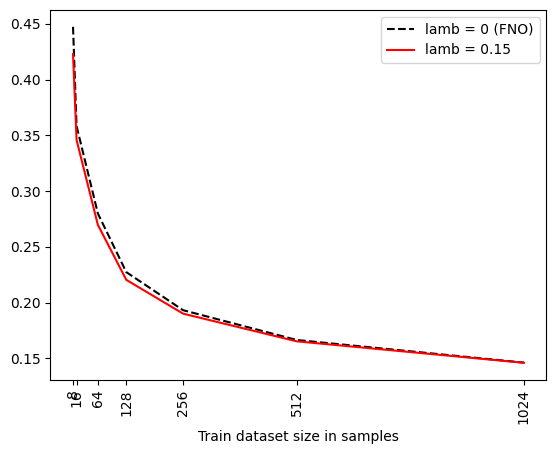

In [12]:
# lamb = [0, 1e-6, 1e-3, 0.15]
lamb = [0, 0.15]
# PINO_MAPE = (np.array(fno_metric_timesteps_history)-np.array(pino_metric_timesteps_history))/np.array(fno_metric_timesteps_history) * 100
plt.xticks(combined_df[combined_df['lamb']==lamb[0]].training_samples.values, rotation=90, fontsize=10)
plt.plot(combined_df[combined_df['lamb']==lamb[0]].training_samples.values, combined_df[combined_df['lamb']==lamb[0]].validations_min.values, label='lamb = 0 (FNO)', color='k',linestyle='dashed')
plt.plot(combined_df[combined_df['lamb']==lamb[1]].training_samples.values, combined_df[combined_df['lamb']==lamb[1]].validations_min.values, label='lamb = 0.15', color='r')
# plt.plot(np.arange(len(combined_df[combined_df['lamb']==lamb[2]].training_samples.values)), combined_df[combined_df['lamb']==lamb[2]].validations_min.values, label='lamb = 1e-3', color='r')
# plt.plot(np.arange(len(combined_df[combined_df['lamb']==lamb[3]].training_samples.values)), combined_df[combined_df['lamb']==lamb[3]].validations_min.values, label='lamb = 0.15', color='y')
plt.legend()
plt.xlabel("Train dataset size in samples")

Для лучшего восприятия, построим относительный "выигрыш" ПИНО относительно ФНО

Text(0.5, 0, 'Train dataset size in samples')

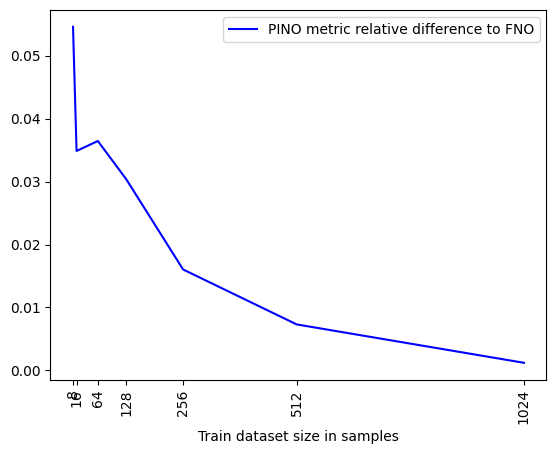

In [13]:
fno_metric = combined_df[combined_df['lamb']==0].validations_min.values
pino_metric = combined_df[combined_df['lamb']==0.15].validations_min.values
PINO_MAPE = (fno_metric - pino_metric)/fno_metric

plt.xticks(combined_df[combined_df['lamb']==lamb[0]].training_samples.values, rotation=90, fontsize=10)
plt.plot(combined_df[combined_df['lamb']==lamb[1]].training_samples.values, PINO_MAPE, label='PINO metric relative difference to FNO', color='b')
plt.legend()
plt.xlabel("Train dataset size in samples")

Text(0.5, 0, 'Train dataset size in samples')

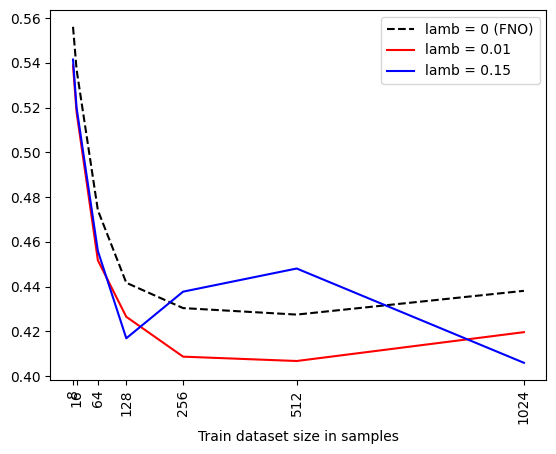

In [17]:
half_data = process_training_data(half_data_path, pattern)

half_data_df = create_DF_from_list(half_data)
half_data_df = half_data_df[half_data_df.training_samples != 32].drop_duplicates()

plt.xticks(half_data_df[half_data_df['lamb']==0].training_samples.values, rotation=90, fontsize=10)
plt.plot(half_data_df[half_data_df['lamb']==0].training_samples.values, half_data_df[half_data_df['lamb']==0].validations_min.values, label='lamb = 0 (FNO)', color='k',linestyle='dashed')
plt.plot(half_data_df[half_data_df['lamb']==0.01].training_samples.values, half_data_df[half_data_df['lamb']==0.01].validations_min.values, label='lamb = 0.01', color='r')
plt.plot(half_data_df[half_data_df['lamb']==0.15].training_samples.values, half_data_df[half_data_df['lamb']==0.15].validations_min.values, label='lamb = 0.15', color='b')
plt.legend()
plt.xlabel("Train dataset size in samples")

Text(0.5, 0, 'Train dataset size in samples')

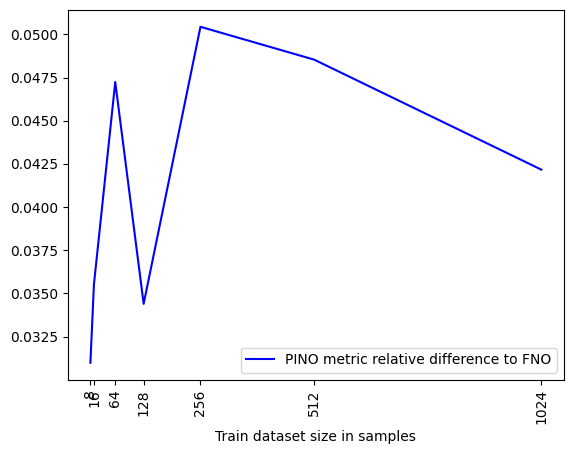

In [18]:
fno_metric = half_data_df[half_data_df['lamb']==0].validations_min.values
pino_metric = half_data_df[half_data_df['lamb']==0.01].validations_min.values
PINO_MAPE = (fno_metric - pino_metric)/fno_metric

plt.xticks(combined_df[combined_df['lamb']==lamb[0]].training_samples.values, rotation=90, fontsize=10)
plt.plot(combined_df[combined_df['lamb']==lamb[1]].training_samples.values, PINO_MAPE, label='PINO metric relative difference to FNO', color='b')
plt.legend()
plt.xlabel("Train dataset size in samples")

Посмотрим теперь как метрика ухудшается с каждым добавленным модели временным шагом для предсказания

In [6]:
def validate_model_straight(model, 
                            eval_loader, 
                            X_, Y_, T_, 
                            device='cpu'):
    metric_history = []
    with torch.no_grad():
        for solution in tqdm(eval_loader, desc='iterating straight validation method'):
            solutions_batch = solution[0].to(device)
            BATCH_S, _, _, _ = solutions_batch.shape
            X = torch.cat(BATCH_S * [X_.clone().unsqueeze(0)]).unsqueeze(1).to(device)
            Y = torch.cat(BATCH_S * [Y_.clone().unsqueeze(0)]).unsqueeze(1).to(device)
            T = torch.cat(BATCH_S * [T_.clone().unsqueeze(0)]).unsqueeze(1).to(device)                
            input = torch.cat([X,Y,T], dim=1) 
            # запишем в x и y начальные условия:
            input[ :, 0, :, :, 0] = solutions_batch[...,0]
            input[ :, 1, :, :, 0] = solutions_batch[...,0].transpose(1,2)
            predictions_batch = model(input).squeeze(1)
            metric = nn.L1Loss()(predictions_batch, solutions_batch)
            metric_history.append(metric.item())
    return torch.Tensor(metric_history).mean()

def validate_model_halfly_autoregressive(model, 
                                        eval_loader, 
                                        X_, Y_, T_,    # здесь необходимо подавать Т до 10 шагов а не до 20
                                        T_steps_to_predict = 10,
                                        device='cpu'):
    metric_history = []
    with torch.no_grad():
        for solution in tqdm(eval_loader, desc='iterating half straight/half autoregressive validation method'):
            solutions_batch = solution[0].to(device)
            BATCH_S, _, _, TIME_steps_init = solutions_batch.shape # а здесь необходимо подать полные решения (20 временных шагов)
            TIME_steps = int(np.floor(TIME_steps_init/2))
            X = torch.cat(BATCH_S * [X_.clone().unsqueeze(0)]).unsqueeze(1).to(device)
            Y = torch.cat(BATCH_S * [Y_.clone().unsqueeze(0)]).unsqueeze(1).to(device)
            T = torch.cat(BATCH_S * [T_.clone().unsqueeze(0)]).unsqueeze(1).to(device)                
            input = torch.cat([X,Y,T], dim=1) 
            # запишем в x и y начальные условия:
            input[ :, 0, :, :, 0] = solutions_batch[...,0]
            input[ :, 1, :, :, 0] = solutions_batch[...,0].transpose(1,2)
            predictions_batch_second_half = torch.zeros_like(T.squeeze(1)[...,:T_steps_to_predict]).to(device) # в этот полукуб будем записывать результаты регрессии
            predictions_batch_first_half = model(input).squeeze(1) # подаем в модель полукуб входов и получаем на выход полукуб предсказаний (это первая половина)

            # берем верхний слой выходного полукуба и запускаем авторегрессию до получения полного куба
            input[ :, 0, :, :, 0] = predictions_batch_first_half[...,-1]
            input[ :, 1, :, :, 0] = predictions_batch_first_half[...,-1].transpose(1,2)            
            for time_step in range(0, T_steps_to_predict):
                predictions_batch_second_half[...,time_step] = (model(input).squeeze(1))[...,1]  # записываем в текущий шаг первый шаг предсказания, нулевой шаг — это НУ
                input[ :, 0, :, :, 0] = predictions_batch_second_half[...,time_step] # записываем этот же шаг в НУ инпута
                input[ :, 1, :, :, 0] = predictions_batch_second_half[...,time_step].transpose(1,2)
            predictions_batch = torch.cat([predictions_batch_first_half, predictions_batch_second_half], dim=-1) # объединяем половинки по измерению T
            metric = nn.L1Loss()(predictions_batch, solutions_batch[...,:TIME_steps+T_steps_to_predict])
            metric_history.append(metric.item())
    return torch.Tensor(metric_history).mean()



In [66]:
data_path = './NavierStokes_V1e-5_N1200_T20.mat'
half_data_path = './pipeline/half_data/'  

samples_to_train = 1024
adam_batch = 16

pino_model_name = 'downsampled_finite_naive_12_12_12_fl_8_mc_32_pc_64_ReLU_lamb_0_150_E_200_BS_1__tr_smp_1024_251111.pth'
fno_model_name = 'downsampled_finite_naive_12_12_12_fl_8_mc_32_pc_64_ReLU_lamb_0_000_E_200_BS_1__tr_smp_1024_251111.pth'
pino_model = torch.load(half_data_path+pino_model_name, weights_only=False, map_location=torch.device(device)).to(device)
fno_model = torch.load(half_data_path+fno_model_name, weights_only=False, map_location=torch.device(device)).to(device)

reader = MatReader(data_path)
w = reader.read_field('u')
N_samples, GRID_SIZE, GRID_SIZE, TIME_STEPS_full = w.shape

TIME_STEPS_half = int(np.floor(TIME_STEPS_full / 2))

dataset = w[samples_to_train+1:N_samples, :, :, :TIME_STEPS_full]

data_loader = DataLoader(TensorDataset(dataset), batch_size=adam_batch, shuffle=False)

pino_model.eval()
fno_model.eval()

x = torch.linspace(0, 1, GRID_SIZE)
y = torch.linspace(0, 1, GRID_SIZE)
t_f = torch.linspace(0, 1, TIME_STEPS_full)
t_h = torch.linspace(0, 1, TIME_STEPS_half)

X_full, Y_full, T_full = torch.meshgrid(x, y, t_f, indexing='ij')
X_half, Y_half, T_half = torch.meshgrid(x, y, t_h, indexing='ij')

validation_metric_fno_history = []
validation_metric_pino_history = []

for t_step_predict in range(1,11):
    print(f'Processing {t_step_predict} forecast steps:')
    # straight_validation_metric_fno = validate_model_straight(fno_model, data_loader, X_full, Y_full, T_full, device=device)
    validation_metric_fno = validate_model_halfly_autoregressive(fno_model, data_loader, 
                                                                                X_half, Y_half, T_half, 
                                                                                T_steps_to_predict = t_step_predict, 
                                                                                device=device)
    validation_metric_fno_history.append(validation_metric_fno)
    
    # straight_validation_metric_pino = validate_model_straight(pino_model, data_loader, X_full, Y_full, T_full, device=device)
    validation_metric_pino = validate_model_halfly_autoregressive(pino_model, data_loader, 
                                                                                X_half, Y_half, T_half,
                                                                                T_steps_to_predict = t_step_predict, 
                                                                                device=device)
    validation_metric_pino_history.append(validation_metric_pino)

Processing 1 forecast steps:


iterating half straight/half autoregressive validation method: 100%|██████████| 11/11 [00:25<00:00,  2.31s/it]
iterating half straight/half autoregressive validation method: 100%|██████████| 11/11 [00:25<00:00,  2.29s/it]


Processing 2 forecast steps:


iterating half straight/half autoregressive validation method: 100%|██████████| 11/11 [00:37<00:00,  3.45s/it]
iterating half straight/half autoregressive validation method: 100%|██████████| 11/11 [00:37<00:00,  3.42s/it]


Processing 3 forecast steps:


iterating half straight/half autoregressive validation method: 100%|██████████| 11/11 [00:50<00:00,  4.59s/it]
iterating half straight/half autoregressive validation method: 100%|██████████| 11/11 [00:50<00:00,  4.56s/it]


Processing 4 forecast steps:


iterating half straight/half autoregressive validation method: 100%|██████████| 11/11 [01:03<00:00,  5.73s/it]
iterating half straight/half autoregressive validation method: 100%|██████████| 11/11 [01:02<00:00,  5.69s/it]


Processing 5 forecast steps:


iterating half straight/half autoregressive validation method: 100%|██████████| 11/11 [01:15<00:00,  6.87s/it]
iterating half straight/half autoregressive validation method: 100%|██████████| 11/11 [01:15<00:00,  6.83s/it]


Processing 6 forecast steps:


iterating half straight/half autoregressive validation method: 100%|██████████| 11/11 [01:28<00:00,  8.01s/it]
iterating half straight/half autoregressive validation method: 100%|██████████| 11/11 [01:27<00:00,  7.98s/it]


Processing 7 forecast steps:


iterating half straight/half autoregressive validation method: 100%|██████████| 11/11 [01:41<00:00,  9.21s/it]
iterating half straight/half autoregressive validation method: 100%|██████████| 11/11 [01:40<00:00,  9.15s/it]


Processing 8 forecast steps:


iterating half straight/half autoregressive validation method: 100%|██████████| 11/11 [01:53<00:00, 10.30s/it]
iterating half straight/half autoregressive validation method: 100%|██████████| 11/11 [01:52<00:00, 10.24s/it]


Processing 9 forecast steps:


iterating half straight/half autoregressive validation method: 100%|██████████| 11/11 [02:05<00:00, 11.43s/it]
iterating half straight/half autoregressive validation method: 100%|██████████| 11/11 [02:05<00:00, 11.39s/it]


Processing 10 forecast steps:


iterating half straight/half autoregressive validation method: 100%|██████████| 11/11 [02:18<00:00, 12.57s/it]
iterating half straight/half autoregressive validation method: 100%|██████████| 11/11 [02:17<00:00, 12.49s/it]


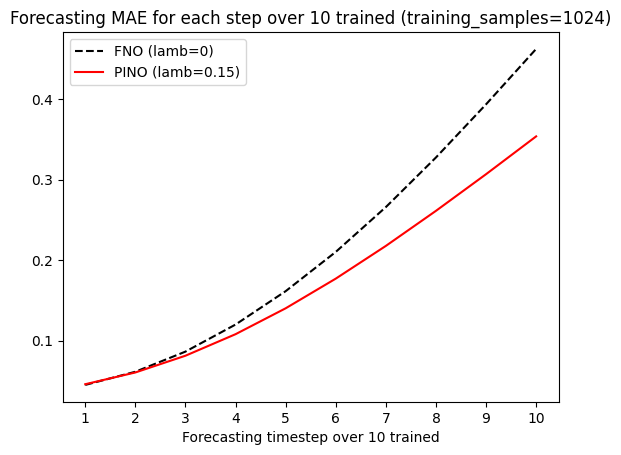

In [71]:
plt.xticks(range(1,11))
plt.title('Forecasting MAE for each step over 10 trained (training_samples=1024)')
plt.plot(range(1,11), validation_metric_fno_history, label='FNO (lamb=0)', color='k',linestyle='dashed')
plt.plot(range(1,11), validation_metric_pino_history, label='PINO (lamb=0.15)', color='r')
plt.xlabel('Forecasting timestep over 10 trained')
plt.legend()

In [73]:
data_path = './NavierStokes_V1e-5_N1200_T20.mat'
half_data_path = './pipeline/half_data/'  

samples_to_train = 64
adam_batch = 16

pino_model_name = 'downsampled_finite_naive_12_12_12_fl_8_mc_32_pc_64_ReLU_lamb_0_010_E_200_BS_1__tr_smp_64_251112.pth'
fno_model_name = 'downsampled_finite_naive_12_12_12_fl_8_mc_32_pc_64_ReLU_lamb_0_000_E_200_BS_1__tr_smp_64_251110.pth'
pino_model = torch.load(half_data_path+pino_model_name, weights_only=False, map_location=torch.device(device)).to(device)
fno_model = torch.load(half_data_path+fno_model_name, weights_only=False, map_location=torch.device(device)).to(device)

reader = MatReader(data_path)
w = reader.read_field('u')
N_samples, GRID_SIZE, GRID_SIZE, TIME_STEPS_full = w.shape

TIME_STEPS_half = int(np.floor(TIME_STEPS_full / 2))

dataset = w[samples_to_train+1:N_samples, :, :, :TIME_STEPS_full]

data_loader = DataLoader(TensorDataset(dataset), batch_size=adam_batch, shuffle=False)

pino_model.eval()
fno_model.eval()

x = torch.linspace(0, 1, GRID_SIZE)
y = torch.linspace(0, 1, GRID_SIZE)
t_f = torch.linspace(0, 1, TIME_STEPS_full)
t_h = torch.linspace(0, 1, TIME_STEPS_half)

X_full, Y_full, T_full = torch.meshgrid(x, y, t_f, indexing='ij')
X_half, Y_half, T_half = torch.meshgrid(x, y, t_h, indexing='ij')

validation_metric_fno_history = []
validation_metric_pino_history = []

for t_step_predict in range(1,11):
    print(f'Processing {t_step_predict} forecast steps:')
    # straight_validation_metric_fno = validate_model_straight(fno_model, data_loader, X_full, Y_full, T_full, device=device)
    validation_metric_fno = validate_model_halfly_autoregressive(fno_model, data_loader, 
                                                                                X_half, Y_half, T_half, 
                                                                                T_steps_to_predict = t_step_predict, 
                                                                                device=device)
    validation_metric_fno_history.append(validation_metric_fno)
    
    # straight_validation_metric_pino = validate_model_straight(pino_model, data_loader, X_full, Y_full, T_full, device=device)
    validation_metric_pino = validate_model_halfly_autoregressive(pino_model, data_loader, 
                                                                                X_half, Y_half, T_half,
                                                                                T_steps_to_predict = t_step_predict, 
                                                                                device=device)
    validation_metric_pino_history.append(validation_metric_pino)

Processing 1 forecast steps:


iterating half straight/half autoregressive validation method: 100%|██████████| 71/71 [02:43<00:00,  2.30s/it]
iterating half straight/half autoregressive validation method: 100%|██████████| 71/71 [02:42<00:00,  2.29s/it]


Processing 2 forecast steps:


iterating half straight/half autoregressive validation method: 100%|██████████| 71/71 [04:03<00:00,  3.43s/it]
iterating half straight/half autoregressive validation method: 100%|██████████| 71/71 [04:03<00:00,  3.43s/it]


Processing 3 forecast steps:


iterating half straight/half autoregressive validation method: 100%|██████████| 71/71 [05:24<00:00,  4.57s/it]
iterating half straight/half autoregressive validation method: 100%|██████████| 71/71 [05:24<00:00,  4.57s/it]


Processing 4 forecast steps:


iterating half straight/half autoregressive validation method: 100%|██████████| 71/71 [06:45<00:00,  5.71s/it]
iterating half straight/half autoregressive validation method: 100%|██████████| 71/71 [06:45<00:00,  5.70s/it]


Processing 5 forecast steps:


iterating half straight/half autoregressive validation method: 100%|██████████| 71/71 [08:06<00:00,  6.85s/it]
iterating half straight/half autoregressive validation method: 100%|██████████| 71/71 [08:05<00:00,  6.84s/it]


Processing 6 forecast steps:


iterating half straight/half autoregressive validation method: 100%|██████████| 71/71 [09:27<00:00,  7.99s/it]
iterating half straight/half autoregressive validation method: 100%|██████████| 71/71 [09:26<00:00,  7.98s/it]


Processing 7 forecast steps:


iterating half straight/half autoregressive validation method: 100%|██████████| 71/71 [10:48<00:00,  9.13s/it]
iterating half straight/half autoregressive validation method: 100%|██████████| 71/71 [10:47<00:00,  9.12s/it]


Processing 8 forecast steps:


iterating half straight/half autoregressive validation method: 100%|██████████| 71/71 [12:08<00:00, 10.27s/it]
iterating half straight/half autoregressive validation method: 100%|██████████| 71/71 [12:08<00:00, 10.26s/it]


Processing 9 forecast steps:


iterating half straight/half autoregressive validation method: 100%|██████████| 71/71 [13:29<00:00, 11.41s/it]
iterating half straight/half autoregressive validation method: 100%|██████████| 71/71 [13:28<00:00, 11.39s/it]


Processing 10 forecast steps:


iterating half straight/half autoregressive validation method: 100%|██████████| 71/71 [14:50<00:00, 12.55s/it]
iterating half straight/half autoregressive validation method: 100%|██████████| 71/71 [14:49<00:00, 12.53s/it]


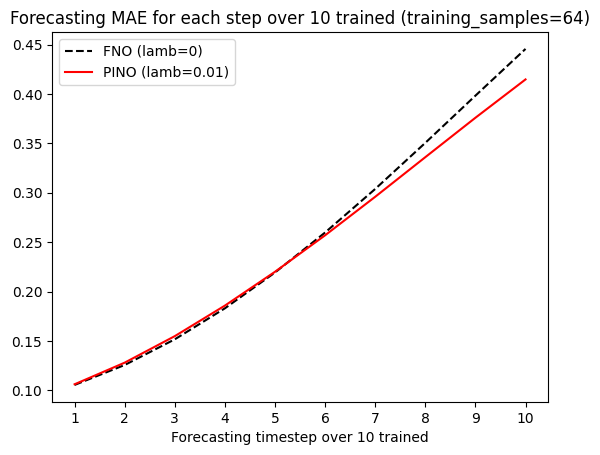

In [74]:
plt.xticks(range(1,11))
plt.title('Forecasting MAE for each step over 10 trained (training_samples=64)')
plt.plot(range(1,11), validation_metric_fno_history, label='FNO (lamb=0)', color='k',linestyle='dashed')
plt.plot(range(1,11), validation_metric_pino_history, label='PINO (lamb=0.01)', color='r')
plt.xlabel('Forecasting timestep over 10 trained')
plt.legend()

In [16]:
data_path = './NavierStokes_V1e-5_N1200_T20.mat'
half_data_path = './pipeline/half_data/'  

samples_to_train = 64
adam_batch = 16

pino_model_name = 'downsampled_finite_naive_12_12_12_fl_8_mc_32_pc_64_ReLU_lamb_0_150_E_200_BS_1__tr_smp_64_251110.pth'
fno_model_name = 'downsampled_finite_naive_12_12_12_fl_8_mc_32_pc_64_ReLU_lamb_0_000_E_200_BS_1__tr_smp_64_251110.pth'
pino_model = torch.load(half_data_path+pino_model_name, weights_only=False, map_location=torch.device(device)).to(device)
fno_model = torch.load(half_data_path+fno_model_name, weights_only=False, map_location=torch.device(device)).to(device)

reader = MatReader(data_path)
w = reader.read_field('u')
N_samples, GRID_SIZE, GRID_SIZE, TIME_STEPS_full = w.shape

TIME_STEPS_half = int(np.floor(TIME_STEPS_full / 2))

dataset = w[samples_to_train+1:N_samples, :, :, :TIME_STEPS_full]

data_loader = DataLoader(TensorDataset(dataset), batch_size=adam_batch, shuffle=False)

pino_model.eval()
fno_model.eval()

x = torch.linspace(0, 1, GRID_SIZE)
y = torch.linspace(0, 1, GRID_SIZE)
t_f = torch.linspace(0, 1, TIME_STEPS_full)
t_h = torch.linspace(0, 1, TIME_STEPS_half)

X_full, Y_full, T_full = torch.meshgrid(x, y, t_f, indexing='ij')
X_half, Y_half, T_half = torch.meshgrid(x, y, t_h, indexing='ij')

validation_metric_fno_history = []
validation_metric_pino_history = []

for t_step_predict in range(1,11):
    print(f'Processing {t_step_predict} forecast steps:')
    # straight_validation_metric_fno = validate_model_straight(fno_model, data_loader, X_full, Y_full, T_full, device=device)
    validation_metric_fno = validate_model_halfly_autoregressive(fno_model, data_loader, 
                                                                                X_half, Y_half, T_half, 
                                                                                T_steps_to_predict = t_step_predict, 
                                                                                device=device)
    validation_metric_fno_history.append(validation_metric_fno)
    
    # straight_validation_metric_pino = validate_model_straight(pino_model, data_loader, X_full, Y_full, T_full, device=device)
    validation_metric_pino = validate_model_halfly_autoregressive(pino_model, data_loader, 
                                                                                X_half, Y_half, T_half,
                                                                                T_steps_to_predict = t_step_predict, 
                                                                                device=device)
    validation_metric_pino_history.append(validation_metric_pino)

Processing 1 forecast steps:


iterating half straight/half autoregressive validation method: 100%|██████████| 71/71 [02:44<00:00,  2.32s/it]
iterating half straight/half autoregressive validation method: 100%|██████████| 71/71 [02:44<00:00,  2.31s/it]


Processing 2 forecast steps:


iterating half straight/half autoregressive validation method: 100%|██████████| 71/71 [04:03<00:00,  3.44s/it]
iterating half straight/half autoregressive validation method: 100%|██████████| 71/71 [04:04<00:00,  3.44s/it]


Processing 3 forecast steps:


iterating half straight/half autoregressive validation method: 100%|██████████| 71/71 [05:25<00:00,  4.59s/it]
iterating half straight/half autoregressive validation method: 100%|██████████| 71/71 [05:25<00:00,  4.58s/it]


Processing 4 forecast steps:


iterating half straight/half autoregressive validation method: 100%|██████████| 71/71 [06:46<00:00,  5.72s/it]
iterating half straight/half autoregressive validation method: 100%|██████████| 71/71 [06:46<00:00,  5.72s/it]


Processing 5 forecast steps:


iterating half straight/half autoregressive validation method: 100%|██████████| 71/71 [08:07<00:00,  6.86s/it]
iterating half straight/half autoregressive validation method: 100%|██████████| 71/71 [08:07<00:00,  6.86s/it]


Processing 6 forecast steps:


iterating half straight/half autoregressive validation method: 100%|██████████| 71/71 [09:28<00:00,  8.01s/it]
iterating half straight/half autoregressive validation method: 100%|██████████| 71/71 [09:28<00:00,  8.01s/it]


Processing 7 forecast steps:


iterating half straight/half autoregressive validation method: 100%|██████████| 71/71 [10:49<00:00,  9.15s/it]
iterating half straight/half autoregressive validation method: 100%|██████████| 71/71 [10:49<00:00,  9.15s/it]


Processing 8 forecast steps:


iterating half straight/half autoregressive validation method: 100%|██████████| 71/71 [12:09<00:00, 10.27s/it]
iterating half straight/half autoregressive validation method: 100%|██████████| 71/71 [12:15<00:00, 10.35s/it]


Processing 9 forecast steps:


iterating half straight/half autoregressive validation method: 100%|██████████| 71/71 [13:33<00:00, 11.46s/it]
iterating half straight/half autoregressive validation method: 100%|██████████| 71/71 [13:31<00:00, 11.44s/it]


Processing 10 forecast steps:


iterating half straight/half autoregressive validation method: 100%|██████████| 71/71 [14:52<00:00, 12.56s/it]
iterating half straight/half autoregressive validation method: 100%|██████████| 71/71 [14:53<00:00, 12.58s/it]


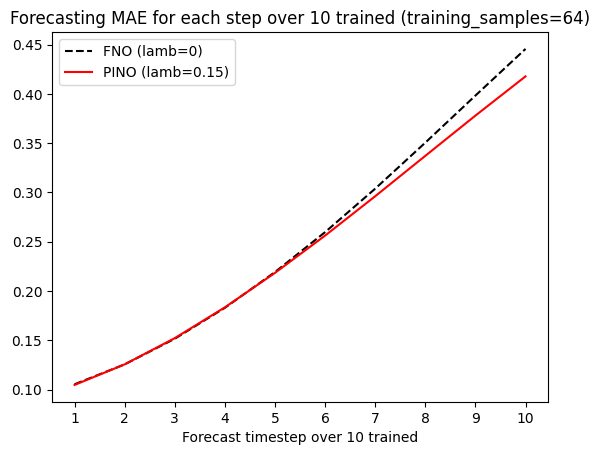

In [17]:
plt.xticks(range(1,11))
plt.title('Forecasting MAE for each step over 10 trained (training_samples=64)')
plt.plot(range(1,11), validation_metric_fno_history, label='FNO (lamb=0)', color='k',linestyle='dashed')
plt.plot(range(1,11), validation_metric_pino_history, label='PINO (lamb=0.15)', color='r')
plt.xlabel('Forecast timestep over 10 trained')
plt.legend()